<a href="https://colab.research.google.com/github/JulioLaz/store_sales_analysis_sqlite/blob/shared/Store_Sales_Analysis_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

#**1. Configuración del Ambiente**


---




In [1]:
# !python -V
# print('------')
# !pip show Pandas | grep 'Name\|Version'
# print('------')
# !pip show Matplotlib | grep 'Name\|Version'

          # Python 3.10.12
          # ------
          # Name: pandas
          # Version: 2.0.3
          # ------
          # Name: matplotlib
          # Version: 3.7.1

In [2]:
!pip install geobr
import geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.3
    Uninstalling shapely-2.0.3:
      Successfully uninstalled shapely-2.0.3
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


In [3]:
# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_row', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [5]:
df_itens_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_itens_pedidos.head()

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
0          1        41518        341         3             260          780   
1          2         4307       1174         5            6175        30875   
2          3        22407       1399         3             200          600   
3          4         3820       1652         6             139          834   
4          5        29012       2470         3             525         1575   

  ciudad  costo_envio  
0  BR-BA        156.0  
1  BR-RJ       6175.0  
2  BR-PB        120.0  
3  BR-DF        166.8  
4  BR-BA        315.0

In [6]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

pedido_id  producto_id  vendedor_id fecha_compra  total
0        341        41518            6   2019-01-05    780
1       1174         4307            3   2019-01-05  30875
2       1399        22407            1   2019-01-05    600
3       1652         3820            4   2019-01-05    834
4       2470        29012            2   2019-01-05   1575

In [7]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

producto_id                 producto  precio                marca  \
0        21244     Oculos Lente Azulada    1120  D&g Dolce & Gabbana   
1         9981         Bolsa Coral Saco    4000             Givenchy   
2        84176      Camisa Xadrez Verde     310            Joe Fresh   
3        47475  Calca Alfaiataria Preta     490                Mixed   
4        74864    Vestido Jeans Babados     130                 Zara   

        sku condicion  
0  209297.0     Usado  
1  278612.0     Usado  
2  322482.0     Usado  
3  263658.0     Usado  
4  219248.0     Usado

In [8]:
len(df_productos.producto.unique())

202

In [9]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores.head()

vendedor_id  nombre_vendedor
0            1       Ana Duarte
1            2  Daniel Siqueira
2            3   Nadia Oliveira
3            4  Millena Pereira
4            5    Paulo Calanca

In [10]:
df_itens_pedidos.head(1)

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
0          1        41518        341         3             260          780   

  ciudad  costo_envio  
0  BR-BA        156.0

In [11]:
###  GUARDAR DDBB EN DRIVE  ###

# df_vendedores.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/vendedores.csv', index=False)
# df_itens_pedidos.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/itens_pedidos.csv', index=False)
# df_pedidos.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/pedidos.csv', index=False)
# df_productos.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/DDBB/productos.csv', index=False)

In [12]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]

for df in dfs:
    print('Cantidad de valores únicos de:')
    print('-------------------------------')
    for n in df.columns:
        print(f'{n}: {len(df[n].unique())}')

Cantidad de valores únicos de:
-------------------------------
id_recibo: 24527
producto_id: 205
pedido_id: 24527
cantidad: 6
valor_unitario: 85
valor_total: 354
ciudad: 27
costo_envio: 354
Cantidad de valores únicos de:
-------------------------------
pedido_id: 24527
producto_id: 205
vendedor_id: 6
fecha_compra: 780
total: 354
Cantidad de valores únicos de:
-------------------------------
producto_id: 207
producto: 202
precio: 85
marca: 117
sku: 206
condicion: 3
Cantidad de valores únicos de:
-------------------------------
vendedor_id: 6
nombre_vendedor: 6


In [13]:
def info_df(dfs):
    for df in dfs:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print("Nombre del DataFrame:", df_name)
        print(df.info())
        print('-------------------------------------------')

In [14]:
dfs=[df_itens_pedidos,df_pedidos,df_productos,df_vendedores]
info_df(dfs)

Nombre del DataFrame: df_itens_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------------------------------------
Nombre del DataFrame: df_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 

##**2.2 Tratamiento de Datos**

In [15]:
df_productos[df_productos.producto.isna()]

producto_id producto  precio                marca  sku  \
205        41598      NaN     260      Banana Republic  NaN   
206        32926      NaN     210  Limone By Jade Seba  NaN   

              condicion  
205  Nuevo con etiqueta  
206  Nuevo sin etiqueta

### LOS PRODUCTOS QUE PRESENTAN NAN Y TIENE UN SKU NAN, SERÁN ELIMINADOS. ESTÁN FUERA DE CONTROL!

### Daclaración de la función preprocesamiento:

In [16]:
def preprocesamiento():
    global df_itens_pedidos, df_pedidos, df_productos, df_vendedores

    # Eliminar registros con valores nulos en columnas primary o foreign key
    df_itens_pedidos.dropna(subset=['pedido_id', 'producto_id'], inplace=True)
    df_pedidos.dropna(subset=['pedido_id', 'producto_id', 'vendedor_id'], inplace=True)
    df_productos.dropna(subset=['producto_id','producto'], inplace=True)###elimino tambien los nan de producto
    df_vendedores.dropna(subset=['vendedor_id'], inplace=True)

    #eliminar la fila con Unknown
    df_vendedores = df_vendedores[df_vendedores['nombre_vendedor'] != 'Unknown']

    # Eliminar registros duplicados
    df_itens_pedidos.drop_duplicates(inplace=True)
    df_pedidos.drop_duplicates(inplace=True)
    df_productos.drop_duplicates(inplace=True)
    df_vendedores.drop_duplicates(inplace=True)

    # Asegurar tipos de datos correctos:
    df_itens_pedidos['id_recibo'] = df_itens_pedidos['id_recibo'].astype(int)
    df_itens_pedidos['producto_id'] = df_itens_pedidos['producto_id'].astype(int)
    df_itens_pedidos['pedido_id'] = df_itens_pedidos['pedido_id'].astype(int)
    df_itens_pedidos['ciudad'] = df_itens_pedidos['ciudad'].astype(str)
    df_itens_pedidos['costo_envio'] = df_itens_pedidos['costo_envio'].astype(float)

    df_pedidos['pedido_id'] = df_pedidos['pedido_id'].astype(int)
    df_pedidos['producto_id'] = df_pedidos['producto_id'].astype(int)
    df_pedidos['vendedor_id'] = df_pedidos['vendedor_id'].astype(int)
    df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'])

    df_productos['producto_id'] = df_productos['producto_id'].astype(int)
    df_productos['precio'] = df_productos['precio'].astype(float)
    df_productos['sku'] = df_productos['sku'].astype(str)

    df_vendedores['vendedor_id'] = df_vendedores['vendedor_id'].astype(int)
    df_vendedores['nombre_vendedor'] = df_vendedores['nombre_vendedor'].astype(str)

    return df_itens_pedidos, df_pedidos, df_productos, df_vendedores

df_itens_pedidos, df_pedidos, df_productos, df_vendedores = preprocesamiento()

<ipython-input-16-33b9c90aa8fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendedores.drop_duplicates(inplace=True)
<ipython-input-16-33b9c90aa8fa>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendedores['vendedor_id'] = df_vendedores['vendedor_id'].astype(int)
<ipython-input-16-33b9c90aa8fa>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [17]:
df_vendedores

vendedor_id  nombre_vendedor
0            1       Ana Duarte
1            2  Daniel Siqueira
2            3   Nadia Oliveira
3            4  Millena Pereira
4            5    Paulo Calanca

### Verificar DDBB:

In [18]:
dfs=[df_itens_pedidos,df_pedidos,df_productos,df_vendedores]
info_df(dfs)

Nombre del DataFrame: df_itens_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------------------------------------
Nombre del DataFrame: df_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 

##**2.3 Análisis Exploratorio (EDA)**

### Ver DDBB: Decribe

In [19]:
def describe_dfs_all(dfs):
  for df in dfs:
    df_name = [name for name, obj in globals().items() if obj is df][0]
    print("Nombre del DataFrame:", df_name)
    print(df.describe().round(1))
    print('--------------------------------------------------------------------------------------')

In [20]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]
describe_dfs_all(dfs)

Nombre del DataFrame: df_itens_pedidos
       id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
count    24527.0      24527.0    24527.0   24527.0         24527.0   
mean     12405.4      44627.6    69931.4       3.5           535.7   
std       7242.7      29347.8    40560.8       1.7           839.2   
min          1.0       2706.0        1.0       1.0            45.0   
25%       6132.5      17258.0    34487.0       2.0           210.0   
50%      12264.0      42913.0    69945.0       4.0           336.0   
75%      18689.5      70673.0   105355.0       5.0           450.0   
max      25055.0     100983.0   139993.0       6.0          6500.0   

       valor_total  costo_envio  
count      24527.0      24527.0  
mean        1867.5        373.5  
std         3379.7        675.9  
min           45.0          9.0  
25%          520.0        104.0  
50%         1050.0        210.0  
75%         1920.0        384.0  
max        39000.0       7800.0  
------------------------

In [21]:
def describe_dfs(dfs):
    for df in dfs:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print("Nombre del DataFrame:", df_name)
        non_id_columns = [col for col in df.columns if 'id' not in col.lower()]
        if non_id_columns:
            print(df[non_id_columns].describe().round(1))
        else:
            print("No hay columnas para describir, todas son identificadores.")
        print('-------------------------------------------')

In [22]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]
describe_dfs(dfs)

Nombre del DataFrame: df_itens_pedidos
       valor_unitario  valor_total  costo_envio
count         24527.0      24527.0      24527.0
mean            535.7       1867.5        373.5
std             839.2       3379.7        675.9
min              45.0         45.0          9.0
25%             210.0        520.0        104.0
50%             336.0       1050.0        210.0
75%             450.0       1920.0        384.0
max            6500.0      39000.0       7800.0
-------------------------------------------
Nombre del DataFrame: df_pedidos
                        fecha_compra    total
count                          24527  24527.0
mean   2020-04-02 12:10:46.406001664   1867.5
min              2019-01-05 00:00:00     45.0
25%              2019-11-12 00:00:00    520.0
50%              2020-04-09 00:00:00   1050.0
75%              2020-09-21 00:00:00   1920.0
max              2021-03-10 00:00:00  39000.0
std                              NaN   3379.7
--------------------------------------

In [23]:
df_pedidos.sample(5)

pedido_id  producto_id  vendedor_id fecha_compra  total
22535      56346        12751            1   2020-12-28    800
20374      42305        18751            1   2020-11-17   1980
17256      27410        15470            1   2020-08-20   2950
23585      12723         8707            3   2021-01-25    750
7153      123256        47682            5   2019-12-01   2150

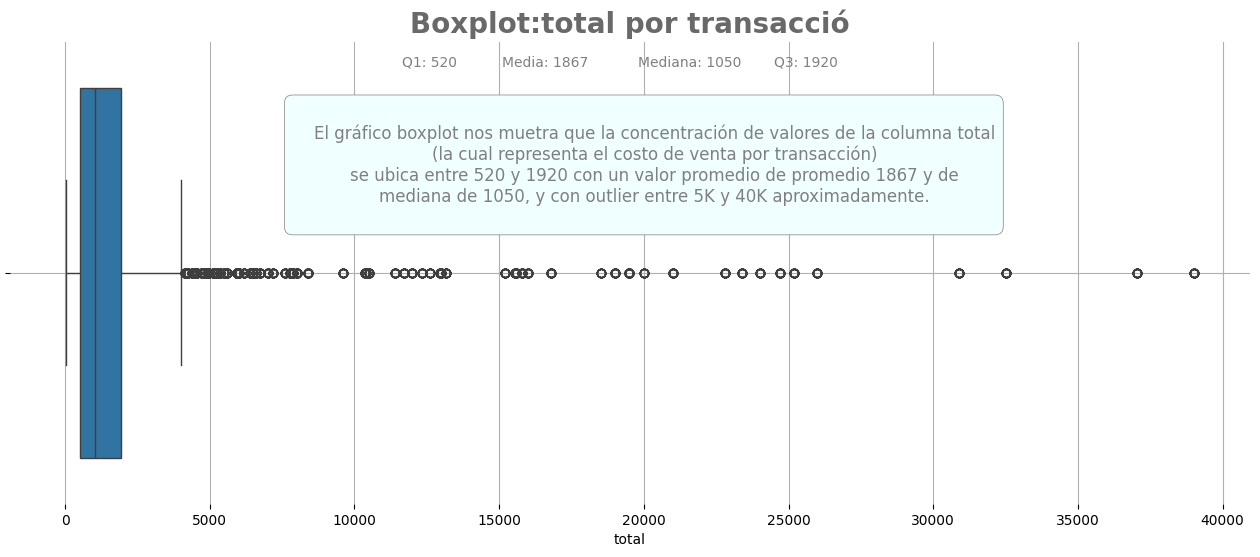

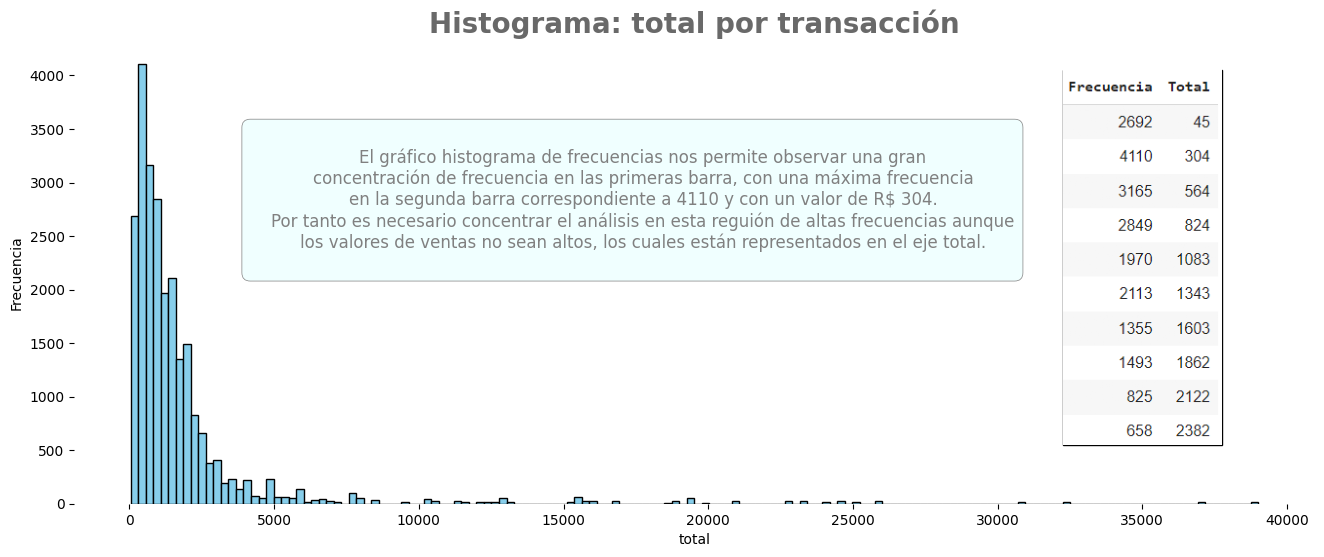

In [24]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def Boxplot_Histograma_graf(df, col):
    global df_histograma
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot:{col} por transacció',fontsize=20,color='dimgray', fontweight= 'bold')

    # Calcular estadísticos descriptivos
    quartiles = df[col].quantile([0.25, 0.75])
    mean = df[col].mean()

    # Agregar anotaciones
    plt.text(12600, -.44, f'Q1: {quartiles[0.25]:.0f}', ha='center', va='bottom', color='gray')
    plt.text(16600, -.44, f'Media: {mean:.0f}', ha='center', va='bottom', color='gray')
    plt.text(21600, -.44, f'Mediana: {df[col].median():.0f}', ha='center', va='bottom', color='gray')
    plt.text(25600, -.44, f'Q3: {quartiles[0.75]:.0f}', ha='center', va='bottom', color='gray')

    plt.xlabel(col)
    plt.ylabel('')
    plt.grid(None)
    plt.box(None)
    text_boxplot = f'''
    El gráfico boxplot nos muetra que la concentración de valores de la columna total
    (la cual representa el costo de venta por transacción)
    se ubica entre {quartiles[0.25]:.0f} y {quartiles[0.75]:.0f} con un valor promedio de promedio {mean:.0f} y de
    mediana de {df[col].median():.0f}, y con outlier entre 5K y 40K aproximadamente.
    '''
    # plt.text(2e4, -0.1, text_boxplot, ha='center', va='bottom', color='black')
    plt.annotate(text_boxplot, xy=(2e4, -0.1), xytext=(0, 0), textcoords='offset points',
             ha='center', va='bottom',bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.5), fontsize=12, color='grey')
    plt.show()

    plt.figure(figsize=(16, 6))
    freq, bins, _ = plt.hist(df[col], bins=150, color='skyblue', edgecolor='black')
    df_histograma = pd.DataFrame({'Frecuencia': freq, 'Total': bins[:-1]}).head(10)

    plt.title(f'Histograma: {col} por transacción',fontsize=20,color='dimgray', fontweight= 'bold')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    text_histograma = f'''
    El gráfico histograma de frecuencias nos permite observar una gran
    concentración de frecuencia en las primeras barra, con una máxima frecuencia
    en la segunda barra correspondiente a {int(df_histograma.Frecuencia.iloc[1])} y con un valor de R$ {int(df_histograma.Total.iloc[1])}.
    Por tanto es necesario concentrar el análisis en esta reguión de altas frecuencias aunque
    los valores de ventas no sean altos, los cuales están representados en el eje total.
    '''
    # plt.text(17e3, 2500, text_histograma, ha='center', va='bottom', color='black')
    plt.annotate(text_histograma, xy=(0.45, 0.5), xycoords='axes fraction', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.5), fontsize=12, color='grey')

    plt.box(None)
        # Mostrar la imagen
    img = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/tabla_histograma.png'
    img_ventas = OffsetImage(plt.imread(img), zoom=0.7)
    ab_ventas = AnnotationBbox(img_ventas, (35000, 2300), frameon=True, xycoords='data', boxcoords='data', pad=0, zorder=100)
    plt.gca().add_artist(ab_ventas)  # Ajusta las coordenadas según sea necesario
    plt.show()

Boxplot_Histograma_graf(df_pedidos, 'total')


In [25]:
df_histograma.astype(int)

Frecuencia  Total
0        2692     45
1        4110    304
2        3165    564
3        2849    824
4        1970   1083
5        2113   1343
6        1355   1603
7        1493   1862
8         825   2122
9         658   2382

In [26]:
df_productos.describe()

producto_id       precio
count     205.000000   205.000000
mean    44803.365854   536.009756
std     29419.632374   843.774387
min      2706.000000    45.000000
25%     17329.000000   210.000000
50%     43054.000000   336.000000
75%     70673.000000   450.000000
max    100983.000000  6500.000000

In [27]:
df_productos.sample(5)

producto_id                   producto  precio           marca       sku  \
14         60010       Vestido Estampa Azul    90.0      Forever 21  272238.0   
2          84176        Camisa Xadrez Verde   310.0       Joe Fresh  322482.0   
45         83792        Calca Costuras Bege   390.0         Agilità  313737.0   
168        41189      Calca Acetinada Preta   160.0            Zara  176893.0   
82         29893  Sandalia Plataforma Corda   420.0  Luiza Barcelos  123641.0   

              condicion  
14   Nuevo con etiqueta  
2                 Usado  
45                Usado  
168               Usado  
82                Usado

In [28]:
df_productos.marca.unique()

array(['D&g Dolce & Gabbana', 'Givenchy', 'Joe Fresh', 'Mixed', 'Zara',
       'Gap', 'Banana Republic', 'Fyi', 'Sacada', 'Rag & Bone', 'Cori',
       'Forever 21', 'Tigresse', 'Tory Burch', 'Brooksfield', 'Animale',
       '284', 'Dkny', 'Cheroy', 'Canal', 'Le Lis Blanc', 'Spezzato',
       'Cantão', 'Talie Nk', 'H&M', 'Schutz', 'Jorge Bischoff',
       'Luisa Farani', 'Seven', 'Kipling', 'Louis Vuitton', 'Agilità',
       'Fabiana Caterina', 'Reinaldo Lourenço', 'Karmani', 'Erre Erre',
       'H&m', 'Forum', 'Ellus', 'J. Crew', "Joe's", 'Galeria Tricot',
       'Loft 747', 'Oxyfit', 'Topshop', 'A.brand', 'Isolda',
       'American Eagle', 'Colcci', 'Carter’s', 'Thay Ribas',
       'Carina Duek', 'Kate Spade', 'Bottega Veneta', 'Morena Rosa',
       'Luiza Barcelos', 'Lezalez', 'My Place', 'Farm', 'Armani Exchange',
       'Bcbgmaxzria', 'Dica da Ka', 'My Shoes', 'Argentum',
       'Red Valentino', 'Maria Filó', 'Marc By Marcjacobs',
       'Track & Field', 'Christian Dior', 'Toca do 

In [29]:
len(df_productos.marca.unique())

117

In [30]:
df_productos.condicion.value_counts()

condicion
Usado                 176
Nuevo con etiqueta     22
Nuevo sin etiqueta      7
Name: count, dtype: int64

In [31]:
# Calcular la frecuencia de cada marca
marca_counts = df_productos['marca'].value_counts()

# Filtrar las marcas con frecuencia mayor que 1
marca_counts_gt1 = marca_counts[marca_counts > 1]

# Mostrar las marcas con frecuencia mayor que 1
print(marca_counts_gt1)


marca
Zara               23
Mixed              14
Animale             9
Le Lis Blanc        6
Banana Republic     5
Farm                4
H&m                 4
Forever 21          3
Forum               3
Dress&co            3
Tigresse            3
Sacada              3
Shoulder            3
Hollister           2
Schutz              2
Colcci              2
A.brand             2
Bazar Genial        2
Ellus               2
Ralph Lauren        2
Maria Bonita        2
Thelure             2
Levi's              2
Seven               2
Jorge Bischoff      2
Christian Dior      2
Fyi                 2
Cantão              2
Cori                2
Spezzato            2
Tory Burch          2
Name: count, dtype: int64


In [32]:
# Agrupar por marca y sumar los precios
agrupado_por_marca = df_productos.groupby('marca')['precio'].sum()
df_agrupado_por_marca = agrupado_por_marca.to_frame()

df_agrupado_por_marca.reset_index(drop=False, inplace=True)
df_agrupado_por_marca_ordenado = df_agrupado_por_marca.sort_values(by='precio', ascending=False)

df_agrupado_por_marca_ordenado.rename(columns={'precio':'suma_precio'},inplace=True)
df_agrupado_por_marca_ordenado

marca  suma_precio
85              Mixed      10811.0
27     Christian Dior       7250.0
17     Bottega Veneta       6175.0
13       Barbara Bela       4200.0
51           Givenchy       4000.0
..                ...          ...
43   Fabiana Caterina        120.0
114     Track & Field        120.0
111    Toca do Coelho        110.0
57     Isa Kulikovski         90.0
53                H&M         45.0

[117 rows x 2 columns]

In [33]:
df_productos[df_productos.marca=='Mixed']

producto_id                 producto  precio  marca       sku  \
3          47475  Calca Alfaiataria Preta   490.0  Mixed  263658.0   
9           6262        Camiseta Eternity   644.0  Mixed  247015.0   
17         31835           Camisa Seda Pb   399.0  Mixed  258114.0   
21         17990        Saia Couro Tijolo  3800.0  Mixed  255109.0   
37          5292        Saia Jeans Forest   576.0  Mixed  222683.0   
68         11736         Saia Guipir Nude   740.0  Mixed  324428.0   
79          6381       Camiseta Cindy Sky   586.0  Mixed  193567.0   
83         68110     Casaqueto Fio Mescla   790.0  Mixed  294836.0   
110         6137         Camisa Tear Folk   100.0  Mixed  114671.0   
115         5995          Calca Linho Ten   398.0  Mixed  216052.0   
120        15470      Vestido Jeans Ombro   590.0  Mixed  292393.0   
140         2706              Blusa Cinza   590.0  Mixed  297627.0   
147         7193        Saia Preta Babado   320.0  Mixed  185450.0   
173         5412     Camiseta Tencel Umay   788.0  Mixed  257373.0   

              condicion  
3                 Usado  
9    Nuevo con etiqueta  
17                Usado  
21                Usado  
37   Nuevo con etiqueta  
68                Usado  
79   Nuevo con etiqueta  
83                Usado  
110  Nuevo con etiqueta  
115  Nuevo con etiqueta  
120               Usado  
140               Usado  
147               Usado  
173  Nuevo con etiqueta

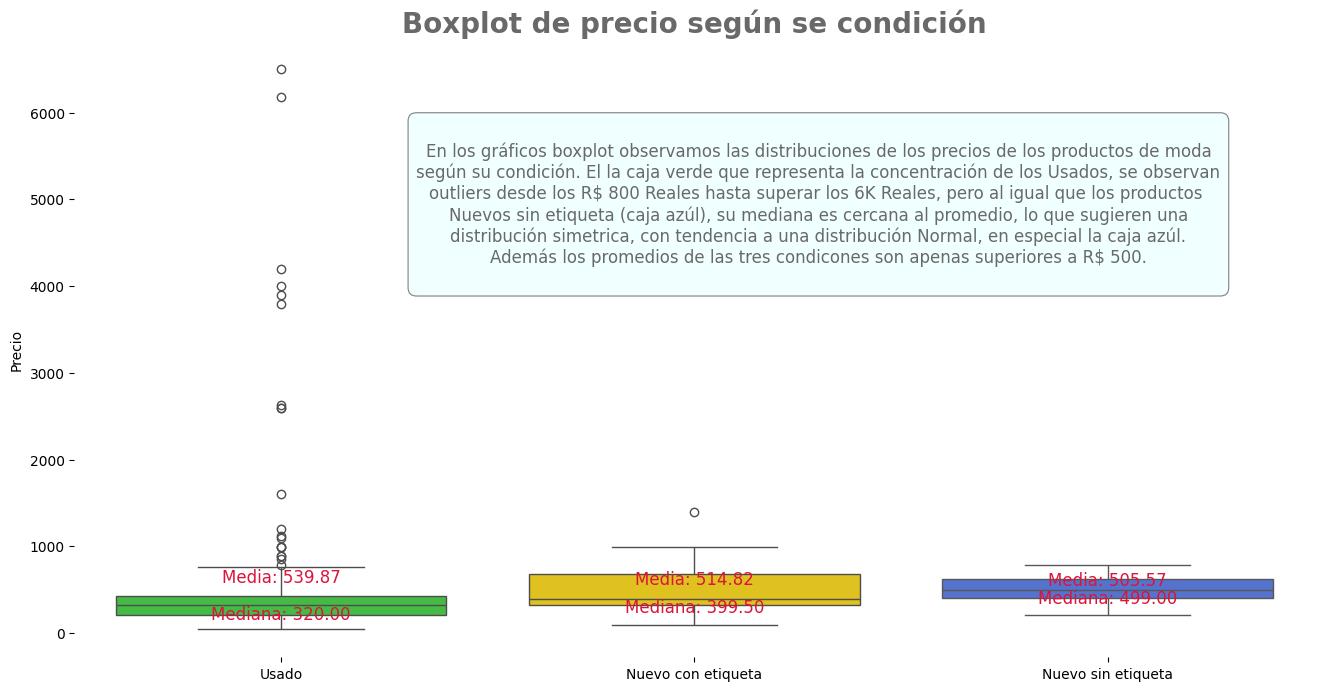

In [34]:
# Filtrar el DataFrame para cada condición
df_usado = df_productos[df_productos['condicion'] == 'Usado']
df_nuevo = df_productos[df_productos['condicion'] == 'Nuevo con etiqueta']
df_etiqueta = df_productos[df_productos['condicion'] == 'Nuevo sin etiqueta']

# Crear los boxplots
plt.subplots(figsize=(16, 8), facecolor='none')
sns.boxplot(data=df_usado, x='condicion', y='precio', color='limegreen')
sns.boxplot(data=df_nuevo, x='condicion', y='precio', color='gold')
sns.boxplot(data=df_etiqueta, x='condicion', y='precio', color='royalblue')

# Calcular medianas y medias
median_usado = np.median(df_usado['precio'])
median_nuevo = np.median(df_nuevo['precio'])
median_etiqueta = np.median(df_etiqueta['precio'])

mean_usado = np.mean(df_usado['precio'])
mean_nuevo = np.mean(df_nuevo['precio'])
mean_etiqueta = np.mean(df_etiqueta['precio'])

# Mostrar valores en la gráfica
plt.text(0, median_usado, f'Mediana: {median_usado:.2f}', ha='center', va='top', color='crimson', fontsize=12)
plt.text(1, median_nuevo, f'Mediana: {median_nuevo:.2f}', ha='center', va='top', color='crimson', fontsize=12)
plt.text(2, median_etiqueta, f'Mediana: {median_etiqueta:.2f}', ha='center', va='top', color='crimson', fontsize=12)

plt.text(0, mean_usado, f'Media: {mean_usado:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)
plt.text(1, mean_nuevo, f'Media: {mean_nuevo:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)
plt.text(2, mean_etiqueta, f'Media: {mean_etiqueta:.2f}', ha='center', va='bottom', color='crimson', fontsize=12)

text_boxplot = '''
En los gráficos boxplot observamos las distribuciones de los precios de los productos de moda
según su condición. El la caja verde que representa la concentración de los Usados, se observan
outliers desde los R$ 800 Reales hasta superar los 6K Reales, pero al igual que los productos
Nuevos sin etiqueta (caja azúl), su mediana es cercana al promedio, lo que sugieren una
distribución simetrica, con tendencia a una distribución Normal, en especial la caja azúl.
Además los promedios de las tres condicones son apenas superiores a R$ 500.
'''
plt.annotate(text_boxplot, xy=(0.6, 0.6), xycoords='axes fraction', ha='center', va='bottom',
         bbox=dict(boxstyle='round,pad=.5', fc='azure', ec='gray', lw=.8), fontsize=12, color='dimgray')


plt.title('Boxplot de precio según se condición',fontsize=20, color='dimgray', fontweight='bold')
plt.xlabel('')
plt.ylabel('Precio')
plt.box(None)
plt.show()


In [35]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  205 non-null    int64  
 1   producto     205 non-null    object 
 2   precio       205 non-null    float64
 3   marca        205 non-null    object 
 4   sku          205 non-null    object 
 5   condicion    205 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 11.2+ KB


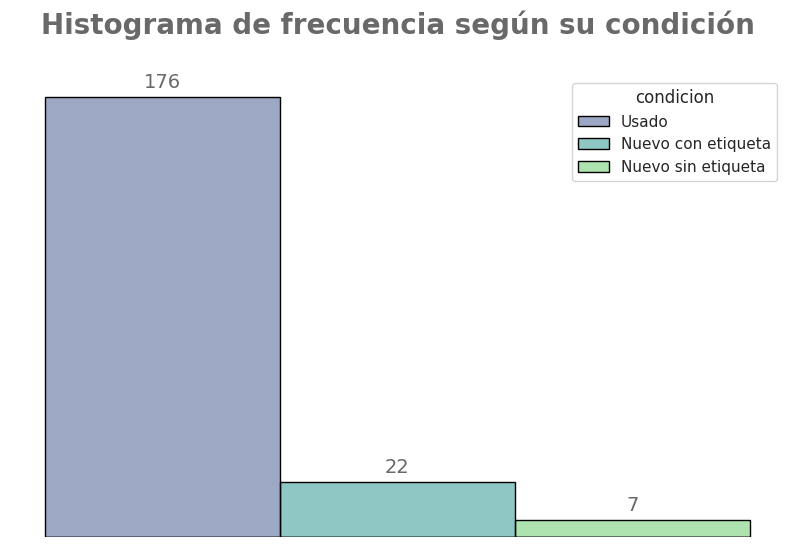

In [183]:
# Histograma de frecuencia vs condición:
plt.subplots(figsize=(10, 6), facecolor='none')
ax = sns.histplot(data=df_productos, x='condicion', stat='count', discrete=True, palette='viridis', edgecolor='black',hue='condicion')
plt.title('Histograma de frecuencia según su condición',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.xticks([])
plt.grid(None)
plt.box(None)

# Eliminar el número 0 al final de cada barra
for p in ax.patches:
    if p.get_height() != 0:  # Solo agrega el texto si la altura de la barra es diferente de cero
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., 3 + p.get_height()),
                    ha='center', va='center', fontsize=14, color='dimgray', xytext=(0, 5),
                    textcoords='offset points')

plt.show()


In [258]:
176+22+7

205

In [39]:
df_itens_pedidos.describe()

id_recibo    producto_id      pedido_id      cantidad  \
count  24527.000000   24527.000000   24527.000000  24527.000000   
mean   12405.414278   44627.641171   69931.383088      3.497126   
std     7242.697484   29347.824879   40560.769565      1.706170   
min        1.000000    2706.000000       1.000000      1.000000   
25%     6132.500000   17258.000000   34487.000000      2.000000   
50%    12264.000000   42913.000000   69945.000000      4.000000   
75%    18689.500000   70673.000000  105355.000000      5.000000   
max    25055.000000  100983.000000  139993.000000      6.000000   

       valor_unitario   valor_total   costo_envio  
count     24527.00000  24527.000000  24527.000000  
mean        535.68867   1867.490113    373.498023  
std         839.21405   3379.681887    675.936377  
min          45.00000     45.000000      9.000000  
25%         210.00000    520.000000    104.000000  
50%         336.00000   1050.000000    210.000000  
75%         450.00000   1920.000000    384.000000  
max        6500.00000  39000.000000   7800.000000

In [40]:
df_itens_pedidos.sample(5)

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
20916      21309       100961      47127         4             480   
20750      21103        40508      47457         4             245   
16059      16354        24159      20470         2             270   
21933      22380        56571      53676         2             420   
4350        4351        14836     103614         2            1100   

       valor_total ciudad  costo_envio  
20916         1920  BR-DF        384.0  
20750          980  BR-RS        196.0  
16059          540  BR-RO        108.0  
21933          840  BR-PI        168.0  
4350          2200  BR-GO        440.0

In [41]:
df_itens_pedidos_sorted=df_itens_pedidos.sort_values(by='valor_total',ascending=False)
df_itens_pedidos_sorted[df_itens_pedidos_sorted.valor_total>38000]

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
1275        1276         3865      89739         6            6500   
2951        2952         3865      48161         6            6500   
23317      23812         3865     126192         6            6500   
10659      10660         3865     132843         6            6500   
1387        1388         3865      25055         6            6500   
22778      23273         3865      68412         6            6500   
21546      21984         3865      84524         6            6500   
8405        8406         3865     119135         6            6500   
19945      20240         3865      37549         6            6500   
20646      20959         3865      95881         6            6500   
16432      16727         3865       9040         6            6500   
12681      12682         3865      23859         6            6500   
8095        8096         3865      58750         6            6500   
3489        3490         3865     119168         6            6500   
12463      12464         3865      10240         6            6500   
11336      11337         3865      51855         6            6500   
7757        7758         3865     104844         6            6500   
15687      15975         3865      40446         6            6500   
5890        5891         3865     118905         6            6500   

       valor_total ciudad  costo_envio  
1275         39000  BR-SP       7800.0  
2951         39000  BR-PR       7800.0  
23317        39000  BR-DF       7800.0  
10659        39000  BR-PI       7800.0  
1387         39000  BR-RR       7800.0  
22778        39000  BR-PE       7800.0  
21546        39000  BR-SE       7800.0  
8405         39000  BR-CE       7800.0  
19945        39000  BR-AP       7800.0  
20646        39000  BR-RO       7800.0  
16432        39000  BR-AL       7800.0  
12681        39000  BR-MA       7800.0  
8095         39000  BR-MG       7800.0  
3489         39000  BR-MT       7800.0  
12463        39000  BR-CE       7800.0  
11336        39000  BR-PB       7800.0  
7757         39000  BR-CE       7800.0  
15687        39000  BR-PI       7800.0  
5890         39000  BR-SP       7800.0

In [42]:
# Unir df_itens_pedidos con df_pedidos
df_merged = pd.merge(df_itens_pedidos, df_productos, on='producto_id', how='inner')
df_merged


id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
0              1        41518        341         3             260   
1            489        41518      15598         3             260   
2            734        41518      28333         2             260   
3            792        41518      64689         5             260   
4            932        41518      10711         5             260   
...          ...          ...        ...       ...             ...   
24522      24048        29301     133955         6             180   
24523      24091        29301      22125         1             180   
24524      24310        29301      19830         5             180   
24525      24470        29301     114271         6             180   
24526      24916        29301     119367         2             180   

       valor_total ciudad  costo_envio            producto  precio  \
0              780  BR-BA        156.0  Calca Jeans Basica   260.0   
1              780  BR-AP        156.0  Calca Jeans Basica   260.0   
2              520  BR-MG        104.0  Calca Jeans Basica   260.0   
3             1300  BR-DF        260.0  Calca Jeans Basica   260.0   
4             1300  BR-SC        260.0  Calca Jeans Basica   260.0   
...            ...    ...          ...                 ...     ...   
24522         1080  BR-SC        216.0     Blusa Renda Off   180.0   
24523          180  BR-RR         36.0     Blusa Renda Off   180.0   
24524          900  BR-SE        180.0     Blusa Renda Off   180.0   
24525         1080  BR-BA        216.0     Blusa Renda Off   180.0   
24526          360  BR-RN         72.0     Blusa Renda Off   180.0   

                 marca       sku           condicion  
0      Banana Republic  255410.0  Nuevo con etiqueta  
1      Banana Republic  255410.0  Nuevo con etiqueta  
2      Banana Republic  255410.0  Nuevo con etiqueta  
3      Banana Republic  255410.0  Nuevo con etiqueta  
4      Banana Republic  255410.0  Nuevo con etiqueta  
...                ...       ...                 ...  
24522   Espaço Fashion  307359.0               Usado  
24523   Espaço Fashion  307359.0               Usado  
24524   Espaço Fashion  307359.0               Usado  
24525   Espaço Fashion  307359.0               Usado  
24526   Espaço Fashion  307359.0               Usado  

[24527 rows x 13 columns]

In [43]:
df_merged_sorted=df_merged.sort_values(by='valor_total',ascending=False)
df_merged_sorted[df_merged_sorted.valor_unitario>6200]
# df_merged_sorted[df_merged_sorted.valor_total>38000]

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
23708      23273         3865      68412         6            6500   
23665      15975         3865      40446         6            6500   
23594       1276         3865      89739         6            6500   
23607       2952         3865      48161         6            6500   
23608       3490         3865     119168         6            6500   
...          ...          ...        ...       ...             ...   
23700      22284         3865     132207         1            6500   
23694      21876         3865       4952         1            6500   
23602       1914         3865      74051         1            6500   
23660      13795         3865      32804         1            6500   
23659      13507         3865      84761         1            6500   

       valor_total ciudad  costo_envio             producto  precio  \
23708        39000  BR-PE       7800.0  Bolsa Classica Roxa  6500.0   
23665        39000  BR-PI       7800.0  Bolsa Classica Roxa  6500.0   
23594        39000  BR-SP       7800.0  Bolsa Classica Roxa  6500.0   
23607        39000  BR-PR       7800.0  Bolsa Classica Roxa  6500.0   
23608        39000  BR-MT       7800.0  Bolsa Classica Roxa  6500.0   
...            ...    ...          ...                  ...     ...   
23700         6500  BR-PA       1300.0  Bolsa Classica Roxa  6500.0   
23694         6500  BR-SP       1300.0  Bolsa Classica Roxa  6500.0   
23602         6500  BR-AM       1300.0  Bolsa Classica Roxa  6500.0   
23660         6500  BR-AL       1300.0  Bolsa Classica Roxa  6500.0   
23659         6500  BR-DF       1300.0  Bolsa Classica Roxa  6500.0   

                marca       sku condicion  
23708  Christian Dior  165834.0     Usado  
23665  Christian Dior  165834.0     Usado  
23594  Christian Dior  165834.0     Usado  
23607  Christian Dior  165834.0     Usado  
23608  Christian Dior  165834.0     Usado  
...               ...       ...       ...  
23700  Christian Dior  165834.0     Usado  
23694  Christian Dior  165834.0     Usado  
23602  Christian Dior  165834.0     Usado  
23660  Christian Dior  165834.0     Usado  
23659  Christian Dior  165834.0     Usado  

[126 rows x 13 columns]

In [44]:
df_merged_sorted_count=df_merged.sort_values(by='cantidad',ascending=False)
df_merged_sorted_count['ganancia_neta']=(df_merged_sorted_count['valor_total']-df_merged_sorted_count['costo_envio']).astype(int)
df_merged_sorted_count

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
19297      21001        97039     128307         6             320   
15687       5050        73038     130584         6              90   
5008       19099        83795     113150         6             310   
15746      16210        73038      70909         6              90   
20823      19858        88368      61653         6             250   
...          ...          ...        ...       ...             ...   
7252        4799        80644     109844         1             990   
7253        4979        80644      75915         1             990   
19097       6134        12812       2619         1             320   
19095       5738        12812      27007         1             320   
19281      18214        97039      57540         1             320   

       valor_total ciudad  costo_envio               producto  precio  \
19297         1920  BR-DF        384.0      Calca Jeans Ilhos   320.0   
15687          540  BR-ES        108.0    Blusa Veludo Flores    90.0   
5008          1860  BR-MA        372.0  Vestido Estampa Color   310.0   
15746          540  BR-PE        108.0    Blusa Veludo Flores    90.0   
20823         1500  BR-MT        300.0       Blusa Malha Azul   250.0   
...            ...    ...          ...                    ...     ...   
7252           990  BR-PR        198.0       Bolsa Azul Candy   990.0   
7253           990  BR-AP        198.0       Bolsa Azul Candy   990.0   
19097          320  BR-AC         64.0   Sandalia Nude Vazado   320.0   
19095          320  BR-SE         64.0   Sandalia Nude Vazado   320.0   
19281          320  BR-PE         64.0      Calca Jeans Ilhos   320.0   

                     marca       sku condicion  ganancia_neta  
19297               Colcci  947042.0     Usado           1536  
15687       Isa Kulikovski  248238.0     Usado            432  
5008                Cantão  309928.0     Usado           1488  
15746       Isa Kulikovski  248238.0     Usado            432  
20823             Talie Nk  254726.0     Usado           1200  
...                    ...       ...       ...            ...  
7252   Lauren Ralph Lauren  289991.0     Usado            792  
7253   Lauren Ralph Lauren  289991.0     Usado            792  
19097               Schutz  522917.0     Usado            256  
19095               Schutz  522917.0     Usado            256  
19281               Colcci  947042.0     Usado            256  

[24527 rows x 14 columns]

###Top 10 marca:

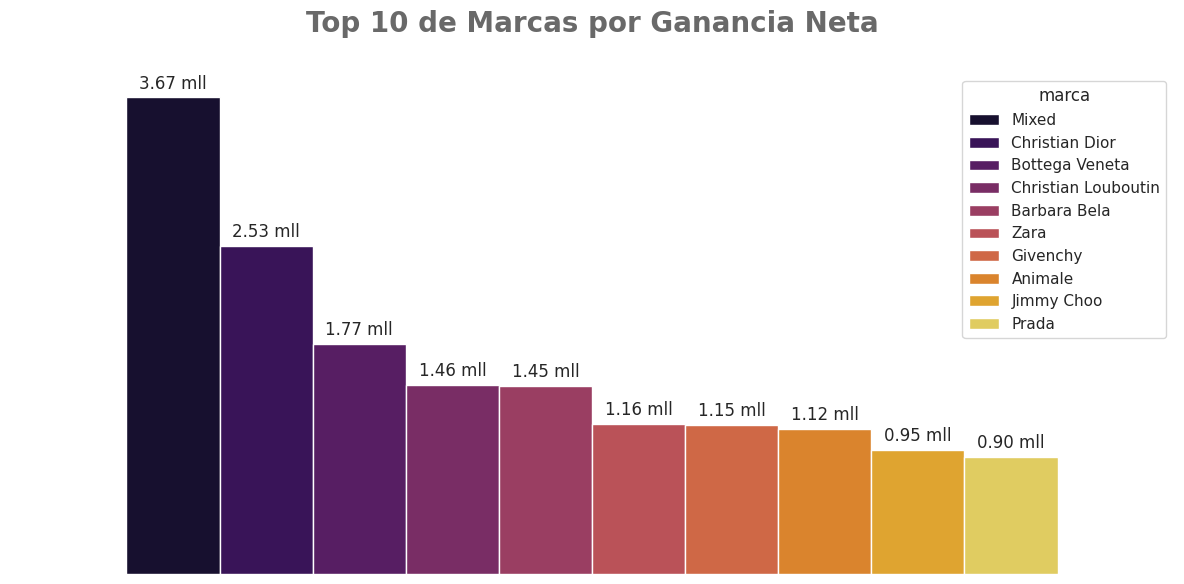

In [190]:
df=df_merged_sorted_count.copy()
top_10_marcas = df.groupby('marca')['ganancia_neta'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(hue=top_10_marcas.index, y=top_10_marcas.values,palette='inferno')

for p in ax.patches:
    if p.get_height() !=0:
      ax.annotate(f'{p.get_height()/1e6:.2f} mll',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title('Top 10 de Marcas por Ganancia Neta',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.show()

###Top 10 productos:

In [262]:
df=df_merged_sorted_count.copy()

top_10_producto_con_marca = df.groupby(['marca','producto'])['ganancia_neta'].sum().nlargest(10)

df_ver=pd.DataFrame(top_10_producto_con_marca)
df_ver.reset_index(drop=False,inplace=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=df_ver['producto'], y=df_ver['ganancia_neta'],palette='viridis',legend=True)

# Agregar etiquetas con el nombre de la marca al inicio de cada barra
for index, row in df_ver.iterrows():
    ax.text(row.name, row['ganancia_neta']-5e4, row['marca'],
            color='white', ha="center", va='top', rotation=90,fontsize=13,fontweight='bold')

# Agregar valores al final de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()/1e6:.2f} mll',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',fontsize=12)

plt.title('Top 10 de producto por Ganancia Neta',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.yticks([])
# plt.tight_layout()
plt.box(None)
plt.show()

<ipython-input-262-268586fa2c0a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_ver['producto'], y=df_ver['ganancia_neta'],palette='viridis',legend=True)


In [47]:
# Agrupar por producto y encontrar el precio máximo
productos_mayor_precio = df_productos.groupby('producto')['precio'].max()

df_productos_mayor_precio=pd.DataFrame(productos_mayor_precio)
df_productos_mayor_precio.reset_index(inplace=True)
df_productos_mayor_precio.sort_values(by='precio',ascending=False).head(10)

producto  precio
40          Bolsa Classica Roxa  6500.0
42   Bolsa Intrecciato Caramelo  6175.0
178         Vestido Longo Preto  4200.0
41             Bolsa Coral Saco  4000.0
142           Sapato Cetim Pink  3900.0
120           Saia Couro Tijolo  3800.0
154      Sneaker Monograma Bege  2630.0
108       Oculos Redondo Purple  2600.0
144        Scarpin Bege Textura  2590.0
94          Clutch Preta Pregas  1600.0

In [48]:
df_itens_pedidos.describe()

id_recibo    producto_id      pedido_id      cantidad  \
count  24527.000000   24527.000000   24527.000000  24527.000000   
mean   12405.414278   44627.641171   69931.383088      3.497126   
std     7242.697484   29347.824879   40560.769565      1.706170   
min        1.000000    2706.000000       1.000000      1.000000   
25%     6132.500000   17258.000000   34487.000000      2.000000   
50%    12264.000000   42913.000000   69945.000000      4.000000   
75%    18689.500000   70673.000000  105355.000000      5.000000   
max    25055.000000  100983.000000  139993.000000      6.000000   

       valor_unitario   valor_total   costo_envio  
count     24527.00000  24527.000000  24527.000000  
mean        535.68867   1867.490113    373.498023  
std         839.21405   3379.681887    675.936377  
min          45.00000     45.000000      9.000000  
25%         210.00000    520.000000    104.000000  
50%         336.00000   1050.000000    210.000000  
75%         450.00000   1920.000000    384.000000  
max        6500.00000  39000.000000   7800.000000

In [49]:
df_itens_pedidos.sample(5)

id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
3702        3703        86302     109505         3             139   
5090        5091        57815      20455         5             100   
1820        1821         5995      23450         1             398   
22597      23092        66539      97417         6             399   
13334      13335        13906      83437         3             340   

       valor_total ciudad  costo_envio  
3702           417  BR-RS         83.4  
5090           500  BR-RO        100.0  
1820           398  BR-PA         79.6  
22597         2394  BR-RO        478.8  
13334         1020  BR-AM        204.0

In [50]:
df_itens_pedidos['ganancia_neta']=(df_itens_pedidos['valor_total']-df_itens_pedidos['costo_envio']).astype(int)
df_itens_pedidos


id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
0              1        41518        341         3             260   
1              2         4307       1174         5            6175   
2              3        22407       1399         3             200   
3              4         3820       1652         6             139   
4              5        29012       2470         3             525   
...          ...          ...        ...       ...             ...   
24522      25051        64127      63716         4             590   
24523      25052        37384      63999         4             700   
24524      25053       100932      64594         5            3900   
24525      25054         3820      64811         3             139   
24526      25055        74864      65274         2             130   

       valor_total ciudad  costo_envio  ganancia_neta  
0              780  BR-BA        156.0            624  
1            30875  BR-RJ       6175.0          24700  
2              600  BR-PB        120.0            480  
3              834  BR-DF        166.8            667  
4             1575  BR-BA        315.0           1260  
...            ...    ...          ...            ...  
24522         2360  BR-PE        472.0           1888  
24523         2800  BR-RO        560.0           2240  
24524        19500  BR-RO       3900.0          15600  
24525          417  BR-MA         83.4            333  
24526          260  BR-SE         52.0            208  

[24527 rows x 9 columns]

In [205]:
Boxplot_Histograma_graf(df_itens_pedidos,'ganancia_neta')

In [206]:
df=df_itens_pedidos.copy()
top_ciudad = df.groupby('ciudad')['ganancia_neta'].sum()
# top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(50)
df_ciudades_ganancias_netas=pd.DataFrame(top_ciudad)
df_ciudades_ganancias_netas.reset_index(inplace=True)
df_ciudades_ganancias_netas['cod_ciudad_brasil']= [ciudad.replace('BR-', '') for ciudad in df_ciudades_ganancias_netas.ciudad]
df_ciudades_ganancias_netas.drop(columns='ciudad',axis=1,inplace=True)
df_ciudades_ganancias_netas

ganancia_neta cod_ciudad_brasil
0         1128495                AC
1         1521989                AL
2         1244061                AM
3         1475708                AP
4         1322488                BA
5         1468041                CE
6         1327068                DF
7         1275849                ES
8         1418180                GO
9         1453022                MA
10        1314754                MG
11        1221151                MS
12        1363581                MT
13        1345172                PA
14        1423807                PB
15        1509172                PE
16        1358574                PI
17        1308078                PR
18        1334368                RJ
19        1335546                RN
20        1317470                RO
21        1349741                RR
22        1320498                RS
23        1476940                SC
24        1339264                SE
25        1404384                SP
26        1284950                TO

In [207]:
# Diccionario de correspondencias entre siglas y nombres de ciudades
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

# Reemplazar las siglas por los nombres de las ciudades en el dataframe
df_ciudades_ganancias_netas['ciudad'] = df_ciudades_ganancias_netas['cod_ciudad_brasil'].map(ciudades)
df_ciudades_ganancias_netas=df_ciudades_ganancias_netas[['cod_ciudad_brasil','ciudad','ganancia_neta']]
df_ciudades_ganancias_netas

cod_ciudad_brasil                ciudad  ganancia_neta
0                 AC                  Acre        1128495
1                 AL               Alagoas        1521989
2                 AM              Amazonas        1244061
3                 AP                 Amapá        1475708
4                 BA                 Bahía        1322488
5                 CE                 Ceará        1468041
6                 DF      Distrito Federal        1327068
7                 ES        Espírito Santo        1275849
8                 GO                 Goiás        1418180
9                 MA              Maranhão        1453022
10                MG          Minas Gerais        1314754
11                MS    Mato Grosso do Sul        1221151
12                MT           Mato Grosso        1363581
13                PA                  Pará        1345172
14                PB               Paraíba        1423807
15                PE            Pernambuco        1509172
16                PI                 Piauí        1358574
17                PR                Paraná        1308078
18                RJ        Río de Janeiro        1334368
19                RN  Río Grande del Norte        1335546
20                RO              Rondônia        1317470
21                RR               Roraima        1349741
22                RS    Río Grande del Sur        1320498
23                SC        Santa Catarina        1476940
24                SE               Sergipe        1339264
25                SP             São Paulo        1404384
26                TO             Tocantins        1284950

In [208]:
import geopandas as gpd
import geobr
df=df_ciudades_ganancias_netas

br_uf = geobr.read_state()
br_uf = br_uf.rename(columns={'abbrev_state': 'cod_ciudad_brasil'})
br_uf_d = br_uf.merge(df, on='cod_ciudad_brasil')
br_uf_d = br_uf_d[['geometry','cod_ciudad_brasil', 'ganancia_neta']]
br_uf_d.head()

geometry cod_ciudad_brasil  \
0  MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...                RO   
1  MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...                AC   
2  MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...                AM   
3  MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...                RR   
4  MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...                PA   

   ganancia_neta  
0        1317470  
1        1128495  
2        1244061  
3        1349741  
4        1345172

<ipython-input-209-f5e7100c58fb>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.cod_ciudad_brasil):
<ipython-input-209-f5e7100c58fb>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.cod_ciudad_brasil):


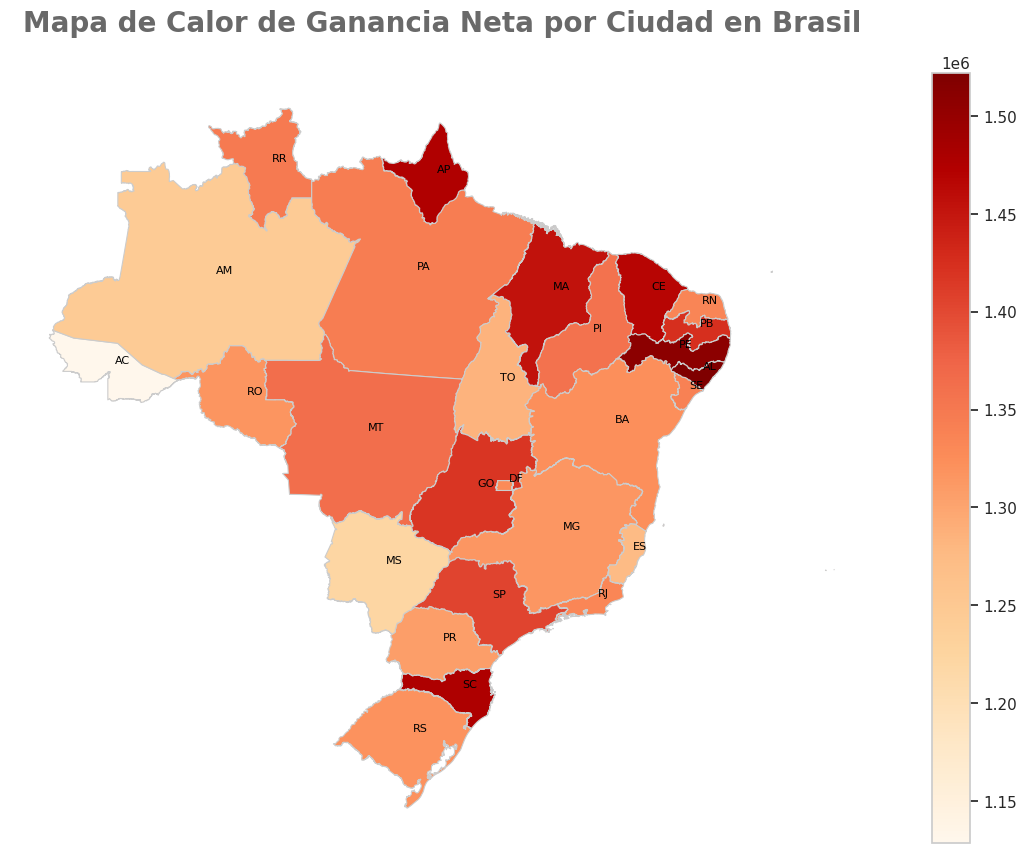

In [209]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Crear el mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
br_uf_d.plot(column='ganancia_neta', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.cod_ciudad_brasil):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='black')

plt.title('Mapa de Calor de Ganancia Neta por Ciudad en Brasil',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.axis('off')
plt.show()

In [213]:
# Diccionario de correspondencias entre siglas y nombres de ciudades
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

# Reemplazar las siglas por los nombres de las ciudades en el dataframe
br_uf_d['ciudad'] = br_uf_d['cod_ciudad_brasil'].map(ciudades)

# Crear el mapa de calor con los nombres de las ciudades
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
br_uf_d.plot(column='ganancia_neta', cmap='summer', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# br_uf_d.plot(column='ganancia_neta', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.ciudad):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='black')

plt.title('Mapa de Calor de Ganancia Neta por Ciudad en Brasil',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.axis('off')
plt.show()

<ipython-input-213-78547cb9c1ed>:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.ciudad):
<ipython-input-213-78547cb9c1ed>:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.ciudad):


In [212]:
# Convertir la geometría a un CRS proyectado
br_uf_d_projected = br_uf_d.to_crs('EPSG:3857')

# Crear el mapa de calor con los nombres de las ciudades
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
br_uf_d_projected.plot(column='ganancia_neta', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d_projected.geometry.centroid.x, br_uf_d_projected.geometry.centroid.y, br_uf_d_projected.ciudad):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='black')

plt.title('Mapa de Calor de Ganancia Neta por Ciudad en Brasil', fontsize=20, color='dimgray', fontweight='bold', pad=30)
plt.axis('off')
plt.show()

In [57]:
df=df_itens_pedidos.copy()
top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(10)
df_top_10_ciudad=pd.DataFrame(top_10_ciudad)
df_top_10_ciudad.reset_index(drop=False,inplace=True)
df_top_10_ciudad['cod_ciudad_brasil']=[ciudad.replace('BR-', '') for ciudad in df_top_10_ciudad.ciudad]
df_top_10_ciudad['ciudad'] = df_top_10_ciudad['cod_ciudad_brasil'].map(ciudades)
df_top_10_ciudad


ciudad  ganancia_neta cod_ciudad_brasil
0         Alagoas        1521989                AL
1      Pernambuco        1509172                PE
2  Santa Catarina        1476940                SC
3           Amapá        1475708                AP
4           Ceará        1468041                CE
5        Maranhão        1453022                MA
6         Paraíba        1423807                PB
7           Goiás        1418180                GO
8       São Paulo        1404384                SP
9     Mato Grosso        1363581                MT

<ipython-input-265-cc9972315a16>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_top_10_ciudad.ciudad, y=df_top_10_ciudad.ganancia_neta,palette='inferno')


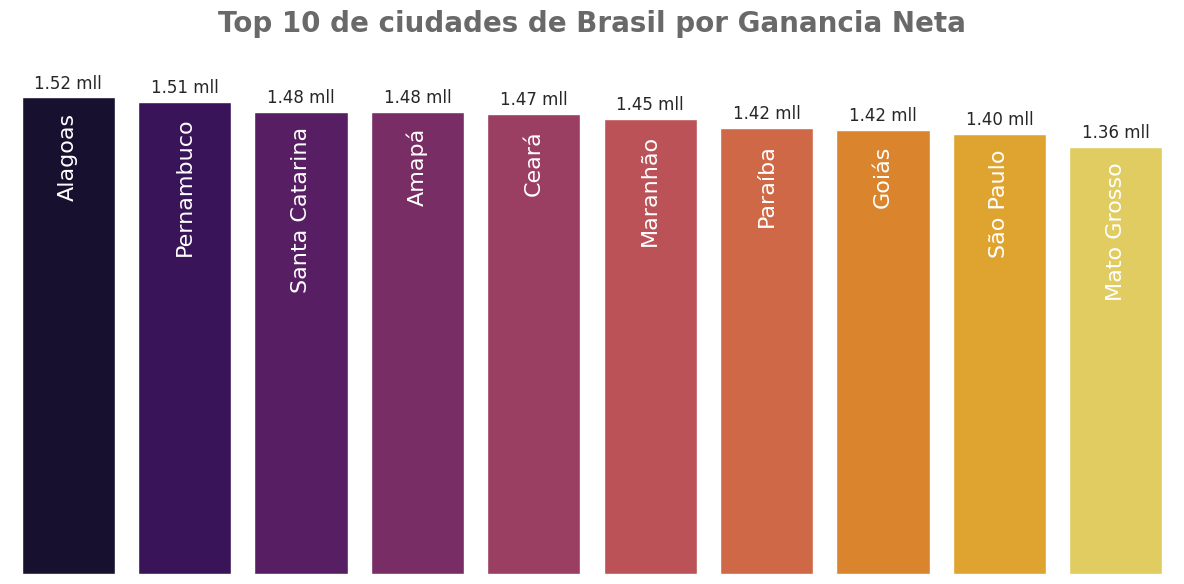

In [265]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=df_top_10_ciudad.ciudad, y=df_top_10_ciudad.ganancia_neta,palette='inferno')

for p in ax.patches:
    ax.annotate(f'{p.get_height()/1e6:.2f} mll',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

for index, row in df_top_10_ciudad.iterrows():
    ax.text(row.name, row['ganancia_neta']-.5e5, row['ciudad'],
            color='white', ha="center", va='top', rotation=90,fontsize=16)

plt.title('Top 10 de ciudades de Brasil por Ganancia Neta',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.show()

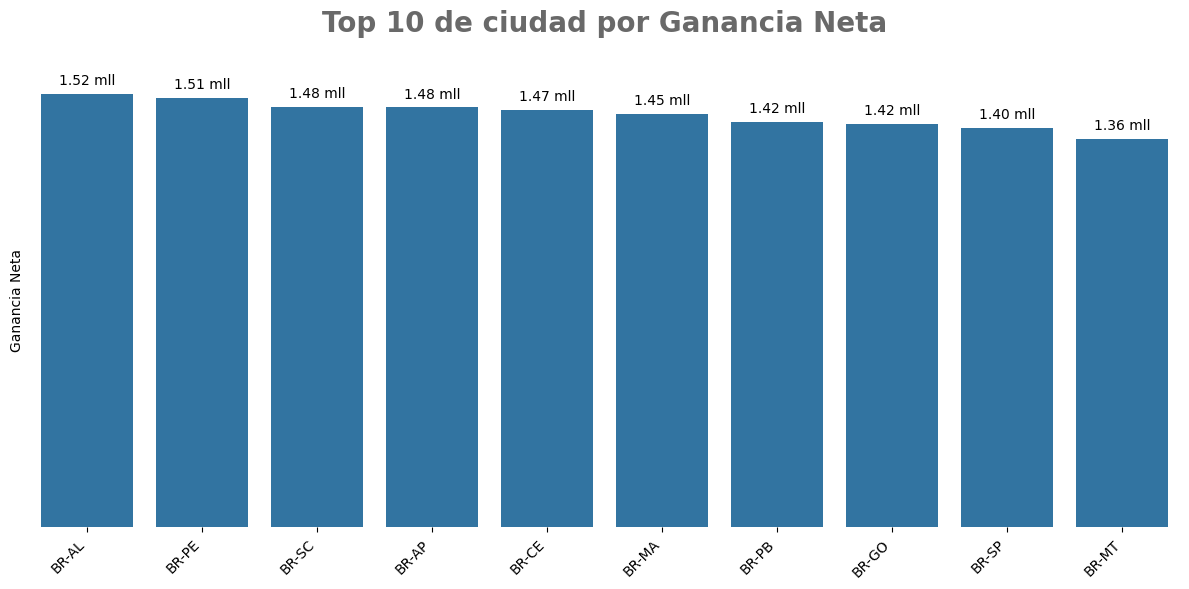

In [59]:
df=df_itens_pedidos.copy()
top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_10_ciudad.index, y=top_10_ciudad.values)

for p in ax.patches:
    ax.annotate(f'{p.get_height()/1e6:.2f} mll',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# for index, row in df_ver.iterrows():
#     ax.text(row.name, row['ganancia_neta']-.5e5, row['marca'],
#             color='white', ha="center", va='top', rotation=90)

plt.title('Top 10 de ciudad por Ganancia Neta',fontsize=20, color='dimgray', fontweight='bold',pad=30)
plt.xlabel('')
plt.ylabel('Ganancia Neta')
plt.xticks(rotation=45, ha='right')
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.show()

#**3. Preguntas y respuestas**


---




##**3.1 Creando el banco de datos**

In [60]:
#@title
def crear_conexion():
    global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database
    # Crea el engine de SQLite
    # database = 'mi_base_de_datos.db'
    database = create_engine(f'sqlite:///:memory', echo=False)

    # Adiciona los dataframes a las tablas SQL
    df_itens_pedidos.to_sql('itens_pedidos', database, if_exists='replace', index=False)
    df_pedidos.to_sql('pedidos', database, if_exists='replace', index=False)
    df_productos.to_sql('productos', database, if_exists='replace', index=False)
    df_vendedores.to_sql('vendedores', database, if_exists='replace', index=False)

    print("¡Conexión creada y datos guardados en la base de datos!")

# Llama a la función para crear la conexión y guardar los datos
crear_conexion()

¡Conexión creada y datos guardados en la base de datos!


In [61]:
from sqlalchemy import inspect
# engine = create_engine(f'sqlite:///{database}', echo=False)

# Crear el objeto Inspector
inspector = inspect(database)

# Imprimir las tablas en la base de datos
print('Tablas: ', inspector.get_table_names(), '\n')

# Imprimir las columnas de la tabla "pedidos"
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column['name'])


Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
pedido_id
producto_id
vendedor_id
fecha_compra
total


In [62]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
print('----------------------------------------------')
for column in inspector.get_columns('itens_pedidos'):
    print('Columnas de Tabla itens_pedidos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('pedidos'):
    print('Columnas de Tabla Pedidos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('productos'):
    print('Columnas de Tabla productos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('vendedores'):
    print('Columnas de Tabla vendedores:')
    print(column)
database.dispose()

¡Conexión creada y datos guardados en la base de datos!
Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
----------------------------------------------
Columnas de Tabla itens_pedidos:
{'name': 'id_recibo', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'cantidad', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'valor_unitario', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'valor_total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name

In [63]:
Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores']
query='''
SELECT * FROM itens_pedidos
'''
df_query = pd.read_sql_query(query, database)
df_query.columns

Index(['id_recibo', 'producto_id', 'pedido_id', 'cantidad', 'valor_unitario',
       'valor_total', 'ciudad', 'costo_envio', 'ganancia_neta'],
      dtype='object')

##**Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

In [64]:
query_1 = """
SELECT
    productos.producto_id,
    productos.producto,
    productos.marca,
    productos.precio * SUM(itens_pedidos.cantidad) AS total_vendido,
    SUM(itens_pedidos.cantidad) AS cantidad_vendida
FROM
    productos
JOIN
    itens_pedidos ON productos.producto_id = itens_pedidos.producto_id
GROUP BY
    productos.producto_id
ORDER BY
    cantidad_vendida DESC
LIMIT 5;
"""

df_query_1 = pd.read_sql_query(query_1, database)
database.dispose()
df_query_1['total_vendido_K']=(df_query_1['total_vendido']/1000).astype(int)
df_query_1

producto_id             producto                marca  total_vendido  \
0        32126      Saia Midi Cinto  Limone By Jade Seba       115290.0   
1        13814    Vestido Nude Reta                Ellus       300850.0   
2        47405  Blusa Manga Estampa              Animale       166160.0   
3        33976   Camisa Xadrez Azul            Hollister        61320.0   
4        53941  Cropped Escritas Pb      Linda de Morrer       142240.0   

   cantidad_vendida  total_vendido_K  
0               549              115  
1               547              300  
2               536              166  
3               511               61  
4               508              142

In [65]:
df_query_1.producto.unique()

array(['Saia Midi Cinto', 'Vestido Nude Reta', 'Blusa Manga Estampa',
       'Camisa Xadrez Azul', 'Cropped Escritas Pb'], dtype=object)

In [216]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import FancyBboxPatch

df=df_query_1.copy()

sns.set(style="whitegrid")
sns.set_palette("Blues_r")

plt.subplots(figsize=(10, 6),facecolor='none')
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df, errorbar=None, hue='producto',palette='Blues_r')

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width()-10, p.get_y() + p.get_height() / 2), ha='right', va='center', xytext=(1, 0), textcoords='offset points',color='white',fontweight='bold',fontsize=18)

for index, value in enumerate(df['total_vendido_K']):
    ax.text(100, index, f'${value}K', va='center', ha='right', color='white',fontweight='bold')

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['producto']):
    ax.text(medio, index, value, va='center', ha='center', color='white',fontweight='bold')

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['marca']):
    ax.text(medio, index+.2, value, va='center', ha='center', color='gold',fontsize=10)


plt.title('Top 5: Productos más vendidos hitóricamente', color='dimgray',fontsize=20,fontweight='bold',pad=20)

#Redondeo de barras:
new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=12",
                            ec="none", fc=color,
                            mutation_aspect=0.05
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax.add_patch(patch)


img_path_01 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/falda_midi_cinto_r.png'
img_path_02 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/Vestido_recto_nude_r.png'
img_path_03 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/blusa_mangas_estampadas_r.png'
img_path_04 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/camisa_xadrez_azul_r.png'
img_path_05 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/cropped_escritas_r.png'
img_list=[img_path_05,img_path_04,img_path_03,img_path_02,img_path_01]
#Colocar img:
for i, patch in enumerate(ax.patches):
    img = OffsetImage(plt.imread(img_list[i]), zoom=.6)
    ab = AnnotationBbox(img, (patch.get_x()+10, patch.get_y()+.01 + patch.get_height() / 2), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
    ax.add_artist(ab)

sns.despine(left=True, bottom=True)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.box(None)
plt.show()

##**1.2 Visualización:**

##**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [67]:
query_2='''
SELECT
    pedidos.fecha_compra,
    SUM(pedidos.total - itens_pedidos.costo_envio) AS total_ventas
FROM
    pedidos
JOIN
    itens_pedidos itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
GROUP BY
    pedidos.fecha_compra;
'''
df_query_2 = pd.read_sql_query(query_2, database)
database.dispose()
df_query_2.head()

fecha_compra  total_ventas
0  2019-01-05 00:00:00.000000       32460.8
1  2019-01-06 00:00:00.000000        1728.0
2  2019-01-07 00:00:00.000000        1560.0
3  2019-01-08 00:00:00.000000        1024.0
4  2019-01-09 00:00:00.000000         400.0

In [68]:
query_2_1='''
SELECT
    pedidos.*,
    itens_pedidos.*,
    productos.*,
    SUM(pedidos.total - itens_pedidos.costo_envio) AS total_ventas
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    pedidos.fecha_compra;
'''
df_query_2_1 = pd.read_sql_query(query_2_1, database)
database.dispose()
df_query_2_1

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
0          341        41518            6  2019-01-05 00:00:00.000000    780   
1         3687       100961            3  2019-01-06 00:00:00.000000    960   
2         3870        59337            3  2019-01-07 00:00:00.000000   1950   
3         4004        79079            5  2019-01-08 00:00:00.000000   1280   
4         4471        27336            2  2019-01-09 00:00:00.000000    500   
..         ...          ...          ...                         ...    ...   
775      37393        28699            4  2021-02-21 00:00:00.000000   2100   
776      55724       100961            1  2021-03-07 00:00:00.000000   1440   
777      59966        39368            1  2021-03-08 00:00:00.000000    558   
778      63716        64127            1  2021-03-09 00:00:00.000000   2360   
779      64594       100932            1  2021-03-10 00:00:00.000000  19500   

     id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
0            1        41518        341         3             260          780   
1           10       100961       3687         2             480          960   
2           12        59337       3870         5             390         1950   
3           13        79079       4004         4             320         1280   
4           14        27336       4471         2             250          500   
..         ...          ...        ...       ...             ...          ...   
775      25012        28699      37393         5             420         2100   
776      25039       100961      55724         3             480         1440   
777      25045        39368      59966         2             279          558   
778      25051        64127      63716         4             590         2360   
779      25053       100932      64594         5            3900        19500   

    ciudad  costo_envio  ganancia_neta  producto_id                producto  \
0    BR-BA        156.0            624        41518      Calca Jeans Basica   
1    BR-GO        192.0            768       100961     Vestido Preto Renda   
2    BR-CE        390.0           1560        59337     Blusa Tricot Mescla   
3    BR-RS        256.0           1024        79079     Regata Nude Textura   
4    BR-AC        100.0            400        27336    Calca Preta Resinada   
..     ...          ...            ...          ...                     ...   
775  BR-PR        420.0           1680        28699      Calca Verde Bolsos   
776  BR-MT        288.0           1152       100961     Vestido Preto Renda   
777  BR-SP        111.6            446        39368      Shorts Neoprene Pb   
778  BR-PE        472.0           1888        64127  Vestido Textura Branco   
779  BR-RO       3900.0          15600       100932       Sapato Cetim Pink   

     precio                marca       sku           condicion  total_ventas  
0     260.0      Banana Republic  255410.0  Nuevo con etiqueta       32460.8  
1     480.0             Dress&co  175945.0               Usado        1728.0  
2     390.0               Levi's  295977.0               Usado        1560.0  
3     320.0              Gregory  247347.0               Usado        1024.0  
4     250.0                Ellus  122068.0               Usado         400.0  
..      ...                  ...       ...                 ...           ...  
775   420.0          Brooksfield  947048.0               Usado       30944.8  
776   480.0             Dress&co  175945.0               Usado        4744.0  
777   279.0              Animale  305188.0               Usado       16206.4  
778   590.0              J. Crew  317928.0               Usado        4128.0  
779  3900.0  Christian Louboutin  304370.0               Usado       16141.6  

[780 rows x 21 columns]

In [69]:
query_2_11='''
SELECT
    pedidos.*,
    itens_pedidos.*,
    productos.*
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    pedidos.pedido_id;
'''
df_query_2_11 = pd.read_sql_query(query_2_11, database)
database.dispose()
df_query_2_11.drop_duplicates(inplace=True)
df_query_2_11

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
0              1         5292            2  2020-02-16 00:00:00.000000   3456   
1              3        29650            3  2020-02-01 00:00:00.000000    720   
2              9        18751            5  2021-02-04 00:00:00.000000   5940   
3             11         7871            3  2019-12-01 00:00:00.000000   2520   
4             21         2706            3  2020-01-03 00:00:00.000000   2950   
...          ...          ...          ...                         ...    ...   
24522     139961        27546            4  2020-10-25 00:00:00.000000    336   
24523     139962        20029            3  2019-11-27 00:00:00.000000   1176   
24524     139964        25562            5  2020-01-22 00:00:00.000000    640   
24525     139980        48872            4  2020-04-18 00:00:00.000000    120   
24526     139993        66539            4  2019-05-28 00:00:00.000000    798   

       id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
0          10062         5292          1         6             576   
1           9453        29650          3         6             120   
2          24512        18751          9         6             990   
3           7184         7871         11         6             420   
4           8221         2706         21         5             590   
...          ...          ...        ...       ...             ...   
24522      19768        27546     139961         1             336   
24523       6974        20029     139962         4             294   
24524       9044        25562     139964         2             320   
24525      12647        48872     139980         1             120   
24526       2007        66539     139993         2             399   

       valor_total ciudad  costo_envio  ganancia_neta  producto_id  \
0             3456  BR-PE        691.2           2764         5292   
1              720  BR-CE        144.0            576        29650   
2             5940  BR-SC       1188.0           4752        18751   
3             2520  BR-DF        504.0           2016         7871   
4             2950  BR-MT        590.0           2360         2706   
...            ...    ...          ...            ...          ...   
24522          336  BR-PI         67.2            268        27546   
24523         1176  BR-MA        235.2            940        20029   
24524          640  BR-SC        128.0            512        25562   
24525          120  BR-ES         24.0             96        48872   
24526          798  BR-RR        159.6            638        66539   

                    producto  precio             marca       sku  \
0          Saia Jeans Forest   576.0             Mixed  222683.0   
1         Vestido Estampa Pb   120.0               H&m  285576.0   
2      Vestido Couro Franjas   990.0          Spezzato  304187.0   
3        Vestido Ziper Fendi   420.0           Thelure  318544.0   
4                Blusa Cinza   590.0             Mixed  297627.0   
...                      ...     ...               ...       ...   
24522    Calca Veludo Cotele   336.0             Joe's  236203.0   
24523    Tenis Xadrez Tecido   294.0          Converse  121965.0   
24524       Calca Jeans Reta   320.0        Miss Sixty  263656.0   
24525    Choker Pedra Branca   120.0  Fabiana Caterina  274593.0   
24526  Shorts Bordado Branco   399.0          Shoulder  211444.0   

                condicion  
0      Nuevo con etiqueta  
1                   Usado  
2      Nuevo con etiqueta  
3                   Usado  
4                   Usado  
...                   ...  
24522               Usado  
24523               Usado  
24524               Usado  
24525  Nuevo con etiqueta  
24526  Nuevo con etiqueta  

[24527 rows x 20 columns]

In [70]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA-MM  ####
query_2_112='''
SELECT
    strftime('%Y-%m', pedidos.fecha_compra) AS año_mes,
    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
GROUP BY
    año_mes
ORDER BY
    año_mes;
'''
df_query_2_112 = pd.read_sql_query(query_2_112, database)
database.dispose()
df_query_2_112.drop_duplicates(inplace=True)
df_query_2_112

año_mes  cantidad_vendida  total_por_mes
0   2019-01               517         260616
1   2019-02              1181         548144
2   2019-03              1769         883559
3   2019-04              1584         904471
4   2019-05              2288        1202017
5   2019-06              1987        1112627
6   2019-07              2644        1366542
7   2019-08              2660        1444138
8   2019-09              2805        1660723
9   2019-10              2962        1613431
10  2019-11              4693        2378766
11  2019-12              3498        1912332
12  2020-01              4464        2458252
13  2020-02              4127        2168386
14  2020-03              4469        2472297
15  2020-04              4437        2189559
16  2020-05              4146        2168099
17  2020-06              3173        1577791
18  2020-07              3402        1881010
19  2020-08              4184        2268550
20  2020-09              4236        2428227
21  2020-10              4019        2079915
22  2020-11              3831        2080834
23  2020-12              6248        3454281
24  2021-01              4126        2097109
25  2021-02              2273        1140729
26  2021-03                51          51525

In [71]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA  ####

query_2_1121='''
SELECT
    strftime('%Y', pedidos.fecha_compra) AS año_mes,
    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
GROUP BY
    año_mes
ORDER BY
    año_mes;
'''
df_query_2_1121 = pd.read_sql_query(query_2_1121, database)
database.dispose()
df_query_2_1121.drop_duplicates(inplace=True)
df_query_2_1121

año_mes  cantidad_vendida  total_por_mes
0    2019             28588       15287366
1    2020             50736       27227201
2    2021              6450        3289363

In [72]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA-MM   ####

query_2_1122='''
SELECT
    strftime('%Y-%m', pedidos.fecha_compra) AS year_mount,
    CASE
        WHEN productos.condicion = 'Nuevo con etiqueta' THEN 'Nuevo'
        WHEN productos.condicion = 'Nuevo sin etiqueta' THEN 'NuevoSE'
        ELSE productos.condicion
    END AS condicion,    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    year_mount, productos.condicion
ORDER BY
    year_mount, productos.condicion;

'''
df_query_2_1122 = pd.read_sql_query(query_2_1122, database)
database.dispose()
df_query_2_1122.drop_duplicates(inplace=True)
df_query_2_1122

year_mount condicion  cantidad_vendida  total_por_mes
0     2019-01     Nuevo                50          19541
1     2019-01   NuevoSE                23          13610
2     2019-01     Usado               444         227465
3     2019-02     Nuevo                81          47489
4     2019-02   NuevoSE                44          17860
..        ...       ...               ...            ...
75    2021-02     Nuevo               268         133751
76    2021-02   NuevoSE                73          35889
77    2021-02     Usado              1932         971089
78    2021-03   NuevoSE                 5           2250
79    2021-03     Usado                46          49275

[80 rows x 4 columns]

In [73]:
# Seleccionar las fechas menores a 2021
df_query_2_1122['year_mount'] = pd.to_datetime(df_query_2_1122['year_mount'])
fechas_menores_2021 = df_query_2_1122[df_query_2_1122['year_mount'] < '2021']
fechas_menores_2021 = fechas_menores_2021.copy()
fechas_menores_2021['year_mount'] = fechas_menores_2021['year_mount'].dt.strftime('%Y-%m')
fechas_menores_2021

year_mount condicion  cantidad_vendida  total_por_mes
0     2019-01     Nuevo                50          19541
1     2019-01   NuevoSE                23          13610
2     2019-01     Usado               444         227465
3     2019-02     Nuevo                81          47489
4     2019-02   NuevoSE                44          17860
..        ...       ...               ...            ...
67    2020-11   NuevoSE               144          73452
68    2020-11     Usado              3243        1775164
69    2020-12     Nuevo               667         339266
70    2020-12   NuevoSE               259         133741
71    2020-12     Usado              5322        2981274

[72 rows x 4 columns]

In [230]:
condicion_nuevo=fechas_menores_2021[fechas_menores_2021.condicion=='Nuevo']
condicion_nuevose=fechas_menores_2021[fechas_menores_2021.condicion=='NuevoSE']
condicion_usado=fechas_menores_2021[fechas_menores_2021.condicion=='Usado']
condicion_usado

year_mount condicion  cantidad_vendida  total_por_mes
2     2019-01     Usado               444         227465
5     2019-02     Usado              1056         482795
8     2019-03     Usado              1498         752348
11    2019-04     Usado              1386         806463
14    2019-05     Usado              1975        1052001
17    2019-06     Usado              1734        1001417
20    2019-07     Usado              2257        1165675
23    2019-08     Usado              2338        1288570
26    2019-09     Usado              2503        1491139
29    2019-10     Usado              2563        1421550
32    2019-11     Usado              3901        1993873
35    2019-12     Usado              3008        1664941
38    2020-01     Usado              3751        2105618
41    2020-02     Usado              3570        1882301
44    2020-03     Usado              3745        2110607
47    2020-04     Usado              3890        1882748
50    2020-05     Usado              3564        1874924
53    2020-06     Usado              2661        1312411
56    2020-07     Usado              2880        1629763
59    2020-08     Usado              3558        1958845
62    2020-09     Usado              3690        2147220
65    2020-10     Usado              3487        1793349
68    2020-11     Usado              3243        1775164
71    2020-12     Usado              5322        2981274

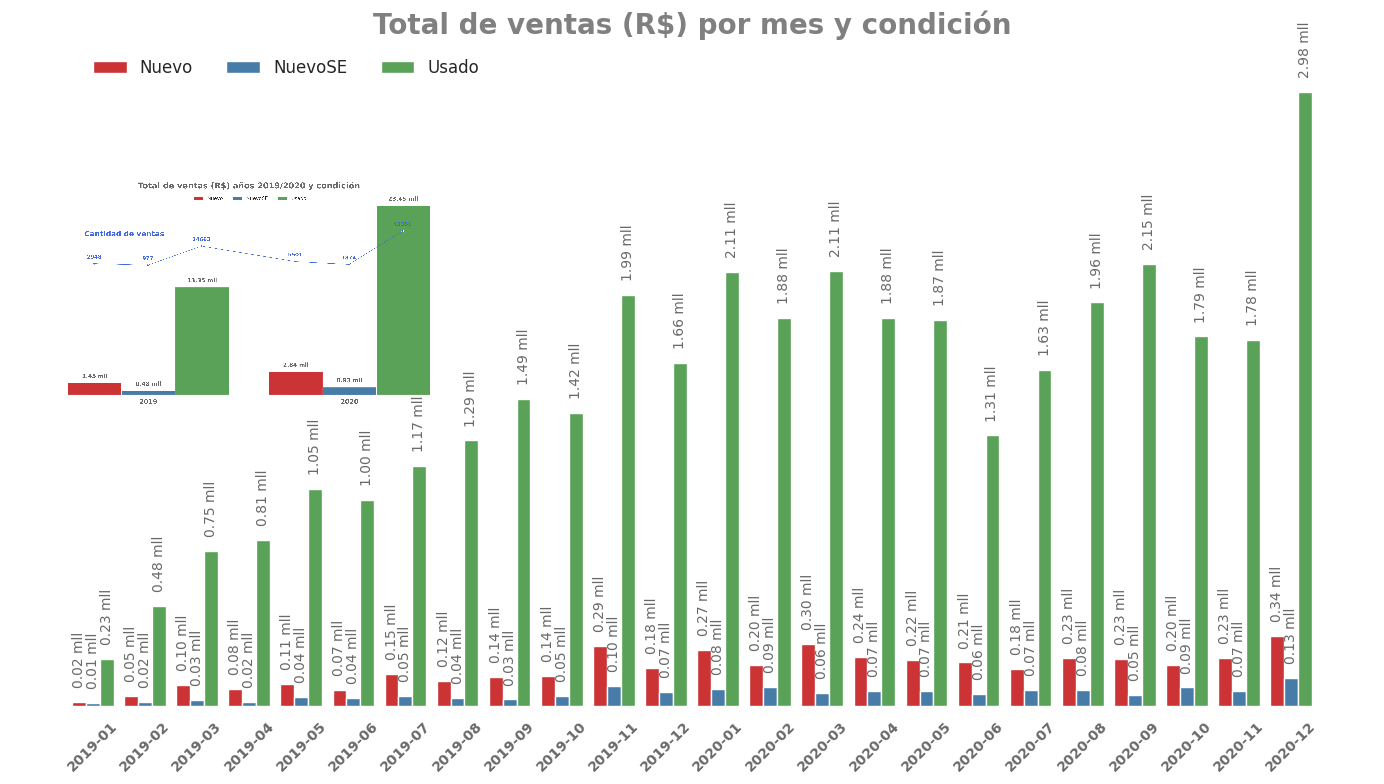

In [268]:
df=fechas_menores_2021.copy()
condicion_nuevo=fechas_menores_2021[fechas_menores_2021.condicion=='Nuevo']
condicion_nuevose=fechas_menores_2021[fechas_menores_2021.condicion=='NuevoSE']
condicion_usado=fechas_menores_2021[fechas_menores_2021.condicion=='Usado']

# df=df.año_mes.astype(str)
plt.figure(figsize=(14, 8))
ax=sns.barplot(data=df, x='year_mount', y='total_por_mes', hue='condicion',palette='Set1')
plt.title('Total de ventas (R$) por mes y condición',fontweight='bold', fontsize=20, color='gray',pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,fontweight='bold', fontsize=10,color='dimgray')
x_pos=[]

for p,amount in zip(ax.patches,df.cantidad_vendida):
    x_pos.append(p.get_x())
    ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=10,color='dimgray',rotation=90)

x_pos_order=sorted(x_pos)
x_values = []
y_values = []
x_values1 = []
y_values1 = []

# Cantidad de ventas
# for amount, order in zip(df.cantidad_vendida, x_pos_order):
#     ax.annotate(amount, (order, amount * 100 + 2.9e6), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontweight='bold', fontsize=9, color='gray', rotation=90)
#     x_values.append(order)
#     y_values.append(amount * 100 + 2.9e6)
# print(x_values)

lista1=[]
for i in range(0, len(df)+1, 3):
    lista1.append(i)
for index, row in df.iterrows():
    # Agregar el valor de year_mount a x_values
    if index in lista1:
      x_values1.append(row['year_mount'])
      y_values1.append(row['total_por_mes'])
      # y_values1.append(row['total_por_mes'] * 100 + 2.9e6)

# Trazar las líneas de cantidad de ventas
# sns.lineplot(x=x_values, y=y_values, marker='o', markersize=5, linewidth=1, color='royalblue')
# sns.lineplot(x=x_values1, y=y_values1, marker='o', markersize=5, linewidth=1, color='royalblue')

# sns.lineplot(x=x_values, y=y_values, marker='o', markersize=5, linewidth=1, color='royalblue')
# ax.annotate('Cantidad de ventas', (1.5, 2.65e6), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points',fontweight='bold', fontsize=14,color='gray',rotation=0)
legend_x = 0.05
legend_y = 0.99
plt.legend(title='', loc='center left', bbox_to_anchor=(legend_x, legend_y), frameon=False, fontsize=12, ncol=3)

plt.plot()
plt.box(None)
plt.yticks([])
# plt.ylim(0,3e7)
plt.tight_layout()
# Añadir la imagen graf pie (% cumulado)
img='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/graf_ventas_years2019_2020_condicion.png'
img_ventas = OffsetImage(plt.imread(img), zoom=.07)  # Ajusta el zoom según sea necesario
ab_ventas = AnnotationBbox(img_ventas, (3, 2e6), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
ax.add_artist(ab_ventas)

plt.show()

In [255]:
# lista = np.arange(0, n + 1).tolist()
# lista1=[]
# for i in range(0, 100, 3):
#     lista1.append(i)


In [75]:
###  SELECCION DE CANTIDAD DE COMPRAS POR AAAA-MM   ####

query_2_1122Y='''
SELECT
    strftime('%Y', pedidos.fecha_compra) AS year,
    CASE
        WHEN productos.condicion = 'Nuevo con etiqueta' THEN 'Nuevo'
        WHEN productos.condicion = 'Nuevo sin etiqueta' THEN 'NuevoSE'
        ELSE productos.condicion
    END AS condicion,    SUM(itens_pedidos.cantidad) AS cantidad_vendida,
    SUM(pedidos.total) AS total_por_mes
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    year, productos.condicion
ORDER BY
    year, productos.condicion;

'''
df_query_2_1122Y = pd.read_sql_query(query_2_1122Y, database)
database.dispose()
df_query_2_1122Y.drop_duplicates(inplace=True)
df_query_2_1122Y

year condicion  cantidad_vendida  total_por_mes
0  2019     Nuevo              2948        1454385
1  2019   NuevoSE               977         484744
2  2019     Usado             24663       13348237
3  2020     Nuevo              5501        2841848
4  2020   NuevoSE              1874         931129
5  2020     Usado             43361       23454224
6  2021     Nuevo               791         428759
7  2021   NuevoSE               271         133987
8  2021     Usado              5388        2726617

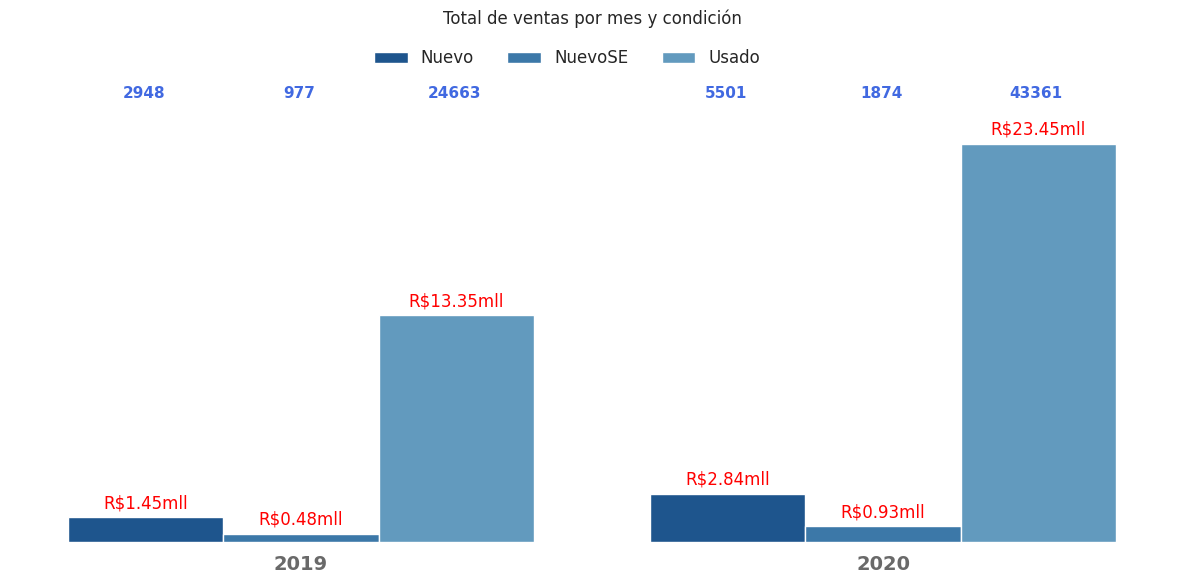

In [76]:
df=df_query_2_1122Y.head(6).copy()
# df=df.año_mes.astype(str)
plt.figure(figsize=(12, 6),facecolor='none')
ax=sns.barplot(data=df, x='year', y='total_por_mes', hue='condicion')
plt.title('Total de ventas por mes y condición')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0,fontweight='bold', fontsize=14,color='dimgray')
plt.legend(title='Condición', bbox_to_anchor=(1.05, 1), loc='upper left')
legend_x = 0.3  # Ajusta la coordenada x de la leyenda
legend_y = 0.95
ax.legend(title='', loc='center left', bbox_to_anchor=(legend_x, legend_y), frameon=False, fontsize=12, ncol=len(df.columns))
# ax.legend(title='', loc='center left', bbox_to_anchor=(legend_x, legend_y), frameon=False, fontsize=12, ncol=len(df.columns))
x_pos=[]
for p,amount in zip(ax.patches,df.cantidad_vendida):
  # if p.get_height()!=0:
    # print(f'{p.get_height()/1e6:.2f}mll-------------{p.get_x()}')
    x_pos.append(p.get_x())
    ax.annotate(f'R${p.get_height()/1e6:.2f}mll', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12,color='red')
    # ax.annotate(amount, (p.get_x() + p.get_width() / 2., 2.6e7), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontweight='bold', fontsize=10,color='navy')
# print(x_pos)
x_pos_order=sorted(x_pos)
# print(x_pos_order)
for amount,order in zip(df.cantidad_vendida,x_pos_order):
    ax.annotate(amount, (order+.13, 2.56e7), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontweight='bold', fontsize=11,color='royalblue')

plt.box(None)
plt.yticks([])
plt.ylim(0,3e7)
plt.tight_layout()
plt.show()

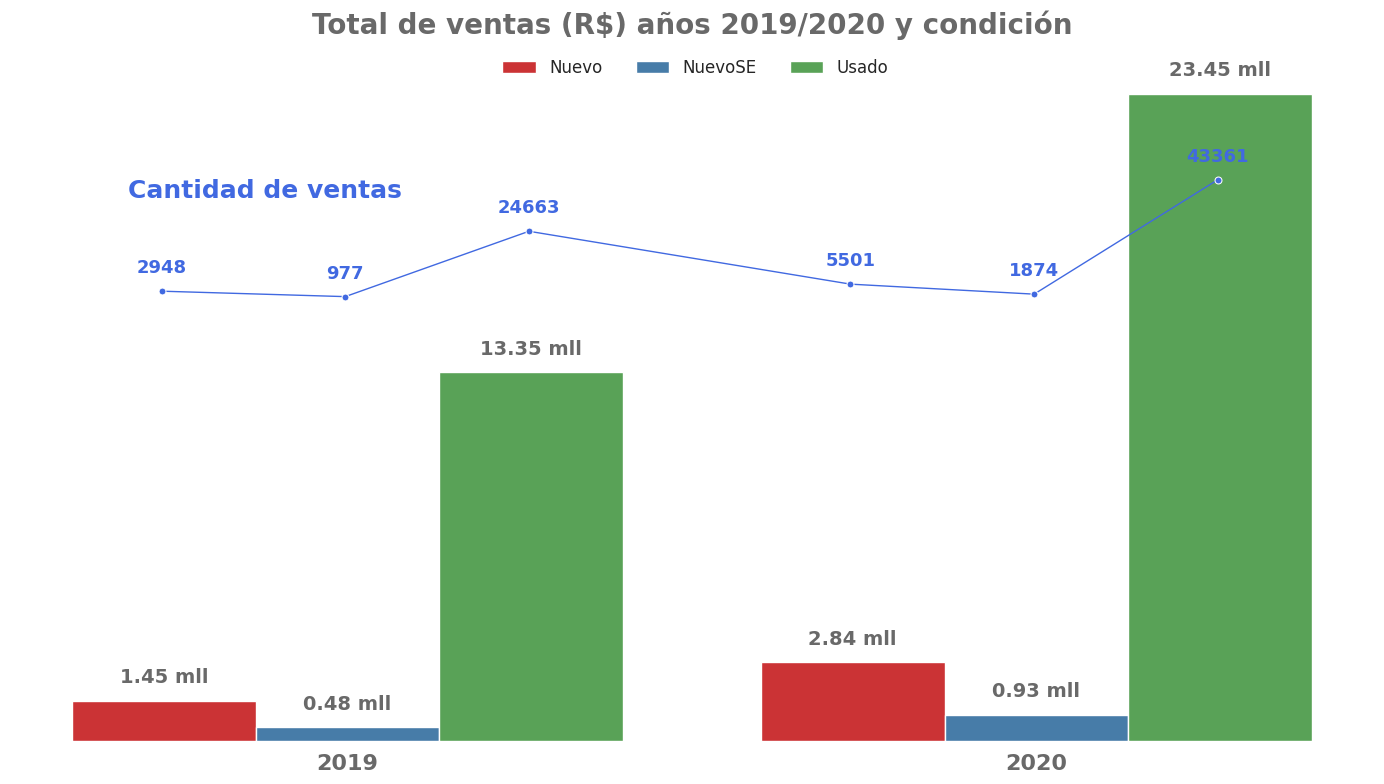

In [221]:
df=df_query_2_1122Y.head(6).copy()
# df=df.año_mes.astype(str)
plt.figure(figsize=(14, 8),facecolor='none')
ax=sns.barplot(data=df, x='year', y='total_por_mes', hue='condicion',palette='Set1')
plt.title('Total de ventas (R$) años 2019/2020 y condición',fontweight='bold', fontsize=20, color='dimgray',pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0,fontweight='bold', fontsize=16,color='dimgray')
x_pos=[]

for p,amount in zip(ax.patches,df.cantidad_vendida):
    x_pos.append(p.get_x())
    ax.annotate(f'{p.get_height()/1e6:.2f} mll', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontsize=14,color='dimgray',rotation=0,fontweight='bold')

x_pos_order=sorted(x_pos)
x_values = []
y_values = []

# Cantidad de ventas
for amount, order in zip(df.cantidad_vendida, x_pos_order):
    ax.annotate(amount, (order+.13, amount * 100 + 16e6), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', fontweight='bold', fontsize=13, color='royalblue', rotation=0)
    x_values.append(order+.13)
    y_values.append(amount * 100 + 16e6)

# Trazar las líneas de cantidad de ventas
sns.lineplot(x=x_values, y=y_values, marker='o', markersize=5, linewidth=1, color='royalblue')
ax.annotate('Cantidad de ventas', (-.12, 19e6), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points',fontweight='bold', fontsize=18,color='royalblue',rotation=0)
legend_x = .35
legend_y = 0.99
plt.legend(title='', loc='center left', bbox_to_anchor=(legend_x, legend_y), frameon=False, fontsize=12, ncol=3)

plt.plot()
plt.box(None)
plt.yticks([])
# plt.ylim(0,3e7)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/graf_ventas_years2019_2020_condicion.png', dpi=300, bbox_inches='tight')
plt.show()

In [78]:
vendedor_group=df_query_2_11.groupby('vendedor_id')['marca'].value_counts()
df_vendedor_group_brand = pd.DataFrame(vendedor_group)
df_vendedor_group_brand.reset_index(drop=False, inplace=True)
df_vendedor_group_brand.vendedor_id.value_counts()

vendedor_id
1    117
2    117
3    117
4    117
5    117
6      1
Name: count, dtype: int64

In [79]:
df_vendedor_group_brand

vendedor_id            marca  count
0              1             Zara    591
1              1            Mixed    323
2              1          Animale    220
3              1     Le Lis Blanc    150
4              1  Banana Republic    129
..           ...              ...    ...
581            5         Talie Nk     18
582            5   American Eagle     17
583            5   Bottega Veneta     16
584            5           Osklen     13
585            6  Banana Republic      1

[586 rows x 3 columns]

In [80]:
# 2019-11-24 00:00:00.000000
df_time_max_value=df_query_2_11[df_query_2_11.fecha_compra=='2019-11-24 00:00:00.000000']
df_time_max_value.head(5)

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
22         138         5412            3  2019-11-24 00:00:00.000000    788   
138        854        87156            4  2019-11-24 00:00:00.000000    800   
363       2138        13472            4  2019-11-24 00:00:00.000000   2250   
451       2565        73692            1  2019-11-24 00:00:00.000000     90   
524       2936        83009            5  2019-11-24 00:00:00.000000   1400   

     id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
22        6555         5412        138         1             788          788   
138       6556        87156        854         5             160          800   
363       6557        13472       2138         5             450         2250   
451       6558        73692       2565         1              90           90   
524       6559        83009       2936         5             280         1400   

    ciudad  costo_envio  ganancia_neta  producto_id               producto  \
22   BR-SP        157.6            630         5412   Camiseta Tencel Umay   
138  BR-AL        160.0            640        87156    Vestido Floral Laco   
363  BR-GO        450.0           1800        13472   Peeptoe Preto Verniz   
451  BR-SP         18.0             72        73692  Shorts Estampa Floral   
524  BR-RN        280.0           1120        83009         Body Babado Pb   

     precio           marca       sku           condicion  
22    788.0           Mixed  257373.0  Nuevo con etiqueta  
138   160.0    Sweet Cotton  263312.0               Usado  
363   450.0  Jorge Bischoff  318875.0               Usado  
451    90.0            Zara  238011.0               Usado  
524   280.0         Karmani  263899.0               Usado

In [81]:
# Vestido Longo Preto
df_time_max_value[df_time_max_value.producto=='Vestido Longo Preto']

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
7763      43999        89100            1  2019-11-24 00:00:00.000000  25200   

      id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
7763       6614        89100      43999         6            4200   

      valor_total ciudad  costo_envio  ganancia_neta  producto_id  \
7763        25200  BR-PR       5040.0          20160        89100   

                 producto  precio         marca       sku condicion  
7763  Vestido Longo Preto  4200.0  Barbara Bela  104978.0     Usado

In [82]:
marca_ganancias_max_time=df_time_max_value.groupby('marca')['ganancia_neta'].sum()
df_marca_ganancias_max_time=pd.DataFrame(marca_ganancias_max_time)
df_marca_ganancias_max_time.sort_values(by='ganancia_neta',inplace=True,ascending=False)
df_marca_ganancias_max_time

ganancia_neta
marca                             
Barbara Bela                 20160
Givenchy                     19200
Mixed                        18681
Tory Burch                   13904
Jimmy Choo                   12432
...                            ...
Forever 21                     208
Erre Erre                      192
Limone By Jade Seba            168
Carter’s                       111
Fabiana Caterina                96

[86 rows x 1 columns]

In [83]:
marca_producto_ganancias_max_time=df_time_max_value.groupby(['marca','producto','cantidad'])['ganancia_neta'].sum()
df_marca_producto_ganancias_max_time=pd.DataFrame(marca_producto_ganancias_max_time)
df_marca_producto_ganancias_max_time.sort_values(by='ganancia_neta',inplace=True,ascending=False)
df_marca_producto_ganancias_max_time.reset_index(drop=False,inplace=True)
df_marca_producto_ganancias_max_time['porcetajes']=df_marca_producto_ganancias_max_time.ganancia_neta*100/df_marca_producto_ganancias_max_time.ganancia_neta.sum()
df_marca_producto_ganancias_max_time

marca               producto  cantidad  ganancia_neta  \
0           Barbara Bela    Vestido Longo Preto         6          20160   
1               Givenchy       Bolsa Coral Saco         6          19200   
2             Jimmy Choo   Scarpin Bege Textura         6          12432   
3    D&g Dolce & Gabbana   Oculos Lente Azulada         5           8960   
4             Kate Spade   Vestido Amarelo Laco         6           6720   
..                   ...                    ...       ...            ...   
187                  H&m     Vestido Estampa Pb         1             96   
188                 Zara  Blusa Preta Aplicacao         1             88   
189                 Zara      Saia Pregas Preta         1             72   
190                 Zara  Shorts Estampa Floral         1             72   
191           Forever 21  Top Cropped Coqueiros         1             64   

     porcetajes  
0      6.952779  
1      6.621694  
2      4.287547  
3      3.090124  
4      2.317593  
..          ...  
187    0.033108  
188    0.030349  
189    0.024831  
190    0.024831  
191    0.022072  

[192 rows x 5 columns]

In [84]:
marca_producto_ganancias_max_time = df_time_max_value.groupby(['marca', 'producto'])['ganancia_neta'].sum().reset_index()
marca_ganancia_total = marca_producto_ganancias_max_time.groupby('marca')['ganancia_neta'].sum().reset_index()
marca_ganancia_total = marca_ganancia_total.sort_values(by='ganancia_neta', ascending=False)

# Reordenar el DataFrame de marca_producto_ganancias_max_time
marca_producto_ganancias_max_time = marca_producto_ganancias_max_time.merge(marca_ganancia_total, on='marca', suffixes=('', '_total'))
marca_producto_ganancias_max_time = marca_producto_ganancias_max_time.sort_values(by='ganancia_neta_total', ascending=False)

# Verificar el resultado
marca_producto_ganancias_max_time.head(20)


marca               producto  ganancia_neta  ganancia_neta_total
15   Barbara Bela    Vestido Longo Preto          20160                20160
49       Givenchy       Bolsa Coral Saco          19200                19200
82          Mixed            Blusa Cinza           2360                18681
83          Mixed        Calca Linho Ten           1592                18681
84          Mixed         Camisa Seda Pb           1276                18681
85          Mixed     Camiseta Cindy Sky           3281                18681
86          Mixed      Camiseta Eternity           2576                18681
87          Mixed   Camiseta Tencel Umay            630                18681
88          Mixed   Casaqueto Fio Mescla           1896                18681
89          Mixed       Saia Guipir Nude           2960                18681
90          Mixed      Saia Jeans Forest           1382                18681
91          Mixed      Saia Preta Babado            256                18681
92          Mixed    Vestido Jeans Ombro            472                18681
117    Tory Burch  Sandalia Lona Cortica           4400                13904
118    Tory Burch  Sapatilha Python Bege           9504                13904
56     Jimmy Choo   Scarpin Bege Textura          12432                12432
33         Diesel   Calca Jeans Costuras          10296                10296
37          Ellus      Vestido Nude Reta           9240                10240
36          Ellus   Calca Preta Resinada           1000                10240
124          Zara         Blusa Tricolor            560                 9836

In [85]:
marca_producto_ganancias_max_time = df_time_max_value.groupby(['marca', 'producto','condicion','cantidad','vendedor_id'])['ganancia_neta'].sum().reset_index()
marca_ganancia_total = marca_producto_ganancias_max_time.groupby('marca')['ganancia_neta'].sum().reset_index()
marca_ganancia_total = marca_ganancia_total.sort_values(by='ganancia_neta', ascending=False)

# Reordenar el DataFrame de marca_producto_ganancias_max_time
marca_producto_ganancias_max_time = marca_producto_ganancias_max_time.merge(marca_ganancia_total, on='marca', suffixes=('', '_total'))
marca_producto_ganancias_max_time = marca_producto_ganancias_max_time.sort_values(by='ganancia_neta_total', ascending=False)

# Verificar el resultado
marca_producto_ganancias_max_time.head(20)


marca               producto           condicion  cantidad  \
26   Barbara Bela    Vestido Longo Preto               Usado         6   
82       Givenchy       Bolsa Coral Saco               Usado         6   
144         Mixed       Saia Guipir Nude               Usado         5   
136         Mixed        Calca Linho Ten  Nuevo con etiqueta         5   
146         Mixed      Saia Preta Babado               Usado         1   
147         Mixed    Vestido Jeans Ombro               Usado         1   
143         Mixed   Casaqueto Fio Mescla               Usado         2   
142         Mixed   Casaqueto Fio Mescla               Usado         1   
141         Mixed   Camiseta Tencel Umay  Nuevo con etiqueta         1   
140         Mixed      Camiseta Eternity  Nuevo con etiqueta         5   
139         Mixed     Camiseta Cindy Sky  Nuevo con etiqueta         5   
138         Mixed     Camiseta Cindy Sky  Nuevo con etiqueta         2   
137         Mixed         Camisa Seda Pb               Usado         2   
135         Mixed            Blusa Cinza               Usado         5   
145         Mixed      Saia Jeans Forest  Nuevo con etiqueta         3   
183    Tory Burch  Sapatilha Python Bege               Usado         5   
182    Tory Burch  Sapatilha Python Bege               Usado         4   
181    Tory Burch  Sapatilha Python Bege               Usado         3   
180    Tory Burch  Sandalia Lona Cortica               Usado         5   
91     Jimmy Choo   Scarpin Bege Textura               Usado         6   

     vendedor_id  ganancia_neta  ganancia_neta_total  
26             1          20160                20160  
82             1          19200                19200  
144            4           2960                18681  
136            4           1592                18681  
146            5            256                18681  
147            1            472                18681  
143            5           1264                18681  
142            2            632                18681  
141            3            630                18681  
140            5           2576                18681  
139            2           2344                18681  
138            5            937                18681  
137            4           1276                18681  
135            5           2360                18681  
145            5           1382                18681  
183            2           3960                13904  
182            2           3168                13904  
181            2           2376                13904  
180            4           4400                13904  
91             1          12432                12432

<ipython-input-86-34e4f1f84ee5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc['Otros'] = otros


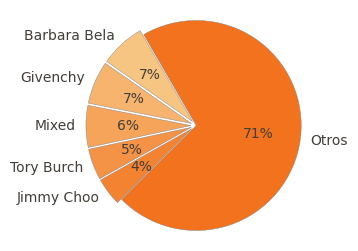

In [86]:
df=df_marca_ganancias_max_time.copy()

# Obtener las marcas que superan el 4% y sumar los porcentajes del resto
df_filtered = df[df['ganancia_neta'] > df['ganancia_neta'].sum() * 0.04]
otros = df[df['ganancia_neta'] <= df['ganancia_neta'].sum() * 0.04]['ganancia_neta'].sum()
df_filtered.loc['Otros'] = otros

# Crear el gráfico de pastel
plt.figure(figsize=(3, 3),facecolor='none')
# plt.title('Distribución de ganancias por marca')

# Utilizar colores predeterminados de Seaborn
colors = sns.color_palette("blend:#F7C582,#F2721D", len(df_filtered))
explode = [0.05,.05,.05,.05,.05,0]
wedgeprops = {'edgecolor': 'gray', 'linewidth': .3}
text_props = {'color': '#423E39', 'fontsize': 10}
plt.pie(df_filtered['ganancia_neta'],explode=explode, labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops)

# Mostrar el gráfico
plt.axis('equal')  # Asegurar que el gráfico de pastel sea circular
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png', dpi=100, bbox_inches='tight')

plt.show()


In [87]:
df_time_max_value.marca.value_counts()

marca
Zara             20
Mixed            14
Le Lis Blanc      7
Animale           7
Farm              7
                 ..
Cris Barros       1
Dkny              1
Mara Mac          1
Louis Vuitton     1
Erre Erre         1
Name: count, Length: 86, dtype: int64

In [88]:
df_time_max_value['ganancia_neta']=df_time_max_value.valor_total-df_time_max_value.costo_envio
df_time_max_value['ganancia_neta'].sum()

<ipython-input-88-d544bd145a30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_max_value['ganancia_neta']=df_time_max_value.valor_total-df_time_max_value.costo_envio


289960.80000000005

In [89]:
df_query_2_1[df_query_2_1.index==df_query_2_1['total_ventas'].idxmax()]

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
323     133120        17258            2  2019-11-24 00:00:00.000000   2100   

     id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
323       6542        17258     133120         5             420         2100   

    ciudad  costo_envio  ganancia_neta  producto_id                 producto  \
323  BR-PR        420.0           1680        17258  Saia Transparente Cover   

     precio         marca       sku condicion  total_ventas  
323   420.0  Luisa Farani  257900.0     Usado      289960.8

In [90]:
max_row = df_query_2_1.loc[df_query_2_1['total_ventas'].idxmax()]
df_max_row=pd.DataFrame(max_row)
df_max_row

323
pedido_id                           133120
producto_id                          17258
vendedor_id                              2
fecha_compra    2019-11-24 00:00:00.000000
total                                 2100
id_recibo                             6542
producto_id                          17258
pedido_id                           133120
cantidad                                 5
valor_unitario                         420
valor_total                           2100
ciudad                               BR-PR
costo_envio                          420.0
ganancia_neta                         1680
producto_id                          17258
producto           Saia Transparente Cover
precio                               420.0
marca                         Luisa Farani
sku                               257900.0
condicion                            Usado
total_ventas                      289960.8

In [271]:
df = df_query_2.copy()

df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

df['año_mes'] = df['fecha_compra'].dt.to_period('M')
df['year'] = df['fecha_compra'].dt.to_period('Y')
df

fecha_compra  total_ventas  año_mes  year
0     2019-01-05       32460.8  2019-01  2019
1     2019-01-06        1728.0  2019-01  2019
2     2019-01-07        1560.0  2019-01  2019
3     2019-01-08        1024.0  2019-01  2019
4     2019-01-09         400.0  2019-01  2019
..           ...           ...      ...   ...
775   2021-02-21       30944.8  2021-02  2021
776   2021-03-07        4744.0  2021-03  2021
777   2021-03-08       16206.4  2021-03  2021
778   2021-03-09        4128.0  2021-03  2021
779   2021-03-10       16141.6  2021-03  2021

[780 rows x 4 columns]

In [280]:
mmm=df.groupby('year')['total_ventas'].sum()
# mmm=df.groupby('year')['total_ventas'].sum().reset_index()
df_mmm=pd.DataFrame(mmm)
df_mmm

total_ventas
year              
2019    12229892.8
2020    21781760.8
2021     2631490.4

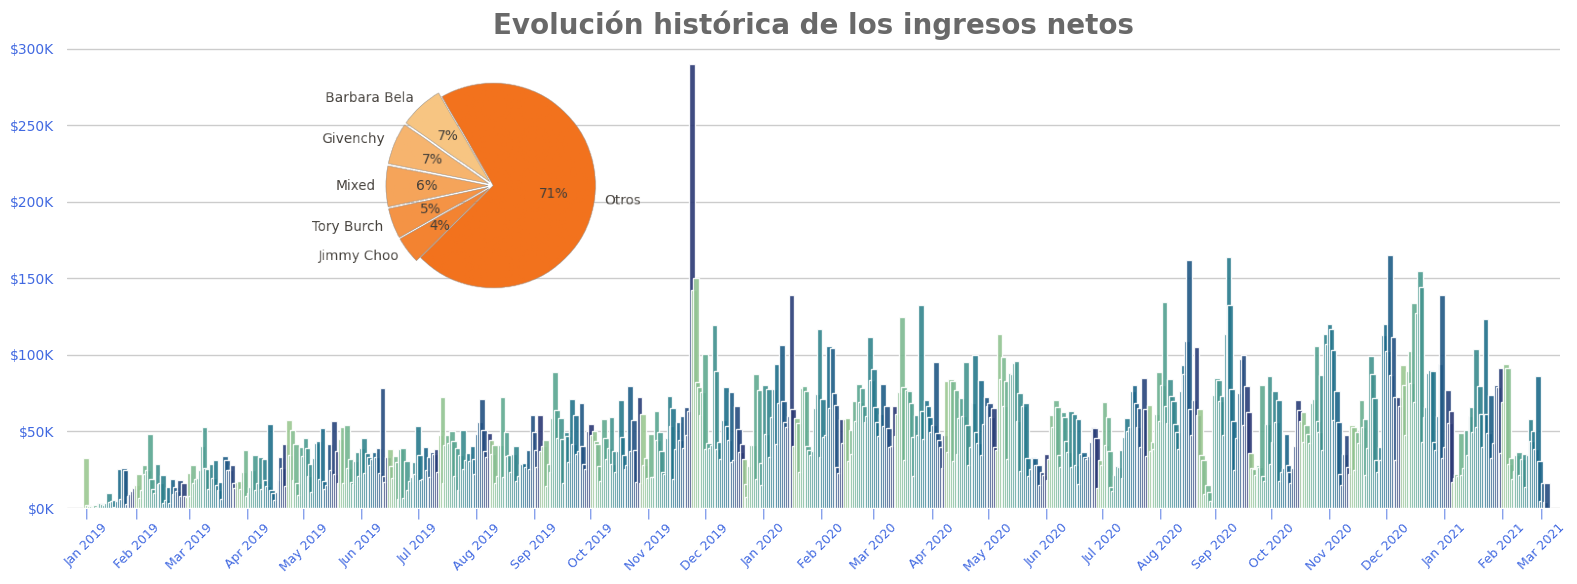

In [92]:
from matplotlib.transforms import Bbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

df = df_query_2.copy()

# Convertir la columna de fecha a tipo datetime
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
df['año_mes'] = df['fecha_compra'].dt.strftime('%b %Y')

plt.figure(figsize=(16, 6))
ax = plt.gca()  # Obtener el objeto de ejes

# Obtener las etiquetas únicas de año-mes
unique_labels = df['año_mes'].unique()
index = list(range(len(df)))

# Obtener los índices enteros para las etiquetas únicas de año-mes
index_labels = [df[df['año_mes'] == label].index.min() for label in unique_labels]

# Especificar la paleta de colores
palette = sns.color_palette("crest", len(unique_labels))
bar_width=3
plt.bar(index, df['total_ventas'], bar_width, color=palette, alpha=0.9)

# Definir la posición y las etiquetas del eje x
plt.xticks(index_labels, unique_labels, rotation=45, ha='center', fontsize=9, color='royalblue')

# Agregar | a los xticks:
for i, label in enumerate(unique_labels[:-1]):
    # print(index_labels[i])
    plt.annotate('|', xy=(index_labels[i], 0), xytext=(index_labels[i+1], 0), ha='center', va='top', fontsize=8, color='royalblue')
plt.annotate('|', xy=(0, 0), xytext=(0, 0), ha='center', va='top', fontsize=8, color='royalblue')

plt.xlabel('')
plt.ylabel('')
plt.title('Evolución histórica de los ingresos netos',fontsize=20,fontweight='bold', color='dimgray')
plt.grid(axis='x')
plt.tight_layout()
plt.xlim(index_labels[0]-10, index_labels[-1]+10)

# Dar formato a las etiquetas del eje y
formatter = FuncFormatter(lambda x, _: f'${int(x/1000)}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks(fontsize=10,color='royalblue')
plt.box(None)

# Añadir la imagen graf pie (% cumulado)
img_pie='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png'
img_ventas = OffsetImage(plt.imread(img_pie), zoom=.7)  # Ajusta el zoom según sea necesario
ab_ventas = AnnotationBbox(img_ventas, (index_labels[7], 210000), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
ax.add_artist(ab_ventas)

plt.show()


In [93]:
df_query_2.total_ventas.max()

289960.8

In [94]:
fila_maxima = df_query_2.loc[df_query_2['total_ventas'].idxmax()]
fila_maxima

fecha_compra    2019-11-24 00:00:00.000000
total_ventas                      289960.8
Name: 323, dtype: object

##**Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [95]:
query_3='''
SELECT
    v.nombre_vendedor,
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2019' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2019",
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2020' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2020",
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2021' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2021"
FROM
    pedidos p
JOIN
    vendedores v ON p.vendedor_id = v.vendedor_id
JOIN
    itens_pedidos ip ON p.pedido_id = ip.pedido_id
GROUP BY
    v.nombre_vendedor;
'''
df_query_3 = pd.read_sql_query(query_3, database)
database.dispose()
df_query_3

nombre_vendedor   Año 2019   Año 2020  Año 2021
0       Ana Duarte  2154261.6  5054009.6  547470.4
1  Daniel Siqueira  2020503.2  5266932.8  419702.4
2  Millena Pereira  2054682.4  3804385.6  398896.0
3   Nadia Oliveira  2296986.4  4046902.4  810020.0
4    Paulo Calanca  3702835.2  3609530.4  455401.6

In [96]:
df_query_3.nombre_vendedor.unique()

array(['Ana Duarte', 'Daniel Siqueira', 'Millena Pereira',
       'Nadia Oliveira', 'Paulo Calanca'], dtype=object)

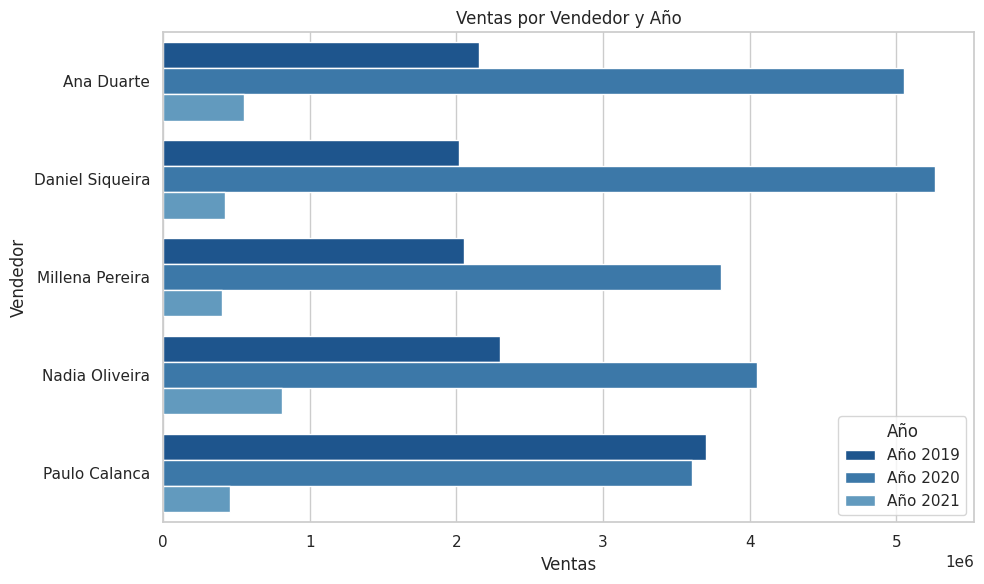

In [97]:
df = df_query_3.copy()

df_melted = df.melt(id_vars='nombre_vendedor', var_name='Año', value_name='Ventas')

# Crear el gráfico de barras apiladas horizontales
plt.subplots(figsize=(10, 6),facecolor='none')
sns.barplot(data=df_melted, x='Ventas', y='nombre_vendedor', hue='Año', orient='horizontal')

# Etiquetas y título
plt.xlabel('Ventas')
plt.ylabel('Vendedor')
plt.title('Ventas por Vendedor y Año')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

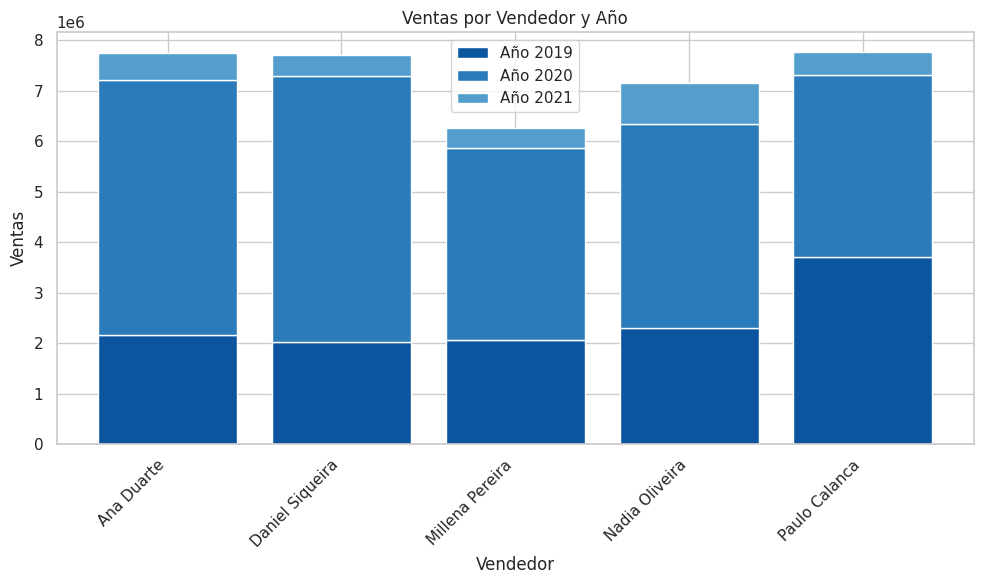

In [98]:
df = df_query_3.copy()

# Crear el gráfico de barras apiladas
plt.subplots(figsize=(10, 6),facecolor='none')
plt.bar(df['nombre_vendedor'], df['Año 2019'], label='Año 2019')
plt.bar(df['nombre_vendedor'], df['Año 2020'], bottom=df['Año 2019'], label='Año 2020')
plt.bar(df['nombre_vendedor'], df['Año 2021'], bottom=df['Año 2019'] + df['Año 2020'], label='Año 2021')

# Etiquetas y título
plt.xlabel('Vendedor')
plt.ylabel('Ventas')
plt.title('Ventas por Vendedor y Año')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


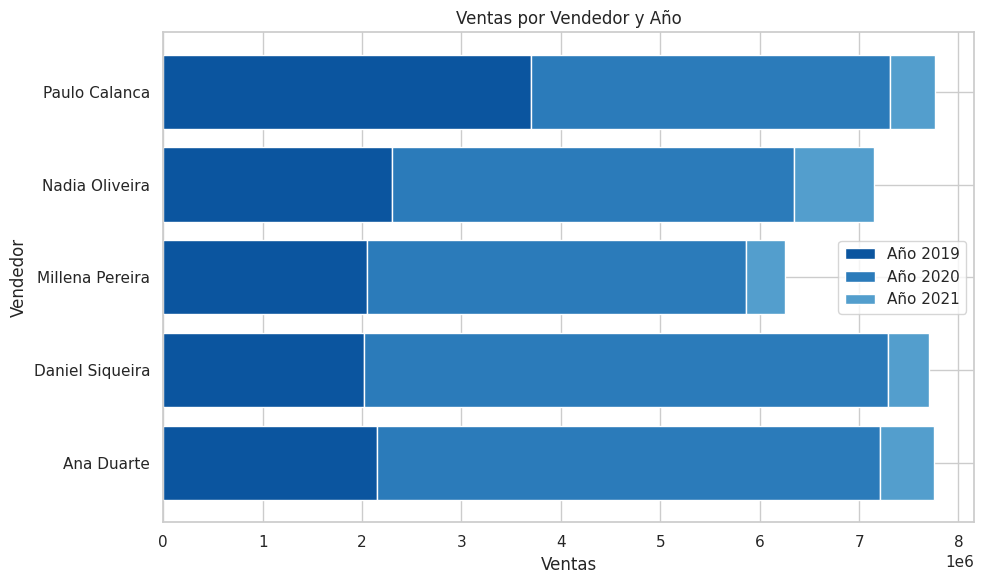

In [99]:
df = df_query_3.copy()

# Crear el gráfico de barras horizontales apiladas
plt.subplots(figsize=(10, 6),facecolor='none')

# Barra para el año 2019
plt.barh(df['nombre_vendedor'], df['Año 2019'], label='Año 2019')

# Barra para el año 2020, colocada sobre la de 2019
plt.barh(df['nombre_vendedor'], df['Año 2020'], left=df['Año 2019'], label='Año 2020')

# Barra para el año 2021, colocada sobre las de 2019 y 2020
plt.barh(df['nombre_vendedor'], df['Año 2021'], left=df['Año 2019'] + df['Año 2020'], label='Año 2021')

# Etiquetas y título
plt.xlabel('Ventas')
plt.ylabel('Vendedor')
plt.title('Ventas por Vendedor y Año')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


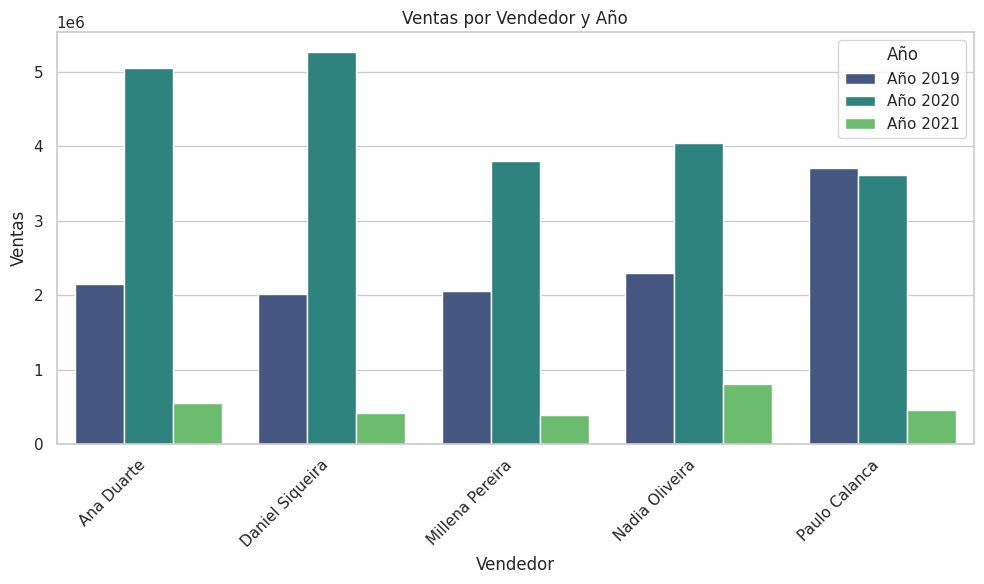

In [100]:
df = df_query_3.copy()

# Melt para convertir los datos a formato largo
df_melted = df.melt(id_vars='nombre_vendedor', var_name='Año', value_name='Ventas')

# Crear el gráfico de barras apiladas
plt.subplots(figsize=(10, 6),facecolor='none')
sns.barplot(data=df_melted, x='nombre_vendedor', y='Ventas', hue='Año', palette='viridis')

# Etiquetas y título
plt.xlabel('Vendedor')
plt.ylabel('Ventas')
plt.title('Ventas por Vendedor y Año')

# Mostrar el gráfico
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


##**Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [101]:
query_4='''
SELECT
    ip.ciudad,
    REPLACE(ip.ciudad, 'BR-', '') AS abbrev_state,
    SUM(p.total - ip.costo_envio) AS ingresos_netos
FROM
    pedidos p
JOIN
    itens_pedidos ip ON p.pedido_id = ip.pedido_id
GROUP BY
    ip.ciudad;
'''
df = pd.read_sql_query(query_4, database)
database.dispose()
df.sort_values(by='ingresos_netos',inplace=True,ascending=False)
df

ciudad abbrev_state  ingresos_netos
1   BR-AL           AL       1522016.0
15  BR-PE           PE       1509197.6
23  BR-SC           SC       1476962.4
3   BR-AP           AP       1475737.6
5   BR-CE           CE       1468080.8
9   BR-MA           MA       1453059.2
14  BR-PB           PB       1423834.4
8   BR-GO           GO       1418205.6
25  BR-SP           SP       1404412.0
12  BR-MT           MT       1363611.2
16  BR-PI           PI       1358606.4
21  BR-RR           RR       1349770.4
13  BR-PA           PA       1345199.2
24  BR-SE           SE       1339291.2
19  BR-RN           RN       1335573.6
18  BR-RJ           RJ       1334395.2
6   BR-DF           DF       1327094.4
4   BR-BA           BA       1322517.6
22  BR-RS           RS       1320528.8
20  BR-RO           RO       1317495.2
10  BR-MG           MG       1314788.8
17  BR-PR           PR       1308105.6
26  BR-TO           TO       1284983.2
7   BR-ES           ES       1275874.4
2   BR-AM           AM       1244092.8
11  BR-MS           MS       1221190.4
0   BR-AC           AC       1128520.0

In [102]:
import geopandas as gpd
import geobr

br_uf = geobr.read_state()
br_uf = br_uf.rename(columns={'abbrev_state': 'abbrev_state'})
br_uf_d = br_uf.merge(df, on='abbrev_state')
br_uf_d = br_uf_d[['geometry','abbrev_state', 'ingresos_netos']]
br_uf_d.head()

geometry abbrev_state  \
0  MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...           RO   
1  MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...           AC   
2  MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...           AM   
3  MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...           RR   
4  MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...           PA   

   ingresos_netos  
0       1317495.2  
1       1128520.0  
2       1244092.8  
3       1349770.4  
4       1345199.2

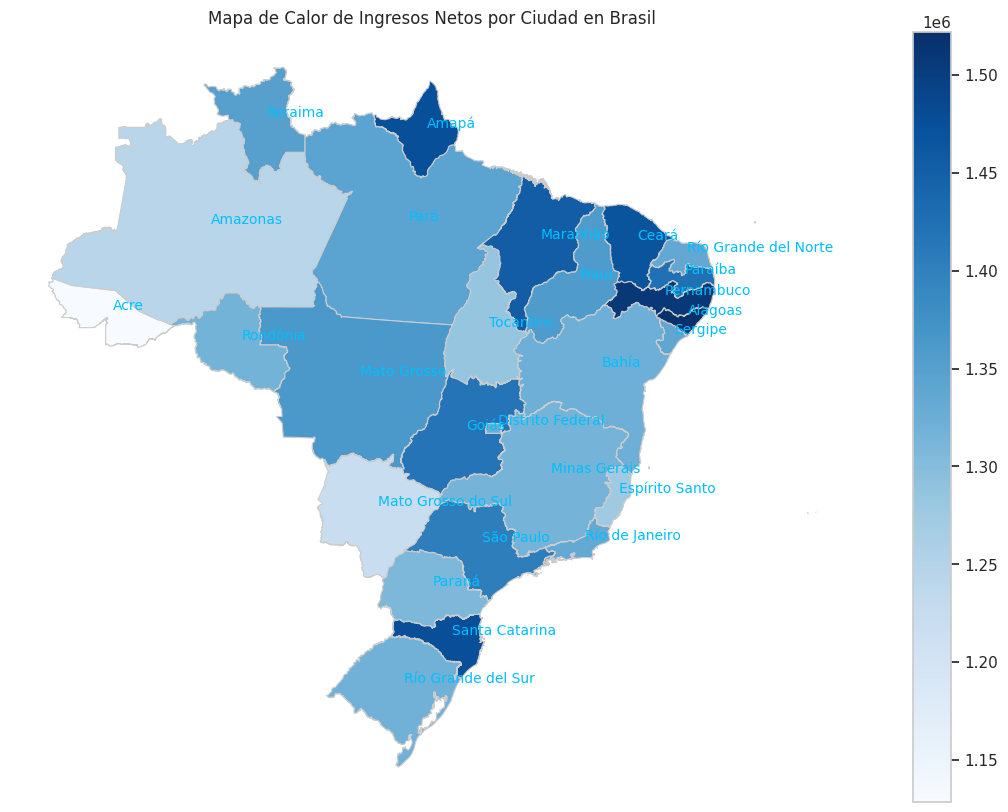

In [103]:
# Diccionario de correspondencias entre siglas y nombres de ciudades
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

# Reemplazar las siglas por los nombres de las ciudades en el dataframe
br_uf_d['state'] = br_uf_d['abbrev_state'].map(ciudades)

br_uf_d = br_uf_d.to_crs(epsg=3857)

# Crear el mapa de calor con los nombres de las ciudades
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# br_uf_d.plot(column='ingresos_netos', cmap='cividis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True) ###MAPA PARA DALTONICOS
br_uf_d.plot(column='ingresos_netos', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# br_uf_d.plot(column='ingresos_netos', cmap='plasma', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# br_uf_d.plot(column='ingresos_netos', cmap='inferno', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# br_uf_d.plot(column='ingresos_netos', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.state):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10, color='deepskyblue')
    # ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10, color='dodgerblue')

plt.title('Mapa de Calor de Ingresos Netos por Ciudad en Brasil')
plt.axis('off')
plt.show()


# INSIGHT

In [104]:
list_ddbb=['pedidos','itens_pedidos','productos','vendedores']
def ver_ddbb():
  for ddbb in list_ddbb:
    query=f'''
    SELECT * FROM {ddbb}
    '''
    df=pd.read_sql_query(query,database)
    print(df.columns.values)
    print('------------')
ver_ddbb()

['pedido_id' 'producto_id' 'vendedor_id' 'fecha_compra' 'total']
------------
['id_recibo' 'producto_id' 'pedido_id' 'cantidad' 'valor_unitario'
 'valor_total' 'ciudad' 'costo_envio' 'ganancia_neta']
------------
['producto_id' 'producto' 'precio' 'marca' 'sku' 'condicion']
------------
['vendedor_id' 'nombre_vendedor']
------------


In [105]:
query_5='''
SELECT
    pedidos.*,
    itens_pedidos.id_recibo,
    itens_pedidos.cantidad,
    itens_pedidos.valor_unitario,
    itens_pedidos.valor_total,
    itens_pedidos.ciudad,
    itens_pedidos.costo_envio,
    itens_pedidos.ganancia_neta,
    productos.producto,
    productos.precio,
    productos.marca,
    productos.sku,
    productos.condicion,
    vendedores.nombre_vendedor
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
JOIN
    vendedores ON pedidos.vendedor_id = vendedores.vendedor_id
GROUP BY
    pedidos.pedido_id;
'''
df_query_5 = pd.read_sql_query(query_5, database)
database.dispose()
df_query_5.head(1)

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
0          1         5292            2  2020-02-16 00:00:00.000000   3456   

   id_recibo  cantidad  valor_unitario  valor_total ciudad  costo_envio  \
0      10062         6             576         3456  BR-PE        691.2   

   ganancia_neta           producto  precio  marca       sku  \
0           2764  Saia Jeans Forest   576.0  Mixed  222683.0   

            condicion  nombre_vendedor  
0  Nuevo con etiqueta  Daniel Siqueira

In [106]:
percent= df_query_5.costo_envio*100/df_query_5.total
percent.value_counts()

20.0    24208
20.0      250
20.0       68
Name: count, dtype: int64

In [107]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import pandas as pd

# Diccionario de mapeo de ciudades a estados
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}
df_query_5['abbrev_state']= [ciudad.replace('BR-', '') for ciudad in df_query_5.ciudad]
# df_query_5['ciudades'] = df_query_5['ciudad'].map(ciudades)
# df_query_5['ciudad_encoded'] = label_encoder.fit_transform(df_query_5['ciudad']) # Codificar las ciudades como variables numéricas
df_query_5['fecha_compra'] = pd.to_datetime(df_query_5['fecha_compra']).dt.strftime('%Y-%m-%d')
df_query_5 = df_query_5.merge(br_uf, on='abbrev_state')
df_query_5.head()

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   
1        107        41189            2   2020-01-17    800       8839   
2        210        10086            1   2020-02-25   4500      10466   
3        356        56571            1   2019-12-25    420       8015   
4        434        40082            4   2019-12-11   1260       7600   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2           2764   
1         5             160          800  BR-PE        160.0            640   
2         6             750         4500  BR-PE        900.0           3600   
3         1             420          420  BR-PE         84.0            336   
4         4             315         1260  BR-PE        252.0           1008   

                producto  precio           marca       sku  \
0      Saia Jeans Forest   576.0           Mixed  222683.0   
1  Calca Acetinada Preta   160.0            Zara  176893.0   
2           Oculos Metal   750.0  Christian Dior  319314.0   
3    Vestido Seda Floral   420.0         Animale  178553.0   
4   Vestido Malha Vitral   315.0           Forum  324684.0   

            condicion  nombre_vendedor abbrev_state  code_state  name_state  \
0  Nuevo con etiqueta  Daniel Siqueira           PE        26.0  Pernambuco   
1               Usado  Daniel Siqueira           PE        26.0  Pernambuco   
2               Usado       Ana Duarte           PE        26.0  Pernambuco   
3               Usado       Ana Duarte           PE        26.0  Pernambuco   
4               Usado  Millena Pereira           PE        26.0  Pernambuco   

   code_region name_region                                           geometry  
0          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
1          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
2          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
3          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
4          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...

In [108]:
df_query_5.name_region.unique()

array(['Nordeste', 'Sul', 'Centro Oeste', 'Norte', 'Sudeste'],
      dtype=object)

In [109]:
df_query_5.costo_envio.mean()

373.5068906466607

In [110]:
# pd.set_option('display.max_row', None)## pd.set_option('display.max_row', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
state_polygon=df_query_5.groupby('name_state')['geometry'].unique()
df_state_polygon=pd.DataFrame(state_polygon)
df_state_polygon.reset_index(drop=False,inplace=True)
df_state_polygon.geometry

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/inference.py:392: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/printi

0     [(POLYGON ((-73.18252539408962 -7.335496464295...
1     [(POLYGON ((-35.46753162562612 -8.817435648807...
2     [(POLYGON ((-51.17970438769309 4.0000812551025...
3     [(POLYGON ((-67.32608847052386 2.0297139057201...
4     [(POLYGON ((-39.364456411366874 -8.53784955370...
5     [(POLYGON ((-41.167030863065435 -4.46735775922...
6     [(POLYGON ((-47.574608978116096 -15.5134068725...
7     [(POLYGON ((-41.87544877040432 -20.76487313584...
8     [(POLYGON ((-50.16014656394112 -12.42007351839...
9     [(POLYGON ((-45.84073319904228 -1.045484730909...
10    [(POLYGON ((-54.89485339361059 -17.62150398815...
11    [(POLYGON ((-56.10370222395111 -17.17353867663...
12    [(POLYGON ((-41.87544877040427 -20.76487313270...
13    [(POLYGON ((-52.05187783852555 -22.53932693455...
14    [(POLYGON ((-37.22268722247751 -6.042148094104...
15    [(POLYGON ((-54.95430669626876 2.5836924234821...
16    [(POLYGON ((-32.397046285111486 -3.83293642792...
17    [(POLYGON ((-41.74604645405293 -2.80349720

In [111]:
#mostrar las filas en las que el costo de envio es mayor al total
df_query_5[df_query_5.valor_total<df_query_5.costo_envio]

Empty DataFrame
Columns: [pedido_id, producto_id, vendedor_id, fecha_compra, total, id_recibo, cantidad, valor_unitario, valor_total, ciudad, costo_envio, ganancia_neta, producto, precio, marca, sku, condicion, nombre_vendedor, abbrev_state, code_state, name_state, code_region, name_region, geometry]
Index: []

In [112]:
df_query_5[df_query_5.costo_envio==df_query_5.costo_envio.max()].head(5)

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
452       68412         3865            1   2021-01-03  39000      23273   
1003      10240         3865            1   2020-04-14  39000      12464   
1590     104844         3865            1   2019-12-15  39000       7758   
1675     119135         3865            1   2020-01-08  39000       8406   
3545     126192         3865            3   2021-01-20  39000      23812   

      cantidad  valor_unitario  valor_total ciudad  costo_envio  \
452          6            6500        39000  BR-PE       7800.0   
1003         6            6500        39000  BR-CE       7800.0   
1590         6            6500        39000  BR-CE       7800.0   
1675         6            6500        39000  BR-CE       7800.0   
3545         6            6500        39000  BR-DF       7800.0   

      ganancia_neta             producto  precio           marca       sku  \
452           31200  Bolsa Classica Roxa  6500.0  Christian Dior  165834.0   
1003          31200  Bolsa Classica Roxa  6500.0  Christian Dior  165834.0   
1590          31200  Bolsa Classica Roxa  6500.0  Christian Dior  165834.0   
1675          31200  Bolsa Classica Roxa  6500.0  Christian Dior  165834.0   
3545          31200  Bolsa Classica Roxa  6500.0  Christian Dior  165834.0   

     condicion nombre_vendedor abbrev_state  code_state        name_state  \
452      Usado      Ana Duarte           PE        26.0        Pernambuco   
1003     Usado      Ana Duarte           CE        23.0             Ceará   
1590     Usado      Ana Duarte           CE        23.0             Ceará   
1675     Usado      Ana Duarte           CE        23.0             Ceará   
3545     Usado  Nadia Oliveira           DF        53.0  Distrito Federal   

      code_region   name_region  \
452           2.0      Nordeste   
1003          2.0      Nordeste   
1590          2.0      Nordeste   
1675          2.0      Nordeste   
3545          5.0  Centro Oeste   

                                               geometry  
452   MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
1003  MULTIPOLYGON (((-41.16703 -4.46736, -41.17757 ...  
1590  MULTIPOLYGON (((-41.16703 -4.46736, -41.17757 ...  
1675  MULTIPOLYGON (((-41.16703 -4.46736, -41.17757 ...  
3545  MULTIPOLYGON (((-47.57461 -15.51341, -47.56997...

In [113]:
df_cluster=df_query_5[['pedido_id','fecha_compra','code_state',	'name_state',	'code_region',	'name_region',	'geometry','costo_envio']]
df_cluster['fecha_compra'] = pd.to_datetime(df_cluster['fecha_compra'])

# Filtrar las compras realizadas en el año 2020
df_cluster_2020 = df_cluster[df_cluster['fecha_compra'].dt.year == 2020]
print(df_cluster_2020.costo_envio.head())

<ipython-input-113-4c3976433492>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['fecha_compra'] = pd.to_datetime(df_cluster['fecha_compra'])


0    691.2
1    160.0
2    900.0
5    576.0
7    108.0
Name: costo_envio, dtype: float64


In [114]:
df_query_2_11.costo_envio.value_counts()

costo_envio
168.0     411
192.0     411
72.0      410
420.0     369
120.0     349
         ... 
268.8      12
518.0      11
135.2      10
3705.0     10
4000.0     10
Name: count, Length: 354, dtype: int64

In [115]:
df_query_2_11.head(1)

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
0          1         5292            2  2020-02-16 00:00:00.000000   3456   

   id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
0      10062         5292          1         6             576         3456   

  ciudad  costo_envio  ganancia_neta  producto_id           producto  precio  \
0  BR-PE        691.2           2764         5292  Saia Jeans Forest   576.0   

   marca       sku           condicion  
0  Mixed  222683.0  Nuevo con etiqueta

In [116]:
datos = df_query_2_11.copy()

# Calcular el total de costos de envío por ciudad
total_costos_por_ciudad = datos.groupby('ciudad')['costo_envio'].sum().reset_index()

# Calcular el total de ventas por ciudad
total_ventas_por_ciudad = datos.groupby('ciudad')['total'].sum().reset_index()

# Combinar los datos de costos de envío y ventas por ciudad
datos_combinados = pd.merge(total_costos_por_ciudad, total_ventas_por_ciudad, on='ciudad')

# Ordenar los datos por el total de costos de envío de forma descendente
datos_combinados = datos_combinados.sort_values(by='costo_envio', ascending=False)
datos_combinados

ciudad  costo_envio    total
1   BR-AL     380504.0  1902520
15  BR-PE     377299.4  1886497
23  BR-SC     369240.6  1846203
3   BR-AP     368934.4  1844672
5   BR-CE     367020.2  1835101
9   BR-MA     363264.8  1816324
14  BR-PB     355958.6  1779793
8   BR-GO     354551.4  1772757
25  BR-SP     351103.0  1755515
12  BR-MT     340902.8  1704514
16  BR-PI     339651.6  1698258
21  BR-RR     337442.6  1687213
13  BR-PA     336299.8  1681499
24  BR-SE     334822.8  1674114
19  BR-RN     333893.4  1669467
18  BR-RJ     333598.8  1667994
6   BR-DF     331773.6  1658868
4   BR-BA     330629.4  1653147
22  BR-RS     330132.2  1650661
20  BR-RO     329373.8  1646869
10  BR-MG     328697.2  1643486
17  BR-PR     327026.4  1635132
26  BR-TO     321245.8  1606229
7   BR-ES     318968.6  1594843
2   BR-AM     311023.2  1555116
11  BR-MS     305297.6  1526488
0   BR-AC     282130.0  1410650

In [117]:
377299.4*100/1886497


20.0

In [118]:
datos = df_query_2_11.copy()
# Calcular el total de costos de envío por ciudad
total_costos_por_ciudad = datos.groupby('ciudad')['costo_envio'].sum().reset_index()
# Calcular el total de ventas por ciudad
total_ganancia_neta_por_ciudad = datos.groupby('ciudad')['ganancia_neta'].sum().reset_index()
# Combinar los datos de costos de envío y ventas por ciudad
datos_combinados_envio_ganancia = pd.merge(total_costos_por_ciudad, total_ganancia_neta_por_ciudad, on='ciudad')
# Calcular el total de ventas por ciudad
total_ventas_por_ciudad = datos.groupby('ciudad')['total'].sum().reset_index()
# Combinar los datos de costos de envío y ventas por ciudad
datos_combinados_final = pd.merge(datos_combinados_envio_ganancia, total_ventas_por_ciudad, on='ciudad')
# Ordenar los datos por el total de costos de envío de forma descendente
datos_combinados_final = datos_combinados_final.sort_values(by='costo_envio', ascending=False)
datos_combinados_final['cod_ciudad']= [ciudad.replace('BR-', '') for ciudad in datos_combinados_final.ciudad]
datos_combinados_final['ciudad'] = datos_combinados_final['cod_ciudad'].map(ciudades)
datos_combinados_final=datos_combinados_final[['ciudad',	'costo_envio',	'ganancia_neta',	'total']]
datos_combinados_final['percent'] = datos_combinados_final['costo_envio'] * 100 / datos_combinados_final['total']
datos_combinados_final

ciudad  costo_envio  ganancia_neta    total  percent
1                Alagoas     380504.0        1521989  1902520     20.0
15            Pernambuco     377299.4        1509172  1886497     20.0
23        Santa Catarina     369240.6        1476940  1846203     20.0
3                  Amapá     368934.4        1475708  1844672     20.0
5                  Ceará     367020.2        1468041  1835101     20.0
9               Maranhão     363264.8        1453022  1816324     20.0
14               Paraíba     355958.6        1423807  1779793     20.0
8                  Goiás     354551.4        1418180  1772757     20.0
25             São Paulo     351103.0        1404384  1755515     20.0
12           Mato Grosso     340902.8        1363581  1704514     20.0
16                 Piauí     339651.6        1358574  1698258     20.0
21               Roraima     337442.6        1349741  1687213     20.0
13                  Pará     336299.8        1345172  1681499     20.0
24               Sergipe     334822.8        1339264  1674114     20.0
19  Río Grande del Norte     333893.4        1335546  1669467     20.0
18        Río de Janeiro     333598.8        1334368  1667994     20.0
6       Distrito Federal     331773.6        1327068  1658868     20.0
4                  Bahía     330629.4        1322488  1653147     20.0
22    Río Grande del Sur     330132.2        1320498  1650661     20.0
20              Rondônia     329373.8        1317470  1646869     20.0
10          Minas Gerais     328697.2        1314754  1643486     20.0
17                Paraná     327026.4        1308078  1635132     20.0
26             Tocantins     321245.8        1284950  1606229     20.0
7         Espírito Santo     318968.6        1275849  1594843     20.0
2               Amazonas     311023.2        1244061  1555116     20.0
11    Mato Grosso do Sul     305297.6        1221151  1526488     20.0
0                   Acre     282130.0        1128495  1410650     20.0

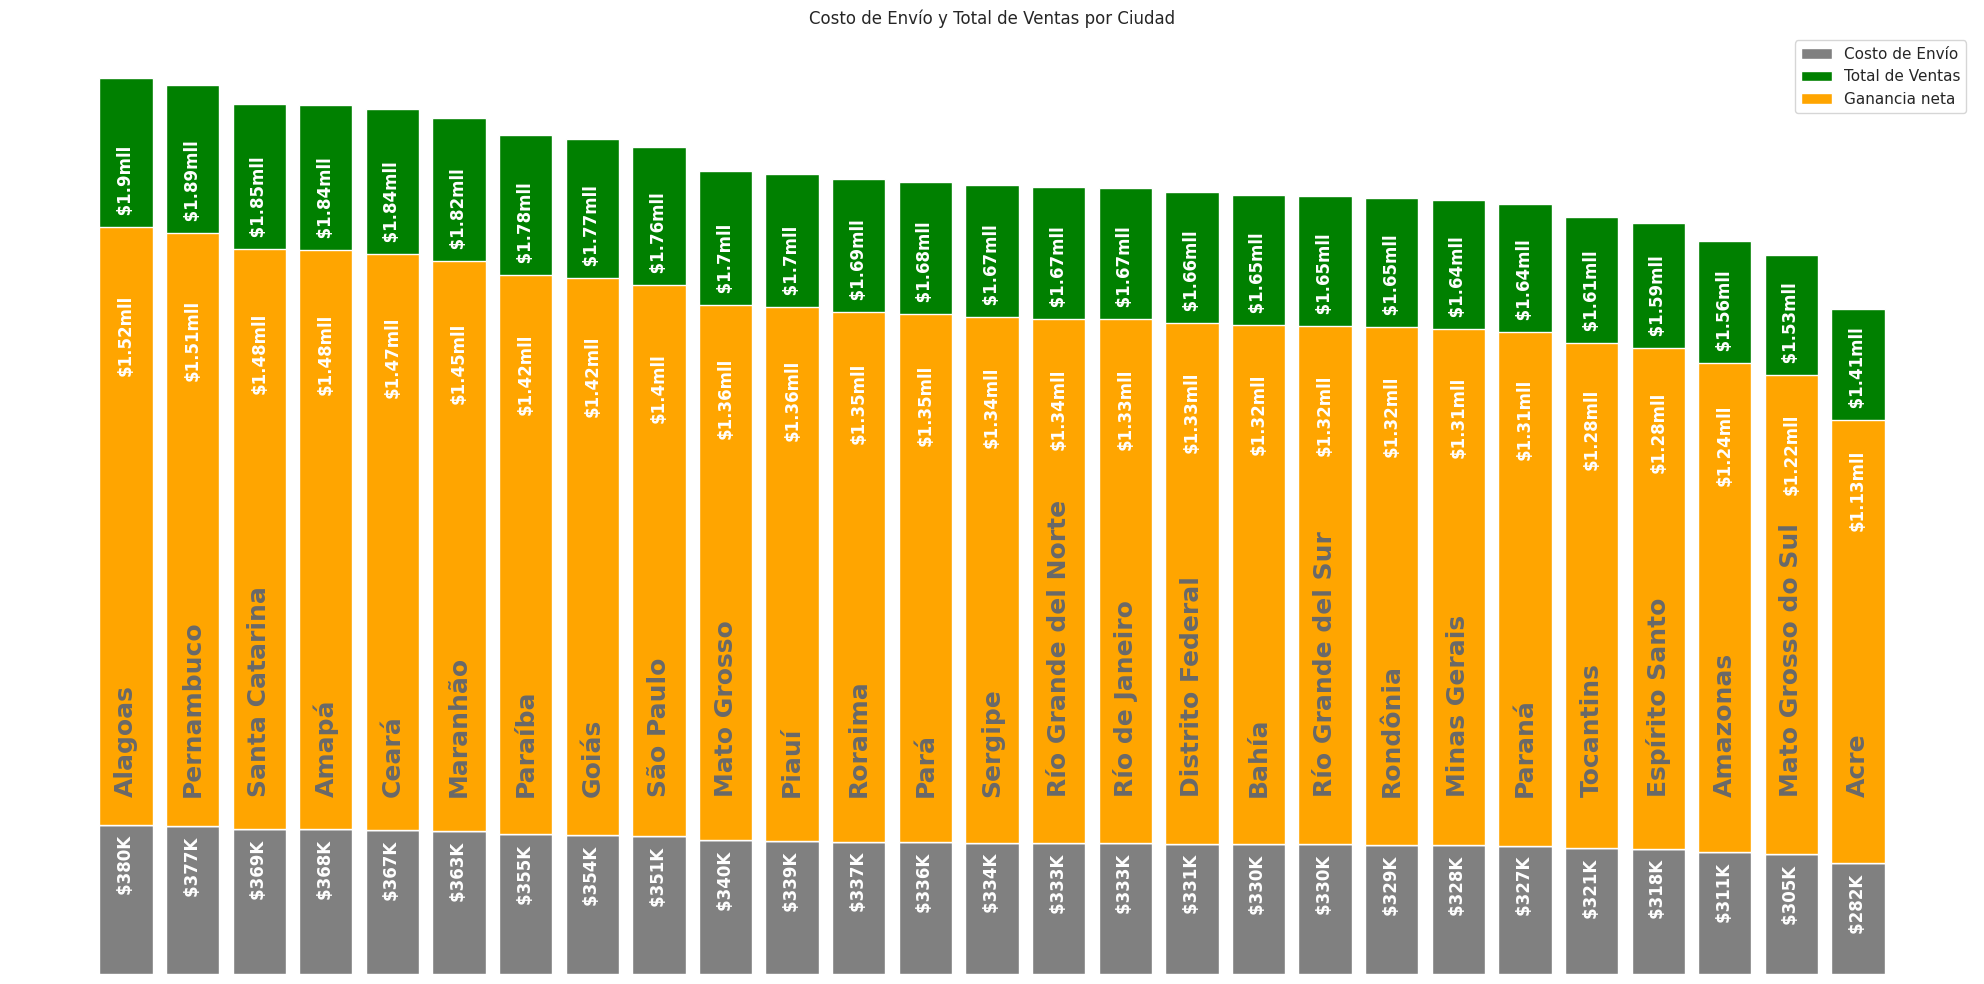

In [119]:
df = datos_combinados_final.copy()
plt.figure(figsize=(20, 10))
bar1 = plt.bar(df['ciudad'], df['costo_envio'], color='gray', label='Costo de Envío')
bar2 = plt.bar(df['ciudad'], df['total'], color='green', bottom=df['costo_envio'], label='Total de Ventas')
bar3 = plt.bar(df['ciudad'], df['ganancia_neta'], color='orange', bottom=df['costo_envio'], label='Ganancia neta')

plt.title('Costo de Envío y Total de Ventas por Ciudad')
plt.legend()
plt.xticks(rotation=45, ha='right')

# Agregar valores al final de las barras de costo_envio
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'${int(yval/1000)}K  ', va='top', ha='center', rotation=90,color='white', fontsize='12',fontweight='bold')

# Agregar valores al final de las barras de ciudad
for bar, state in zip(bar3, df.ciudad):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 4.5e5, state, va='bottom', ha='center', rotation=90, color='dimgray', fontsize='18', fontweight='bold')

# Agregar valores al final de las barras de  total
for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'  ${round(yval/1e6,2)}mll', va='bottom', ha='center', rotation=90,color='white', fontsize='12',fontweight='bold')

# Agregar valores al final de las barras de ganancia
for bar in bar3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'${round(yval/1e6,2)}mll', va='bottom', ha='center', rotation=90,color='white', fontsize='12',fontweight='bold')

plt.ylabel('')
plt.xlabel('')
plt.box(None)
plt.grid(None)
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.show()


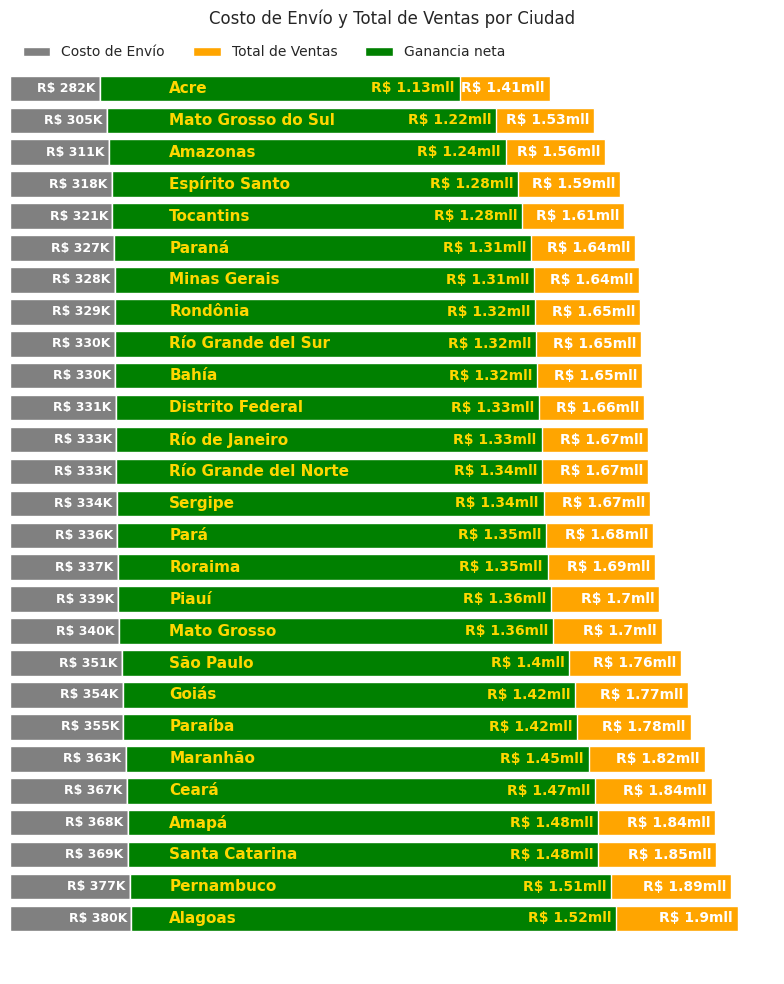

In [120]:
df = datos_combinados_final.copy()

plt.figure(figsize=(8, 10))

bar1 = plt.barh(df['ciudad'], df['costo_envio'], color='gray', label='Costo de Envío')
bar2 = plt.barh(df['ciudad'], df['total'], color='orange', left=df['costo_envio'], label='Total de Ventas')
bar3 = plt.barh(df['ciudad'], df['ganancia_neta'], color='green', left=df['costo_envio'], label='Ganancia neta')

plt.title('Costo de Envío y Total de Ventas por Ciudad')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.box(None)
plt.grid(None)
plt.xticks([])
plt.yticks([])

# Agregar valores al final de las barras de ciudad
for bar, state in zip(bar3, df.ciudad):
    xval = bar.get_width()
    plt.text(5e5, bar.get_y() + bar.get_height()/2, state, va='center', ha='left', rotation=0, color='gold', fontsize='11', fontweight='bold')


# Agregar valores al final de las barras de costo_envio
for bar in bar1:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f'R$ {int(xval/1000)}K ', va='center', ha='right', color='white', fontsize=9, fontweight='bold')

# Agregar valores al final de las barras de  total
for bar in bar2:
    xval = bar.get_width()
    plt.text(xval + bar.get_x(), bar.get_y() + bar.get_height()/2, f'R$ {round(xval/1e6,2)}mll ', va='center', ha='right', color='white', fontsize=10, fontweight='bold')

# Agregar valores al final de las barras de ganancia
for bar in bar3:
    xval = bar.get_width()
    plt.text(xval + bar.get_x(), bar.get_y() + bar.get_height()/2, f'R$ {round(xval/1e6,2)}mll ', va='center', ha='right', color='gold', fontsize=10, fontweight='bold')

plt.legend(title='', loc='upper left', frameon=False, fontsize=10, ncol=3)

plt.tight_layout()
plt.show()


In [121]:
df= df_query_2_11.copy()
# Seleccionar las columnas relevantes
df_subset = df[['marca', 'ciudad', 'costo_envio']]

# Agrupar los datos por marca y ciudad y sumar los costos de envío
agrupado = df_subset.groupby(['marca', 'ciudad']).sum().reset_index()

agrupado


marca ciudad  costo_envio
0      284  BR-AC       1218.0
1      284  BR-AL        462.0
2      284  BR-AM        924.0
3      284  BR-AP        504.0
4      284  BR-BA        840.0
...    ...    ...          ...
3120  Zara  BR-RS      10381.2
3121  Zara  BR-SC      12511.8
3122  Zara  BR-SE       9133.0
3123  Zara  BR-SP       9407.8
3124  Zara  BR-TO      10448.6

[3125 rows x 3 columns]

<ipython-input-122-329da4f1be8d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='ciudad', y='costo_envio', data=datos, palette=colores, jitter=True)


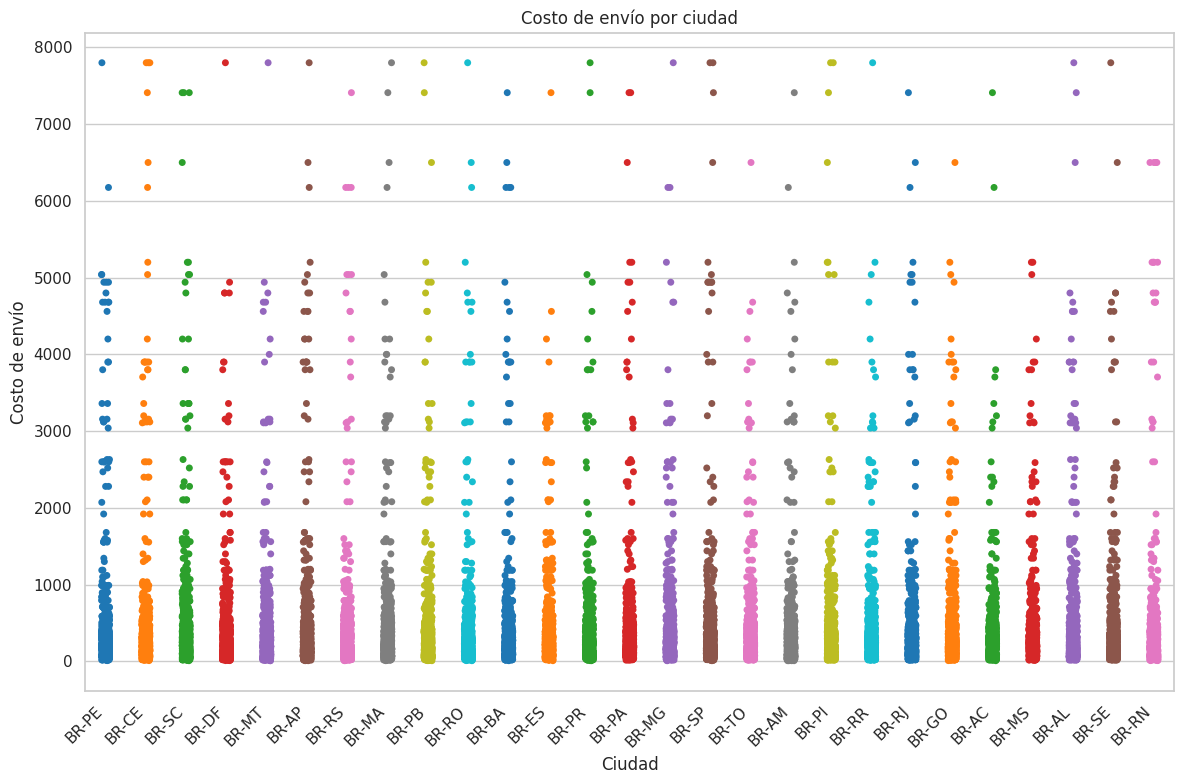

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los datos
datos = df_query_2_11.copy()

# Obtener una lista de colores únicos para cada estado
colores = sns.color_palette('tab10', len(datos['ciudad'].unique()))

# Graficar el costo de envío en función de la ciudad
plt.figure(figsize=(12, 8))
sns.stripplot(x='ciudad', y='costo_envio', data=datos, palette=colores, jitter=True)
plt.xlabel('Ciudad')
plt.ylabel('Costo de envío')
plt.title('Costo de envío por ciudad')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor visualización
plt.tight_layout()
plt.show()


In [123]:
df = df_query_2_11.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
costos_por_año_mes = df.groupby('fecha_compra')['costo_envio'].sum()
df_costos_por_año_mes=pd.DataFrame(costos_por_año_mes)
df_costos_por_año_mes.reset_index(inplace=True)
df_costos_por_año_mes['year_month'] = df_costos_por_año_mes['fecha_compra'].dt.strftime('%b %Y')
df_costos_por_año_mes[['costo_envio','year_month']]

costo_envio year_month
0         8115.2   Jan 2019
1          432.0   Jan 2019
2          390.0   Jan 2019
3          256.0   Jan 2019
4          100.0   Jan 2019
..           ...        ...
775       7736.2   Feb 2021
776       1186.0   Mar 2021
777       4051.6   Mar 2021
778       1032.0   Mar 2021
779       4035.4   Mar 2021

[780 rows x 2 columns]

In [124]:
total_costos_por_año_mes=df_costos_por_año_mes.groupby('year_month')['costo_envio'].sum()
df_total_costos_por_año_mes=pd.DataFrame(total_costos_por_año_mes).reset_index()
df_total_costos_por_año_mes['year_month'] = pd.to_datetime(df_total_costos_por_año_mes['year_month'])
df_total_costos_por_año_mes.sort_values('year_month',inplace=True)
df_total_costos_por_año_mes['year_month'] = df_total_costos_por_año_mes['year_month'].dt.strftime('%b %Y')
df_total_costos_por_año_mes.reset_index(drop=True,inplace=True)
df_total_costos_por_año_mes

<ipython-input-124-da69c38b7683>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_total_costos_por_año_mes['year_month'] = pd.to_datetime(df_total_costos_por_año_mes['year_month'])


year_month  costo_envio
0    Jan 2019      52123.2
1    Feb 2019     109628.8
2    Mar 2019     176711.8
3    Apr 2019     180894.2
4    May 2019     240403.4
5    Jun 2019     222525.4
6    Jul 2019     273308.4
7    Aug 2019     288827.6
8    Sep 2019     332144.6
9    Oct 2019     322686.2
10   Nov 2019     475753.2
11   Dec 2019     382466.4
12   Jan 2020     491650.4
13   Feb 2020     433677.2
14   Mar 2020     494459.4
15   Apr 2020     437911.8
16   May 2020     433619.8
17   Jun 2020     315558.2
18   Jul 2020     376202.0
19   Aug 2020     453710.0
20   Sep 2020     485645.4
21   Oct 2020     415983.0
22   Nov 2020     416166.8
23   Dec 2020     690856.2
24   Jan 2021     419421.8
25   Feb 2021     228145.8
26   Mar 2021      10305.0

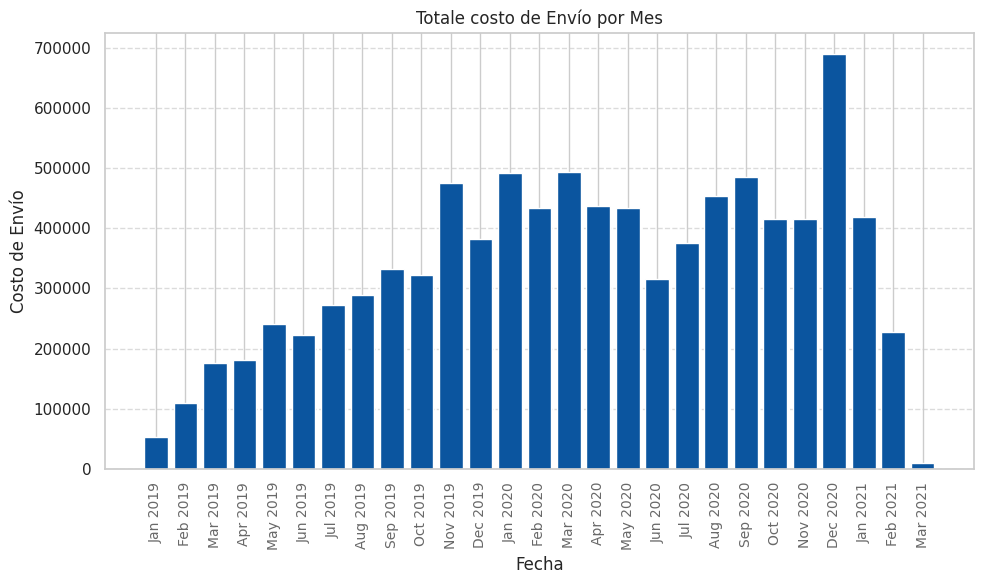

In [125]:
df=df_total_costos_por_año_mes.copy()
plt.subplots(figsize=(10, 6),facecolor='none')
plt.bar(df['year_month'], df['costo_envio'])
plt.title('Totale costo de Envío por Mes')
plt.xlabel('Fecha')
plt.ylabel('Costo de Envío')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, fontsize=10, color= 'dimgray',ha='center')
plt.tight_layout()
plt.show()

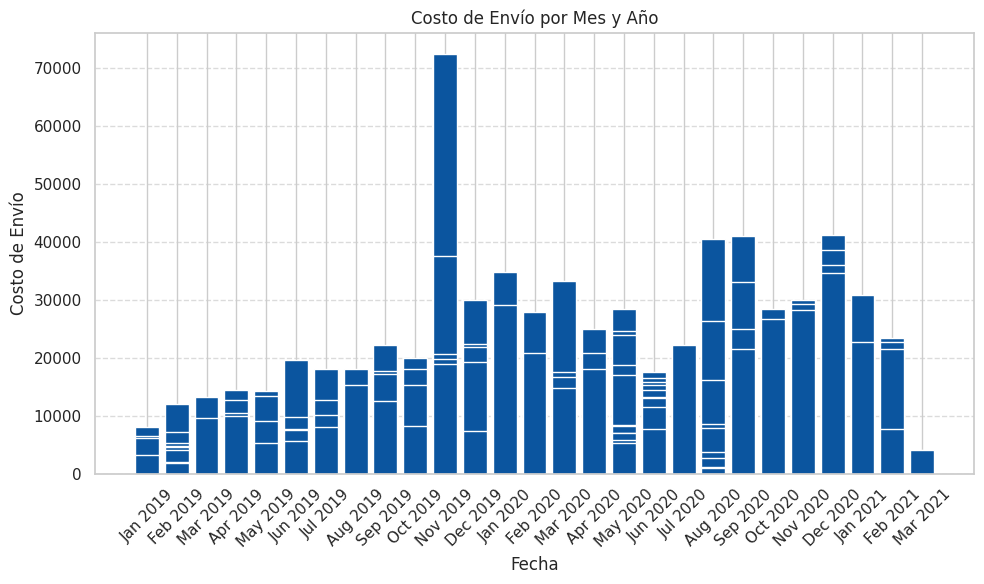

In [126]:
df = df_query_2_11.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
costos_por_año_mes = df.groupby('fecha_compra')['costo_envio'].sum()
df_costos_por_año_mes=pd.DataFrame(costos_por_año_mes)
df_costos_por_año_mes.reset_index(inplace=True)
df_costos_por_año_mes['year_month'] = df_costos_por_año_mes['fecha_compra'].dt.strftime('%b %Y')
df_costos_por_año_mes[['costo_envio','year_month']]
df=df_costos_por_año_mes

# Crear el gráfico de barras
plt.subplots(figsize=(10, 6),facecolor='none')
plt.bar(df['year_month'], df['costo_envio'])
plt.title('Costo de Envío por Mes y Año')
plt.xlabel('Fecha')
plt.ylabel('Costo de Envío')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [127]:
df_query_5.head()

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   
1        107        41189            2   2020-01-17    800       8839   
2        210        10086            1   2020-02-25   4500      10466   
3        356        56571            1   2019-12-25    420       8015   
4        434        40082            4   2019-12-11   1260       7600   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2           2764   
1         5             160          800  BR-PE        160.0            640   
2         6             750         4500  BR-PE        900.0           3600   
3         1             420          420  BR-PE         84.0            336   
4         4             315         1260  BR-PE        252.0           1008   

                producto  precio           marca       sku  \
0      Saia Jeans Forest   576.0           Mixed  222683.0   
1  Calca Acetinada Preta   160.0            Zara  176893.0   
2           Oculos Metal   750.0  Christian Dior  319314.0   
3    Vestido Seda Floral   420.0         Animale  178553.0   
4   Vestido Malha Vitral   315.0           Forum  324684.0   

            condicion  nombre_vendedor abbrev_state  code_state  name_state  \
0  Nuevo con etiqueta  Daniel Siqueira           PE        26.0  Pernambuco   
1               Usado  Daniel Siqueira           PE        26.0  Pernambuco   
2               Usado       Ana Duarte           PE        26.0  Pernambuco   
3               Usado       Ana Duarte           PE        26.0  Pernambuco   
4               Usado  Millena Pereira           PE        26.0  Pernambuco   

   code_region name_region                                           geometry  
0          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
1          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
2          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
3          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  
4          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...

In [128]:
# pd.set_option('display.max_row', None)
unique_encoded_cities = df_query_5[['name_state','costo_envio']].drop_duplicates().sort_values(by='name_state')
unique_encoded_cities['distancia']=unique_encoded_cities['costo_envio']
unique_encoded_cities[['name_state','distancia']].head(4)


name_state  distancia
20866       Acre        9.0
20176       Acre       40.0
20174       Acre      220.0
20173       Acre      240.0

In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Cargar los datos
datos = unique_encoded_cities[['name_state', 'distancia']]

# Dividir los datos en características (X) y etiquetas (y)
X = datos[['distancia']]
y = datos['name_state']

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predicciones = knn.predict(X_test)

# Calcular la precisión del modelo
precision = accuracy_score(y_test, predicciones)
print("Precisión del modelo KNN:", precision)

# Predicciones para nuevas instancias
nuevas_instancias = pd.DataFrame({'distancia': [200, 400, 600]})
predicciones_nuevas = knn.predict(nuevas_instancias)
print("Predicciones para nuevas instancias:", predicciones_nuevas)


Precisión del modelo KNN: 0.0
Predicciones para nuevas instancias: ['Bahia' 'Mato Grosso' 'Rio Grande Do Sul']


In [130]:
df_query_5.groupby('abbrev_state')['costo_envio'].value_counts()

abbrev_state  costo_envio
AC            192.0          18
              420.0          17
              168.0          17
              320.0          16
              252.0          16
                             ..
TO            118.0           1
              124.0           1
              128.8           1
              16.0            1
              6500.0          1
Name: count, Length: 7018, dtype: int64

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

df=df_query_5.copy()
X = df[['costo_envio', 'valor_unitario']]  # Por ejemplo, costo de envío y valor unitario

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenar el modelo k-NN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_scaled, df['ciudad'])

# Predecir los centros de distribución para nuevos datos (por ejemplo, nuevas instancias)
nueva_instancia = [[500, 200]]  # Por ejemplo, costo de envío de 500 y valor unitario de 200
nueva_instancia_scaled = scaler.transform(nueva_instancia)
prediccion = knn.predict(nueva_instancia_scaled)

print("El centro de distribución predicho para la nueva instancia es:", prediccion)


El centro de distribución predicho para la nueva instancia es: ['BR-AM']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [132]:
# Definir los rangos para el costo de envío
rangos = [(0, 100), (101, 500), (501, np.inf)]
etiquetas = ['Bajo', 'Medio', 'Alto']

# Crear una nueva columna con los rangos de costo de envío
df_query_5['rango_costo_envio'] = pd.cut(df_query_5['costo_envio'], bins=[0, 100, 500, np.inf], labels=['Bajo', 'Medio', 'Alto'])

# Seleccionar las características relevantes
X = df_query_5[['rango_costo_envio', 'valor_unitario']]

# Codificar las características categóricas
X = pd.get_dummies(X, columns=['rango_costo_envio'])

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenar el modelo k-NN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_scaled, df_query_5['name_state'])

# Predecir los centros de distribución para nuevas instancias
nueva_instancia_df = pd.DataFrame([[500, 200, 0, 0]], columns=X.columns)

# Normalizar los datos
nueva_instancia_scaled = scaler.transform(nueva_instancia_df)
prediccion = knn.predict(nueva_instancia_scaled)

print("El centro de distribución predicho para la nueva instancia es:", prediccion)


El centro de distribución predicho para la nueva instancia es: ['Distrito Federal']


In [133]:
# Definir los nuevos rangos para el costo de envío
nuevos_rangos = [(0, 50), (51, 200), (201, 500), (501, 1000), (1001, np.inf)]
etiquetas = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']

# Crear una nueva columna con los nuevos rangos de costo de envío
df_query_5['rango_costo_envio'] = pd.cut(df_query_5['costo_envio'], bins=[0, 50, 200, 500, 1000, np.inf], labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

# Seleccionar las características relevantes
X = df_query_5[['rango_costo_envio', 'valor_unitario']]

# Codificar las características categóricas
X = pd.get_dummies(X, columns=['rango_costo_envio'])

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenar el modelo k-NN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_scaled, df_query_5['name_state'])

# Predecir los centros de distribución para nuevas instancias
nueva_instancia_df = pd.DataFrame([[500, 200, 0, 0, 0, 0]], columns=X.columns)

# Normalizar los datos
nueva_instancia_scaled = scaler.transform(nueva_instancia_df)
prediccion = knn.predict(nueva_instancia_scaled)

print("El centro de distribución predicho para la nueva instancia es:", prediccion)


El centro de distribución predicho para la nueva instancia es: ['Mato Grosso']


In [134]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Diccionario con las ciudades y sus coordenadas geográficas aproximadas
ciudades = {
    'Acre': (-9.0477, -70.5267),
    'Alagoas': (-9.5713, -36.782),
    'Amazonas': (-3.4168, -65.8561),
    'Amapá': (0.9026, -52.0028),
    'Bahía': (-12.9714, -38.5014),
    'Ceará': (-3.7172, -38.5431),
    'Distrito Federal': (-15.7934, -47.8825),
    'Espírito Santo': (-20.3155, -40.3128),
    'Goiás': (-15.827, -49.8362),
    'Maranhão': (-2.55, -44.3067),
    'Minas Gerais': (-19.9167, -43.9333),
    'Mato Grosso do Sul': (-20.4428, -54.6464),
    'Mato Grosso': (-15.596, -56.0969),
    'Pará': (-1.455, -48.5028),
    'Paraíba': (-7.115, -34.8631),
    'Pernambuco': (-8.0476, -34.877),
    'Piauí': (-5.0919, -42.8034),
    'Paraná': (-25.4284, -49.2733),
    'Río de Janeiro': (-22.9068, -43.1729),
    'Río Grande del Norte': (-5.7945, -35.211),
    'Rondônia': (-11.5057, -63.5806),
    'Roraima': (2.8198, -60.6715),
    'Río Grande del Sur': (-30.0331, -51.23),
    'Santa Catarina': (-27.5954, -48.548),
    'Sergipe': (-10.9472, -37.0731),
    'São Paulo': (-23.5505, -46.6333),
    'Tocantins': (-10.1753, -48.2982)
}

# Coordenadas de São Paulo
coordenadas_sp = ciudades['São Paulo']

# Inicializar el geolocalizador con OpenStreetMap como proveedor
geolocalizador = Nominatim(user_agent="geoapiExercises")

# Diccionario para almacenar las distancias
distancias_a_sp = {}

# Calcular la distancia desde São Paulo a cada ciudad
for ciudad, coordenadas in ciudades.items():
    distancia = geodesic(coordenadas_sp, coordenadas).kilometers
    distancias_a_sp[ciudad] = distancia

# Mostrar las distancias
for ciudad, distancia in distancias_a_sp.items():
    print(f"Distancia desde São Paulo a {ciudad}: {round(distancia,1)} km")


Distancia desde São Paulo a Acre: 3007.5 km
Distancia desde São Paulo a Alagoas: 1868.6 km
Distancia desde São Paulo a Amazonas: 3039.7 km
Distancia desde São Paulo a Amapá: 2767.0 km
Distancia desde São Paulo a Bahía: 1451.8 km
Distancia desde São Paulo a Ceará: 2360.7 km
Distancia desde São Paulo a Distrito Federal: 868.6 km
Distancia desde São Paulo a Espírito Santo: 744.6 km
Distancia desde São Paulo a Goiás: 918.5 km
Distancia desde São Paulo a Maranhão: 2337.0 km
Distancia desde São Paulo a Minas Gerais: 489.8 km
Distancia desde São Paulo a Mato Grosso do Sul: 895.9 km
Distancia desde São Paulo a Mato Grosso: 1326.3 km
Distancia desde São Paulo a Pará: 2452.9 km
Distancia desde São Paulo a Paraíba: 2211.7 km
Distancia desde São Paulo a Pernambuco: 2125.4 km
Distancia desde São Paulo a Piauí: 2083.4 km
Distancia desde São Paulo a Paraná: 338.9 km
Distancia desde São Paulo a Río de Janeiro: 361.3 km
Distancia desde São Paulo a Río Grande del Norte: 2315.0 km
Distancia desde São Pau

In [135]:
df_query_5.head()

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   
1        107        41189            2   2020-01-17    800       8839   
2        210        10086            1   2020-02-25   4500      10466   
3        356        56571            1   2019-12-25    420       8015   
4        434        40082            4   2019-12-11   1260       7600   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2           2764   
1         5             160          800  BR-PE        160.0            640   
2         6             750         4500  BR-PE        900.0           3600   
3         1             420          420  BR-PE         84.0            336   
4         4             315         1260  BR-PE        252.0           1008   

                producto  precio           marca       sku  \
0      Saia Jeans Forest   576.0           Mixed  222683.0   
1  Calca Acetinada Preta   160.0            Zara  176893.0   
2           Oculos Metal   750.0  Christian Dior  319314.0   
3    Vestido Seda Floral   420.0         Animale  178553.0   
4   Vestido Malha Vitral   315.0           Forum  324684.0   

            condicion  nombre_vendedor abbrev_state  code_state  name_state  \
0  Nuevo con etiqueta  Daniel Siqueira           PE        26.0  Pernambuco   
1               Usado  Daniel Siqueira           PE        26.0  Pernambuco   
2               Usado       Ana Duarte           PE        26.0  Pernambuco   
3               Usado       Ana Duarte           PE        26.0  Pernambuco   
4               Usado  Millena Pereira           PE        26.0  Pernambuco   

   code_region name_region                                           geometry  \
0          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
1          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
2          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
3          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
4          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   

  rango_costo_envio  
0              Alto  
1              Bajo  
2              Alto  
3              Bajo  
4             Medio

In [136]:
df_query_5.groupby('marca')[['costo_envio','fecha_compra']].value_counts()

marca  costo_envio  fecha_compra
284    168.0        2020-09-28      2
       42.0         2019-11-24      2
                    2020-01-31      2
                    2019-04-07      1
       168.0        2019-12-07      1
                                   ..
Zara   114.0        2019-10-10      1
                    2019-07-23      1
                    2019-03-12      1
       112.0        2021-02-16      1
       294.0        2021-02-17      1
Name: count, Length: 24063, dtype: int64

In [137]:
import pandas as pd

# Suponiendo que tienes un DataFrame llamado 'df' con las columnas 'fecha_compra' y 'marca'

# Convertir la columna de fechas a formato datetime
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Crear una nueva columna para el año y mes en formato 'aaaa-mm'
df['año_mes'] = df['fecha_compra'].dt.strftime('%Y-%m')

# Agrupar los datos por año-mes y marca, y sumar el volumen de ventas
ventas_por_marca_y_mes = df.groupby(['año_mes', 'marca'])['total'].sum().reset_index()

# Imprimir el resultado
ventas_por_marca_y_mes


año_mes           marca  total
0     2019-01         A.brand   3950
1     2019-01         Agilità    390
2     2019-01       Alix Shop   1470
3     2019-01  American Eagle    420
4     2019-01         Animale   7395
...       ...             ...    ...
2943  2021-03         J. Crew   2360
2944  2021-03         Lezalez    417
2945  2021-03           Seven   2160
2946  2021-03    Sweet Cotton    160
2947  2021-03            Zara   1070

[2948 rows x 3 columns]

In [138]:
# Obtener el top 5 de volumen de ventas por año-mes
top_ventas_por_mes = ventas_por_marca_y_mes.groupby('año_mes').sum().nlargest(5, 'total')

# Obtener el top 5 de volumen de ventas por año
top_ventas_por_año = ventas_por_marca_y_mes.groupby(ventas_por_marca_y_mes['año_mes'].str[:4]).sum().nlargest(5, 'total')

# Calcular el top 5 total combinando los datos de los pasos anteriores
top_ventas_total = ventas_por_marca_y_mes.groupby('marca').sum().nlargest(5, 'total')

# Imprimir los resultados
print("Top 5 de volumen de ventas por año-mes:")
top_ventas_por_mes

Top 5 de volumen de ventas por año-mes:


marca    total
año_mes                                                            
2020-12  284A.brandAdidasAgilitàAlix ShopAll Saints Spi...  3454281
2020-03  284A.brandAdidasAgilitàAlix ShopAll Saints Spi...  2472297
2020-01  284A.brandAdidasAgilitàAlix ShopAll Saints Spi...  2458252
2020-09  284A.brandAdidasAgilitàAlix ShopAll Saints Spi...  2428227
2019-11  284A.brandAdidasAgilitàAlix ShopAll Saints Spi...  2378766

In [139]:
print("\nTop 5 de volumen de ventas por año:")
top_ventas_por_año


Top 5 de volumen de ventas por año:


año_mes  \
año_mes                                                      
2020     2020-012020-012020-012020-012020-012020-012020...   
2019     2019-012019-012019-012019-012019-012019-012019...   
2021     2021-012021-012021-012021-012021-012021-012021...   

                                                     marca     total  
año_mes                                                               
2020     284A.brandAdidasAgilitàAlix ShopAll Saints Spi...  27227201  
2019     A.brandAgilitàAlix ShopAmerican EagleAnimaleAr...  15286586  
2021     284A.brandAdidasAgilitàAlix ShopAmaroAmerican ...   3289363

In [140]:

print("\nTop 5 de volumen de ventas total:")
top_ventas_total


Top 5 de volumen de ventas total:


año_mes  \
marca                                                                    
Mixed                2019-012019-022019-032019-042019-052019-062019...   
Christian Dior       2019-032019-042019-052019-062019-072019-082019...   
Bottega Veneta       2019-012019-032019-042019-052019-062019-072019...   
Christian Louboutin  2019-032019-042019-052019-062019-072019-082019...   
Barbara Bela         2019-022019-032019-042019-052019-062019-072019...   

                       total  
marca                         
Mixed                4589141  
Christian Dior       3161500  
Bottega Veneta       2216825  
Christian Louboutin  1821300  
Barbara Bela         1814400

In [141]:
df_query_2_11.head(1)

pedido_id  producto_id  vendedor_id                fecha_compra  total  \
0          1         5292            2  2020-02-16 00:00:00.000000   3456   

   id_recibo  producto_id  pedido_id  cantidad  valor_unitario  valor_total  \
0      10062         5292          1         6             576         3456   

  ciudad  costo_envio  ganancia_neta  producto_id           producto  precio  \
0  BR-PE        691.2           2764         5292  Saia Jeans Forest   576.0   

   marca       sku           condicion  
0  Mixed  222683.0  Nuevo con etiqueta

In [142]:
df.head(1)

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2           2764   

            producto  precio  marca       sku           condicion  \
0  Saia Jeans Forest   576.0  Mixed  222683.0  Nuevo con etiqueta   

   nombre_vendedor abbrev_state  code_state  name_state  code_region  \
0  Daniel Siqueira           PE        26.0  Pernambuco          2.0   

  name_region                                           geometry  año_mes  
0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...  2020-02

In [143]:
df=df_query_2_11.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])
top=3
# Crear una nueva columna para el año y mes en formato 'aaaa-mm'
df['año_mes'] = df['fecha_compra'].dt.strftime('%Y-%m')
ventas_por_marca_y_mes = df.groupby(['año_mes', 'marca'])['total'].sum().reset_index()
top_por_marca_por_año_mes = (ventas_por_marca_y_mes.groupby('año_mes')
                                .apply(lambda x: x.nlargest(top, 'total'))
                                .reset_index(drop=True))
top_por_marca_por_año_mes.head(10)


año_mes           marca   total
0  2019-01           Mixed   33479
1  2019-01  Bottega Veneta   30875
2  2019-01           Prada   23400
3  2019-02           Mixed   48412
4  2019-02        Givenchy   44000
5  2019-02   Louis Vuitton   31560
6  2019-03           Mixed   96781
7  2019-03  Christian Dior   81250
8  2019-03        Givenchy   48000
9  2019-04  Christian Dior  170750

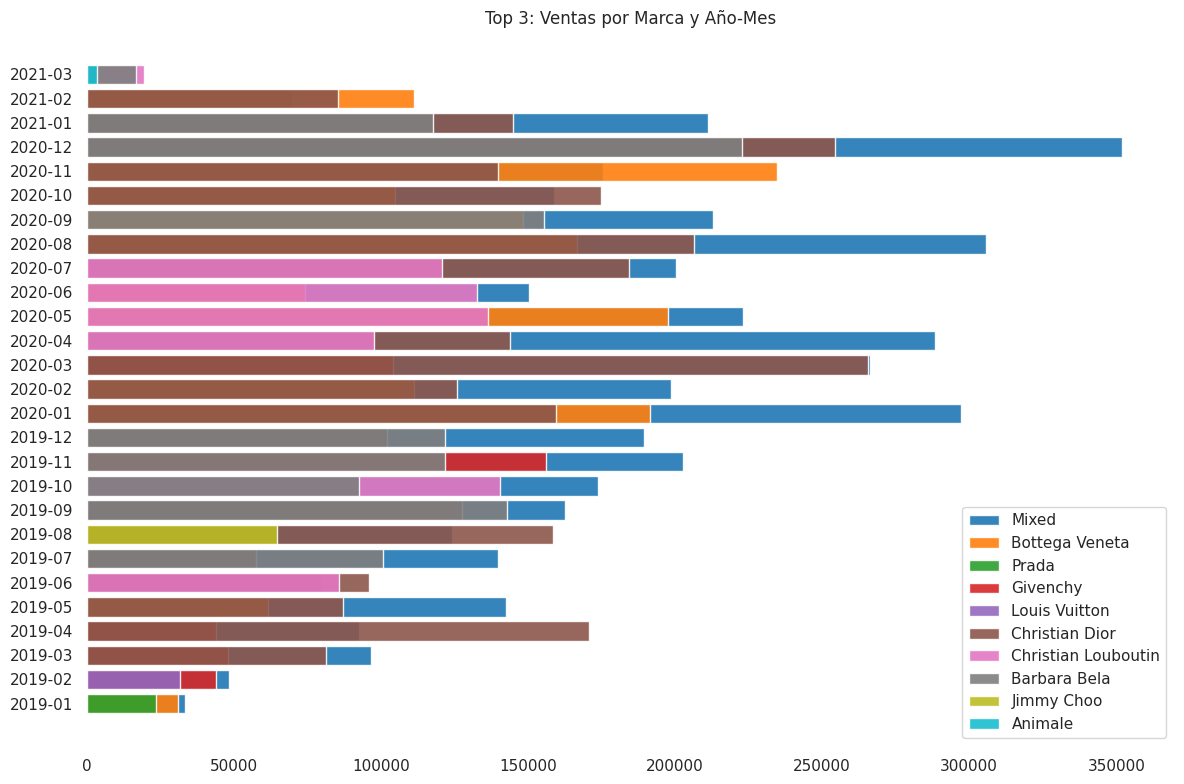

In [144]:
df=top_por_marca_por_año_mes.copy()
año_mes1 = df['año_mes'].unique()
marcas1 = df['marca'].unique()
total1_por_mes_y_marca = df.pivot(index='año_mes', columns='marca', values='total')

# Configuración del gráfico
plt.figure(figsize=(12, 8))
bar_width=.8

for i, marca in enumerate(marcas1):
    plt.barh(año_mes1, list(total1_por_mes_y_marca[marca]), label=marca, alpha=.9, color=plt.cm.tab10(i/len(marcas1)),height=bar_width)
    #         ('Qualitative', ['Pastel1', 'Pastel2', 'Paired', 'Accent','Dark2', 'Set1', 'Set2', 'Set3','tab10', 'tab20', 'tab20b', 'tab20c'])


plt.xlabel('')
plt.ylabel('')
plt.title(f'Top {top}: Ventas por Marca y Año-Mes')
# plt.xticks(rotation=45, labels=[format_ticks(value, None) for value in y])
plt.xticks( rotation=0 )
plt.legend()
plt.tight_layout()
plt.box(None)
plt.grid(None)
plt.show()

In [145]:
len( top_por_marca_por_año_mes)

81

In [146]:
df = top_por_marca_por_año_mes.copy()
listas=df['año_mes'].values
listas_values=[]
for i in range(1,82):
  if 27>i:
    value=listas[2+3*i]
    listas_values.append(f'lista_{value}----{i}')

In [147]:
listas_values

['lista_2019-02----1',
 'lista_2019-03----2',
 'lista_2019-04----3',
 'lista_2019-05----4',
 'lista_2019-06----5',
 'lista_2019-07----6',
 'lista_2019-08----7',
 'lista_2019-09----8',
 'lista_2019-10----9',
 'lista_2019-11----10',
 'lista_2019-12----11',
 'lista_2020-01----12',
 'lista_2020-02----13',
 'lista_2020-03----14',
 'lista_2020-04----15',
 'lista_2020-05----16',
 'lista_2020-06----17',
 'lista_2020-07----18',
 'lista_2020-08----19',
 'lista_2020-09----20',
 'lista_2020-10----21',
 'lista_2020-11----22',
 'lista_2020-12----23',
 'lista_2021-01----24',
 'lista_2021-02----25',
 'lista_2021-03----26']

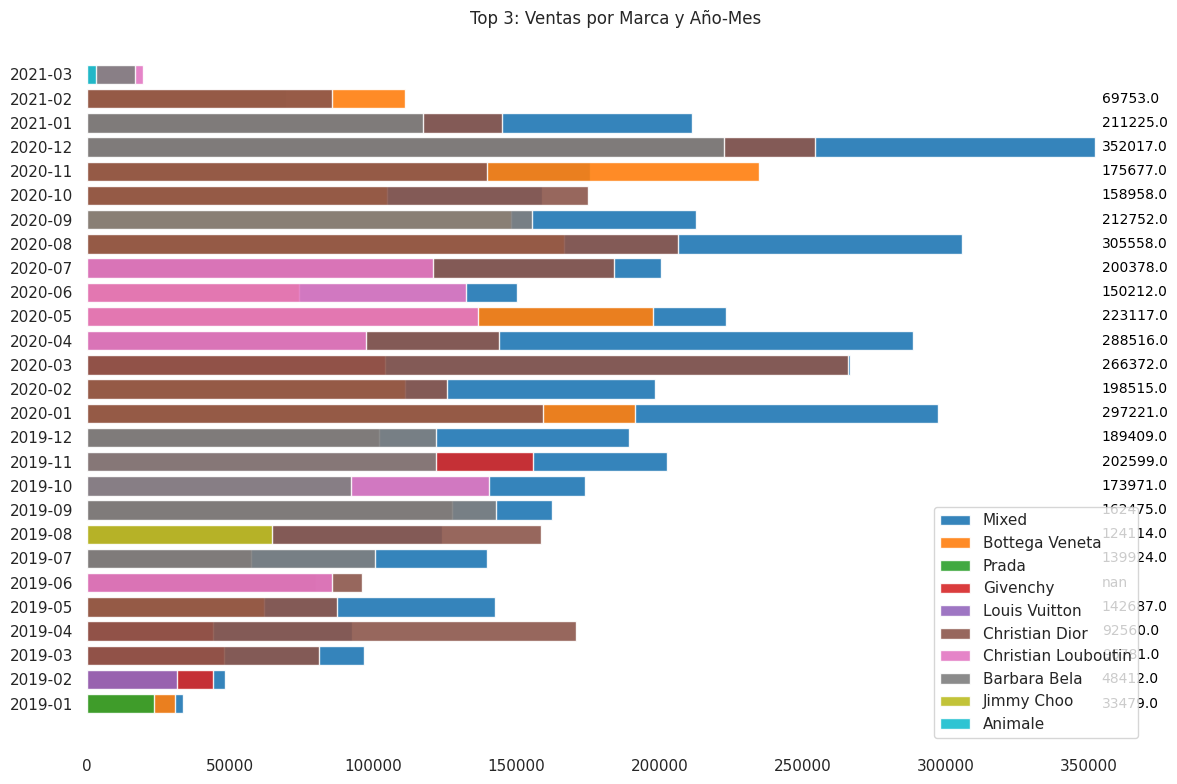

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tienes los datos cargados en el DataFrame df
df = top_por_marca_por_año_mes.copy()
año_mes = df['año_mes'].unique()
marcas = df['marca'].unique()
total_por_mes_y_marca = df.pivot(index='año_mes', columns='marca', values='total')

# Configuración del gráfico
plt.figure(figsize=(12, 8))
bar_width = 0.8
count=0
count_valor=[]
for i, marca in enumerate(marcas):
    plt.barh(año_mes, list(total_por_mes_y_marca[marca]), label=marca, alpha=0.9, color=plt.cm.tab10(i / len(marcas)), height=bar_width)

    # Anotar los valores al final de cada barra
    for y, valor in zip(año_mes, total_por_mes_y_marca[marca]):
        count_valor.append(y)
        if len(count_valor)<=26:
          plt.annotate(f'{valor}', xy=(352e3, y), xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=10, color='black')
        # print(valor)

plt.xlabel('')
plt.ylabel('')
plt.title(f'Top {top}: Ventas por Marca y Año-Mes')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.box(None)
plt.grid(None)
plt.show()


In [149]:
!pip install bar_chart_race --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 3.6 MB/s eta 0:00:00


In [150]:
df=df_query_2_11.copy()
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])
top=5
# Crear una nueva columna para el año y mes en formato 'aaaa-mm'
df['año_mes'] = df['fecha_compra'].dt.strftime('%Y-%b')
ventas_por_marca_y_mes = df.groupby(['año_mes', 'marca'])['total'].sum().reset_index()
top_por_marca_por_año_mes = (ventas_por_marca_y_mes.groupby('año_mes')
                                .apply(lambda x: x.nlargest(top, 'total'))
                                .reset_index(drop=True))
df_pivot = top_por_marca_por_año_mes.pivot(index='año_mes', columns='marca', values='total')
df_pivot=df_pivot.fillna(0)
df_pivot.astype(int)

marca     Animale  Barbara Bela  Bottega Veneta  Christian Dior  \
año_mes                                                           
2019-Apr        0             0           30875          170750   
2019-Aug        0         58800               0          158500   
2019-Dec        0        121800           74100          102000   
2019-Feb    30756         25200               0               0   
2019-Jan        0             0           30875               0   
2019-Jul        0        100800               0           57500   
2019-Jun        0             0           55575           96000   
2019-Mar        0         42000               0           81250   
2019-May        0             0           61750           87250   
2019-Nov        0        121800               0          120250   
2019-Oct        0         92400           86450           56500   
2019-Sep        0        142800               0          127500   
2020-Apr    77094             0               0          144000   
2020-Aug        0             0          166725          206500   
2020-Dec        0        222600               0          254250   
2020-Feb        0             0          111150          125750   
2020-Jan        0         84000          191425          159500   
2020-Jul        0             0               0          184250   
2020-Jun        0             0           74100               0   
2020-Mar        0         88200               0          265750   
2020-May        0             0          197600               0   
2020-Nov    66168         63000          234650          139750   
2020-Oct    88845             0          104975          175000   
2020-Sep        0        155400          148200          130000   
2021-Feb    44164             0          111150           85500   
2021-Jan        0        117600           98800          145000   
2021-Mar     3358         16800               0               0   

marca     Christian Louboutin  Givenchy  Iorane  Isolda  J. Crew  Jimmy Choo  \
año_mes                                                                        
2019-Apr                    0     44000       0       0        0           0   
2019-Aug                    0         0       0       0        0       64750   
2019-Dec                81900         0       0       0        0           0   
2019-Feb                    0     44000       0       0        0           0   
2019-Jan                    0         0       0    7670        0           0   
2019-Jul                    0     56000       0       0        0           0   
2019-Jun                85800     80000       0       0        0           0   
2019-Mar                    0     48000       0       0        0           0   
2019-May                    0         0       0       0        0           0   
2019-Nov                    0    156000       0       0        0           0   
2019-Oct               140400         0       0       0        0           0   
2019-Sep                    0         0       0       0        0           0   
2020-Apr                97500         0       0       0        0           0   
2020-Aug               120900         0       0       0        0           0   
2020-Dec                    0    148000       0       0        0      134680   
2020-Feb                    0         0       0       0        0           0   
2020-Jan               101400         0       0       0        0           0   
2020-Jul               120900         0       0       0        0       85470   
2020-Jun               132600     52000       0       0        0           0   
2020-Mar               101400    104000       0       0        0           0   
2020-May               136500         0       0       0        0           0   
2020-Nov                    0         0       0       0        0           0   
2020-Oct                    0         0       0       0        0       80290   
2020-Sep               124800         0       0       0 

In [151]:
import bar_chart_race as bcr

# animacion_top_5 = bcr.bar_chart_race(df_pivot, steps_per_period=10, period_length=1000,
#                    fixed_max=True,
#                    fixed_order=False,
#                    n_bars=5,
#                    figsize=(9, 5),
#                    title='Top 10: Ventas por Marca',
#                    title_size=20,
#                    label_bars=True,
#                    bar_size=0.95,
#                    period_label={'x': 0.9, 'y': 0.8, 'ha': 'right', 'va': 'center', 'fontsize': 14, 'color': 'navy'},
#                    tick_label_size=8, bar_label_size=8,
#                    period_fmt='Año {x}')

# animacion_top_5


In [152]:
###  GUARDAR GRAFICA  ####
## Guardar la animación como un archivo MP4
# import bar_chart_race as bcr

# bcr.bar_chart_race(df_pivot,'/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/bar_chart_race/animacion_top_5.mp4', steps_per_period=10, period_length=1000,
#                    fixed_max=True,
#                    fixed_order=False,
#                    n_bars=5,
#                    figsize=(9, 5),
#                    title='Top 5: Ventas por Marca',
#                    title_size=20,
#                    label_bars=True,
#                    bar_size=0.95,
#                    period_label={'x': 0.9, 'y': 0.8, 'ha': 'right', 'va': 'center', 'fontsize': 14, 'color': 'navy'},
#                    tick_label_size=8, bar_label_size=8,
#                    period_fmt='Año {x}')

In [153]:
# Seleccionar el segundo valor (top 2) por marca por año-mes
top_1_por_marca_por_año_mes = (top_por_marca_por_año_mes.groupby('año_mes').nth(0)
                                .reset_index(drop=True))
top_2_por_marca_por_año_mes = (top_por_marca_por_año_mes.groupby('año_mes').nth(1)
                                .reset_index(drop=True))
top_3_por_marca_por_año_mes = (top_por_marca_por_año_mes.groupby('año_mes').nth(2)
                                .reset_index(drop=True))
top_1_por_marca_por_año_mes.head(5)

año_mes           marca   total
0  2019-Apr  Christian Dior  170750
1  2019-Aug  Christian Dior  158500
2  2019-Dec           Mixed  189409
3  2019-Feb           Mixed   48412
4  2019-Jan           Mixed   33479

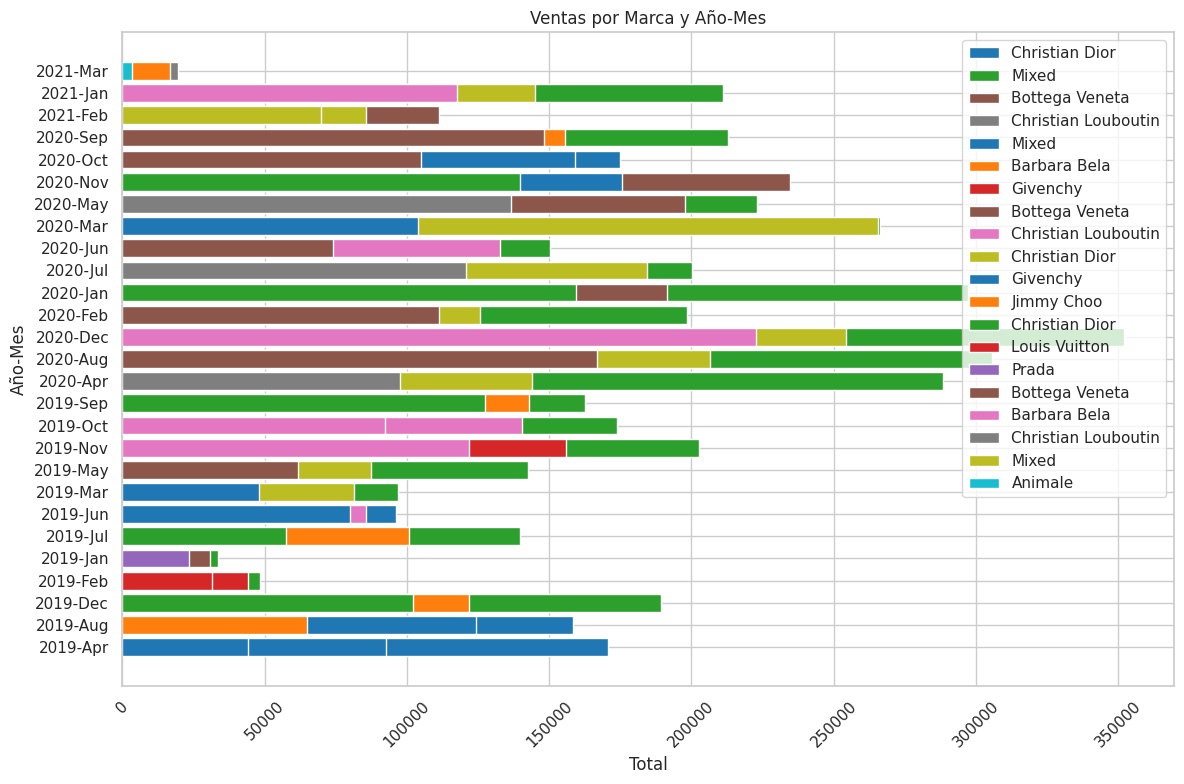

In [154]:
df=top_1_por_marca_por_año_mes
año_mes1 = df['año_mes'].unique()
marcas1 = df['marca'].unique()
total1_por_mes_y_marca = df.pivot(index='año_mes', columns='marca', values='total')

df=top_2_por_marca_por_año_mes
año_mes2 = df['año_mes'].unique()
marcas2 = df['marca'].unique()
total2_por_mes_y_marca = df.pivot(index='año_mes', columns='marca', values='total')

df=top_3_por_marca_por_año_mes
año_mes3 = df['año_mes'].unique()
marcas3 = df['marca'].unique()
total3_por_mes_y_marca = df.pivot(index='año_mes', columns='marca', values='total')

# Configuración del gráfico
plt.figure(figsize=(12, 8))
bar_width=.8

for i, marca in enumerate(marcas1):
    plt.barh(año_mes1, list(total1_por_mes_y_marca[marca]), label=marca, alpha=1, color=plt.cm.tab10(i/len(marcas1)),height=bar_width)

for i, marca in enumerate(marcas2):
    plt.barh(año_mes2, list(total2_por_mes_y_marca[marca]), label=marca, alpha=1, color=plt.cm.tab10(i/len(marcas2)),height=bar_width)

for i, marca in enumerate(marcas3):
    plt.barh(año_mes3, list(total3_por_mes_y_marca[marca]), label=marca, alpha=1, color=plt.cm.tab10(i/len(marcas3)),height=bar_width)

# Añadir etiquetas y título
plt.xlabel('Total')
plt.ylabel('Año-Mes')
plt.title('Ventas por Marca y Año-Mes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

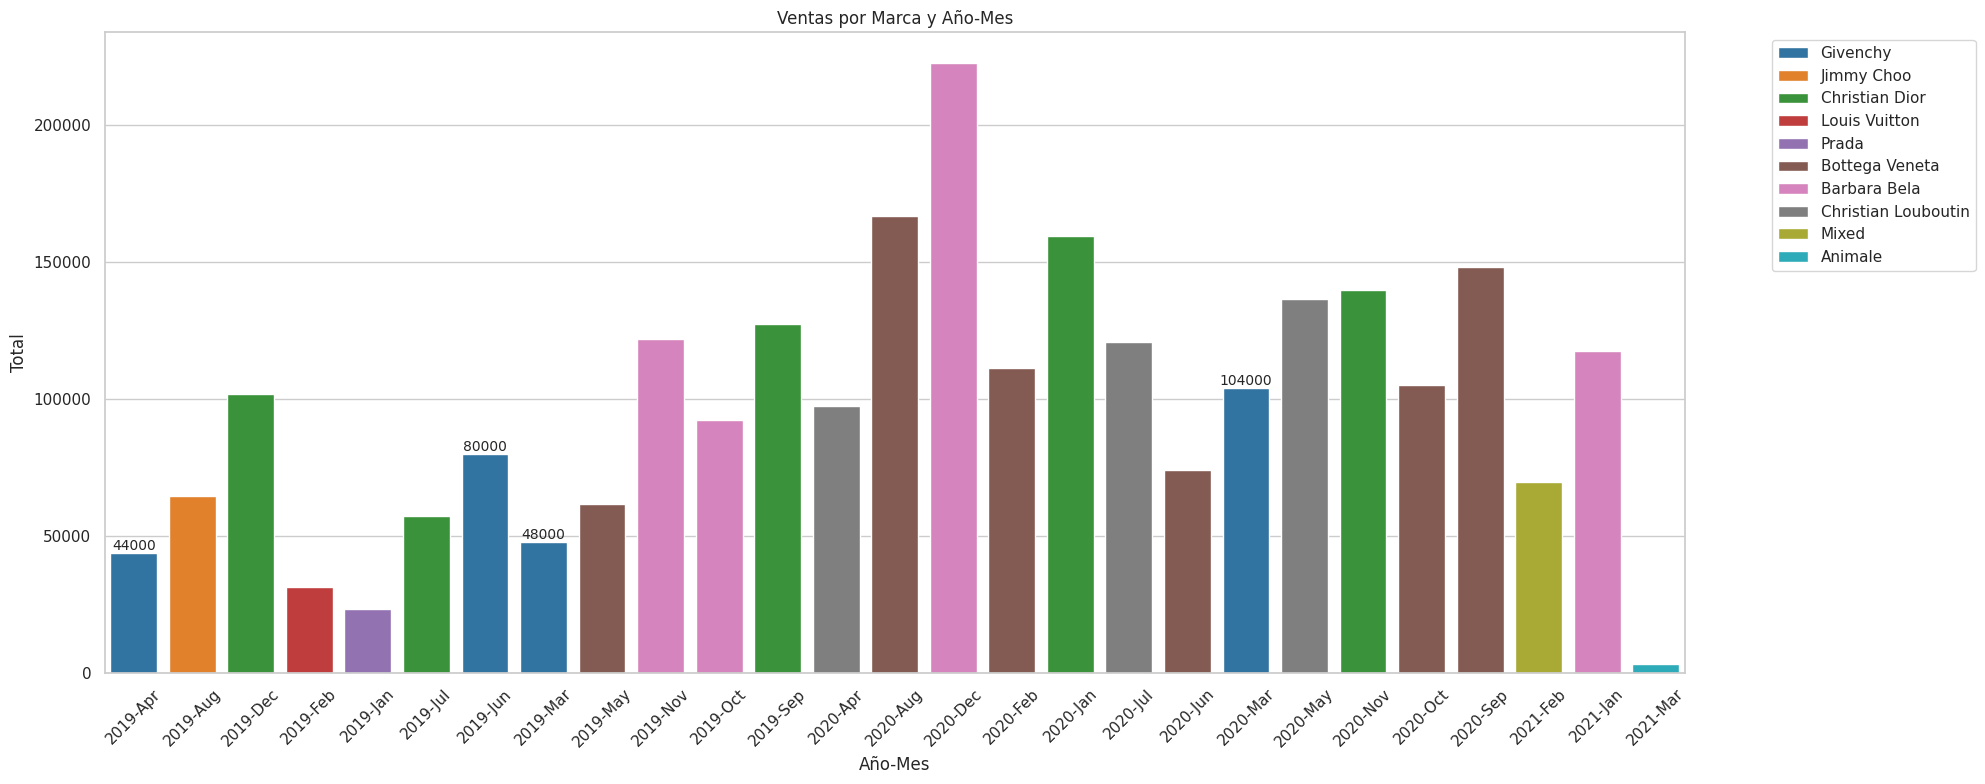

In [155]:
año_mes = df['año_mes'].unique()
marcas = df['marca'].unique()

plt.figure(figsize=(20, 8))

# Graficar barras verticales y paralelas para cada marca y mes
ax= sns.barplot(data=df, x='año_mes', y='total', hue='marca', palette='tab10')
ax.bar_label(ax.containers[0], fontsize=10)
# sns.barplot(data=df, x='año_mes', y='total', hue='marca', palette='tab10',errorbar = None,linewidth = 1, edgecolor = "red")

plt.xlabel('Año-Mes')
plt.ylabel('Total')
plt.title('Ventas por Marca y Año-Mes')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# paginas de referencia de data:

##LOGISTICA:
**https://marketfinder.thinkwithgoogle.com/intl/es_es/guide/ingram-brazil-guide#fn:10**

**https://startupeable.com/logistica/**

##E-COMMERCE
**https://www.mordorintelligence.ar/industry-reports/brazil-ecommerce-market**



In [156]:
todos_unicos = (df_productos.sku.value_counts() == 1).all()
todos_unicos

True

In [157]:
df_productos.sku.value_counts()


sku
209297.0    1
263656.0    1
312258.0    1
295249.0    1
255377.0    1
           ..
232886.0    1
126190.0    1
111937.0    1
214670.0    1
255410.0    1
Name: count, Length: 205, dtype: int64

In [158]:
df_productos.head(1)

producto_id              producto  precio                marca       sku  \
0        21244  Oculos Lente Azulada  1120.0  D&g Dolce & Gabbana  209297.0   

  condicion  
0     Usado

In [159]:
df_productos.groupby(['marca','sku'])['producto'].unique()

marca    sku     
284      283163.0      [Camiseta Animal Print]
A.brand  142974.0           [Bota Veludo Azul]
         308475.0      [Camisa Verde Classica]
Adidas   101494.0        [Tenis Tecido Purple]
Agilità  313737.0        [Calca Costuras Bege]
                               ...            
Zara     295222.0      [Blusa Roxa Babadinhos]
         304416.0    [Blusa Coracao Pedrarias]
         304783.0            [Capa Fio Marrom]
         304828.0     [Blusinha Basica Mescla]
         322472.0      [Blusa Laranja Golinha]
Name: producto, Length: 205, dtype: object

In [160]:
df_query_5.sku.value_counts()

sku
302628.0    154
208772.0    148
294463.0    147
318626.0    144
211116.0    144
           ... 
205904.0    100
219782.0    100
220768.0     99
287524.0     96
254726.0     94
Name: count, Length: 205, dtype: int64

In [161]:
df_query_5.head(1)

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2           2764   

            producto  precio  marca       sku           condicion  \
0  Saia Jeans Forest   576.0  Mixed  222683.0  Nuevo con etiqueta   

   nombre_vendedor abbrev_state  code_state  name_state  code_region  \
0  Daniel Siqueira           PE        26.0  Pernambuco          2.0   

  name_region                                           geometry  \
0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   

  rango_costo_envio  
0              Alto

In [162]:
df_query_5.condicion.value_counts()

condicion
Usado                 21050
Nuevo con etiqueta     2605
Nuevo sin etiqueta      871
Name: count, dtype: int64

In [163]:
df_query_5.producto.value_counts()

producto
Calca Jeans Costuras          229
Vestido Recortes Cores        228
Calca Alfaiataria Preta       226
Saia Pregas Preta             217
Saia Midi Cinto               154
                             ... 
Casaco Preto Amarracao        100
Vestido Estampa Pb            100
Pantacourt Amarracao Verde     99
Blusa Listrada Malha           96
Blusa Malha Azul               94
Name: count, Length: 201, dtype: int64

In [164]:
sku_product = df_query_5.groupby('sku')['producto'].agg(list).reset_index()
sku_product

sku                                           producto
0    101494.0  [Tenis Tecido Purple, Tenis Tecido Purple, Ten...
1    103277.0  [Camiseta Neon Bordado, Camiseta Neon Bordado,...
2    104978.0  [Vestido Longo Preto, Vestido Longo Preto, Ves...
3    105695.0  [Blazer Cinza E Azul Marinho, Blazer Cinza E A...
4    108831.0  [Vestido Amarelo Laco, Vestido Amarelo Laco, V...
..        ...                                                ...
200  947042.0  [Calca Jeans Ilhos, Calca Jeans Ilhos, Calca J...
201  947046.0  [Saia Midi Tricolor, Saia Midi Tricolor, Saia ...
202  947048.0  [Calca Verde Bolsos, Calca Verde Bolsos, Calca...
203  952813.0  [Calca Alfaiataria Preta, Calca Alfaiataria Pr...
204  952821.0  [Sapato Python, Sapato Python, Sapato Python, ...

[205 rows x 2 columns]

In [165]:
sku_product=df_query_5.groupby('sku')['producto'].unique().tolist()
df_sku_product=pd.DataFrame(sku_product,columns=['producto'])
counts = df_sku_product['producto'].value_counts()
repeated_products = df_sku_product[df_sku_product['producto'].isin(counts[counts > 1].index)]
repeated_products_sorted = repeated_products.T.sort_values(by='producto', ascending=True, axis=1).T
repeated_products_sorted

producto
101  Calca Alfaiataria Preta
203  Calca Alfaiataria Preta
65      Calca Jeans Costuras
167     Calca Jeans Costuras
13         Saia Pregas Preta
35         Saia Pregas Preta
94    Vestido Recortes Cores
104   Vestido Recortes Cores

In [166]:
df_query_5.head()

pedido_id  producto_id  vendedor_id fecha_compra  total  id_recibo  \
0          1         5292            2   2020-02-16   3456      10062   
1        107        41189            2   2020-01-17    800       8839   
2        210        10086            1   2020-02-25   4500      10466   
3        356        56571            1   2019-12-25    420       8015   
4        434        40082            4   2019-12-11   1260       7600   

   cantidad  valor_unitario  valor_total ciudad  costo_envio  ganancia_neta  \
0         6             576         3456  BR-PE        691.2           2764   
1         5             160          800  BR-PE        160.0            640   
2         6             750         4500  BR-PE        900.0           3600   
3         1             420          420  BR-PE         84.0            336   
4         4             315         1260  BR-PE        252.0           1008   

                producto  precio           marca       sku  \
0      Saia Jeans Forest   576.0           Mixed  222683.0   
1  Calca Acetinada Preta   160.0            Zara  176893.0   
2           Oculos Metal   750.0  Christian Dior  319314.0   
3    Vestido Seda Floral   420.0         Animale  178553.0   
4   Vestido Malha Vitral   315.0           Forum  324684.0   

            condicion  nombre_vendedor abbrev_state  code_state  name_state  \
0  Nuevo con etiqueta  Daniel Siqueira           PE        26.0  Pernambuco   
1               Usado  Daniel Siqueira           PE        26.0  Pernambuco   
2               Usado       Ana Duarte           PE        26.0  Pernambuco   
3               Usado       Ana Duarte           PE        26.0  Pernambuco   
4               Usado  Millena Pereira           PE        26.0  Pernambuco   

   code_region name_region                                           geometry  \
0          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
1          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
2          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
3          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   
4          2.0    Nordeste  MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ...   

  rango_costo_envio  
0              Alto  
1              Bajo  
2              Alto  
3              Bajo  
4             Medio

In [167]:
marca = {
    'marca': ['D&g Dolce & Gabbana', 'Givenchy', 'Joe Fresh', 'Mixed', 'Zara',
       'Gap', 'Banana Republic', 'Fyi', 'Sacada', 'Rag & Bone', 'Cori',
       'Forever 21', 'Tigresse', 'Tory Burch', 'Brooksfield', 'Animale',
       '284', 'Dkny', 'Cheroy', 'Canal', 'Le Lis Blanc', 'Spezzato',
       'Cantão', 'Talie Nk', 'H&M', 'Schutz', 'Jorge Bischoff', #27
       'Luisa Farani', 'Seven', 'Kipling', 'Louis Vuitton', 'Agilità',
       'Fabiana Caterina', 'Reinaldo Lourenço', 'Karmani', 'Erre Erre',
       'H&m', 'Forum', 'Ellus', 'J. Crew', "Joe's", 'Galeria Tricot',
       'Loft 747', 'Oxyfit', 'Topshop', 'A.brand', 'Isolda',
       'American Eagle', 'Colcci', 'Carter’s', 'Thay Ribas', #51
       'Carina Duek', 'Kate Spade', 'Bottega Veneta', 'Morena Rosa',
       'Luiza Barcelos', 'Lezalez', 'My Place', 'Farm', 'Armani Exchange',
       'Bcbgmaxzria', 'Dica da Ka', 'My Shoes', 'Argentum',
       'Red Valentino', 'Maria Filó', 'Marc By Marcjacobs',
       'Track & Field', 'Christian Dior', 'Toca do Coelho',
       'Barbara Bela', 'Miu Miu', 'Gregory', 'Prada', 'Steal The Look',
       'Shoulder', 'Maria Bonita', 'Isa Kulikovski', 'Ralph Lauren',
       'Camila Klein', 'Bazar Genial', 'Hollister', 'Diesel', #83
       'All Saints Spitalfields', 'Iorane', 'Felini', 'Miss Sixty',
       'Linda de Morrer', 'Vera Wang', 'Daslu', 'Adidas', 'Amaro',
       'Jimmy Choo', 'Sweet Cotton', 'Cris Barros', 'Mara Mac',
       'Paula Raia', 'Dress&co', 'Mango', 'Ateliê de Calças', 'Thelure', #101
       'Converse', "Levi's", 'Lemon Cola', 'Limone By Jade Seba',
       'Espaço Fashion', 'Seal Brasil', 'Alix Shop', 'Bo. bô.',
       'Lauren Ralph Lauren', 'Christian Louboutin', 'Saad', 'Osklen',
       'Skazi', 'Carol Bassi', 'Calvin Klein', 'Express','Bobô'],


    'marca_genero': ['U', 'F', 'F', 'F', "F", "U", "U", "U", "F", "F", "F", "F", "F", "F", "M", "F",
                              "F", "F", "F", "U", "F", "F", "F", "U", "U", "F", "F", "F", "U", "U", "U", "F", "F",
                              "F", "F", "F", "U", "M", "U", "F", "U", "F", "F", "F", "F", "F", "F", "U", "F",
                              "U", "F", "F", "F", "U", "F", "F", "F", "F", "F", "M", "F", "F", "F", "F", "U",
                              "F", "F", "F", "U", "U", "F", "F", "U", "F", "F", "F", "F", "F", "U", "F", "U",
                              "U", "U", "U", "F", "M", "F", "F", "F", "F", "U", "F", "U", "F", "F", "U", "F",
                              "F", "F", "F", "F", "U", "U", "F", "F", "F", "M", "F", "F", "F", "F", "U", "U",
                               "F", "F", "U", "U","F"]}



df_marca_genero = pd.DataFrame(marca)
df_merged = pd.merge(df_query_5, df_marca_genero, on='marca', how='inner')

In [168]:

df_vendedor_genero_condicion = df_merged.groupby(['condicion', 'nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
df_vendedor_genero_condicion


condicion  nombre_vendedor marca_genero  ganancia_neta
0   Nuevo con etiqueta       Ana Duarte            F         655478
1   Nuevo con etiqueta       Ana Duarte            M          20672
2   Nuevo con etiqueta       Ana Duarte            U          41824
3   Nuevo con etiqueta  Daniel Siqueira            F         739175
4   Nuevo con etiqueta  Daniel Siqueira            M          29184
5   Nuevo con etiqueta  Daniel Siqueira            U          62520
6   Nuevo con etiqueta  Millena Pereira            F         616623
7   Nuevo con etiqueta  Millena Pereira            M          21280
8   Nuevo con etiqueta  Millena Pereira            U          64616
9   Nuevo con etiqueta   Nadia Oliveira            F         623620
10  Nuevo con etiqueta   Nadia Oliveira            M          38000
11  Nuevo con etiqueta   Nadia Oliveira            U          63424
12  Nuevo con etiqueta    Paulo Calanca            F         730577
13  Nuevo con etiqueta    Paulo Calanca            M          22192
14  Nuevo con etiqueta    Paulo Calanca            U          49880
15  Nuevo sin etiqueta       Ana Duarte            F         169288
16  Nuevo sin etiqueta       Ana Duarte            U          82272
17  Nuevo sin etiqueta  Daniel Siqueira            F         230712
18  Nuevo sin etiqueta  Daniel Siqueira            U          68857
19  Nuevo sin etiqueta  Millena Pereira            F         138088
20  Nuevo sin etiqueta  Millena Pereira            U          81299
21  Nuevo sin etiqueta   Nadia Oliveira            F         147736
22  Nuevo sin etiqueta   Nadia Oliveira            U          74780
23  Nuevo sin etiqueta    Paulo Calanca            F         161688
24  Nuevo sin etiqueta    Paulo Calanca            U          85125
25               Usado       Ana Duarte            F        4289896
26               Usado       Ana Duarte            M         129120
27               Usado       Ana Duarte            U        2367019
28               Usado  Daniel Siqueira            F        4163169
29               Usado  Daniel Siqueira            M         125900
30               Usado  Daniel Siqueira            U        2287473
31               Usado  Millena Pereira            F        3346630
32               Usado  Millena Pereira            M         100552
33               Usado  Millena Pereira            U        1888748
34               Usado   Nadia Oliveira            F        4028473
35               Usado   Nadia Oliveira            M         121804
36               Usado   Nadia Oliveira            U        2055924
37               Usado    Paulo Calanca            F        4537893
38               Usado    Paulo Calanca            M         144296
39               Usado    Paulo Calanca            U        2035920

In [169]:
# Seleccionar todas las filas donde marca_genero es igual a 'U'
filas_U = df_merged[df_merged['marca_genero'] == 'U']
filas_U.producto.unique()


array(['Oculos Metal', 'Bolsa Classica Roxa', 'Camisa Jeans Classica',
       'Camisa Xadrez Azul', 'Regata Nude Textura',
       'Blusinha Guipir Black', 'Calca Ziper Preto',
       'Casaco Preto Botoes', 'Saia Amarela Faixa', 'Calca Jeans Basica',
       'Tenis Xadrez Tecido', 'Body Estampa Coracoes',
       'Conjunto Body Calca', 'Macaquinho Tricot Bege',
       'Calca Preta Resinada', 'Vestido Nude Reta', 'Calca Veludo Cotele',
       'Blusa Tricot Mescla', 'Blazer Cinza E Azul Marinho',
       'Calca Estampa Flare', 'Blusa Babados Cats',
       'Vestido Preto Franzido', 'Vestido Estampa Pb',
       'Cropped Courino Texturas', 'Vestido Preto Amarracao',
       'Regata Listras Azul', 'Regata Estampa Roxa', 'Calca Estampa Pb',
       'Vestido Polo Lilas', 'Blusa Tricot Lilas',
       'Bolsa Vermelha Brilhos', 'Oculos Lente Azulada',
       'Bermuda Jeans Lavagem', 'Calca Jeans Costuras',
       'Shorts Listras Bordados', 'Mala Bolsos Preta',
       'Regata Bicolor Alcinha', 'Vestido 

In [170]:
df_vendedor_genero_condicion = df_merged.groupby(['fecha_compra' ,'condicion', 'nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
df_vendedor_genero_condicion

fecha_compra           condicion  nombre_vendedor marca_genero  \
0      2019-01-05  Nuevo sin etiqueta   Nadia Oliveira            F   
1      2019-01-05               Usado       Ana Duarte            F   
2      2019-01-05               Usado  Daniel Siqueira            F   
3      2019-01-05               Usado  Millena Pereira            F   
4      2019-01-05               Usado   Nadia Oliveira            U   
...           ...                 ...              ...          ...   
9477   2021-03-09               Usado       Ana Duarte            F   
9478   2021-03-09               Usado  Daniel Siqueira            F   
9479   2021-03-10               Usado       Ana Duarte            F   
9480   2021-03-10               Usado  Millena Pereira            F   
9481   2021-03-10               Usado   Nadia Oliveira            F   

      ganancia_neta  
0              1120  
1              1989  
2              1260  
3              2767  
4             24700  
...             ...  
9477           1888  
9478           2240  
9479          15600  
9480            208  
9481            333  

[9482 rows x 5 columns]

In [171]:
ganancia_por_vendedor_genero = df_vendedor_genero_condicion.groupby(['nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
ganancia_por_vendedor_genero

nombre_vendedor marca_genero  ganancia_neta
0        Ana Duarte            F        5114662
1        Ana Duarte            M         149792
2        Ana Duarte            U        2491115
3   Daniel Siqueira            F        5133056
4   Daniel Siqueira            M         155084
5   Daniel Siqueira            U        2418850
6   Millena Pereira            F        4101341
7   Millena Pereira            M         121832
8   Millena Pereira            U        2034663
9    Nadia Oliveira            F        4799829
10   Nadia Oliveira            M         159804
11   Nadia Oliveira            U        2194128
12    Paulo Calanca            F        5430158
13    Paulo Calanca            M         166488
14    Paulo Calanca            U        2170925

In [172]:
# Filtrar las filas con años anteriores a 2021 en el campo fecha_compra
import pandas as pd

# Convertir la columna fecha_compra al tipo de datos de fecha
df_vendedor_genero_condicion['fecha_compra'] = pd.to_datetime(df_vendedor_genero_condicion['fecha_compra'])

# Filtrar las filas según años anteriores a 2021
df_filtrado = df_vendedor_genero_condicion[df_vendedor_genero_condicion['fecha_compra'].dt.year < 2021]

# Calcular la ganancia neta por vendedor y género de marca
ganancia_por_vendedor_genero_ano2019al2020 = df_filtrado.groupby(['nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
ganancia_por_vendedor_genero_ano2019al2020

nombre_vendedor marca_genero  ganancia_neta
0        Ana Duarte            F        4789384
1        Ana Duarte            M         139988
2        Ana Duarte            U        2278736
3   Daniel Siqueira            F        4849196
4   Daniel Siqueira            M         148056
5   Daniel Siqueira            U        2290045
6   Millena Pereira            F        3821248
7   Millena Pereira            M         109580
8   Millena Pereira            U        1928123
9    Nadia Oliveira            F        4238486
10   Nadia Oliveira            M         146216
11   Nadia Oliveira            U        1959057
12    Paulo Calanca            F        5143105
13    Paulo Calanca            M         156016
14    Paulo Calanca            U        2013055

In [173]:
ganancia_vendedor_2019and2020=ganancia_por_vendedor_genero_ano2019al2020.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()
ganancia_vendedor_2019and2020

nombre_vendedor  ganancia_neta
0       Ana Duarte        7208108
1  Daniel Siqueira        7287297
2  Millena Pereira        5858951
3   Nadia Oliveira        6343759
4    Paulo Calanca        7312176

In [174]:
df_query_5.ganancia_neta.sum()

36641727

In [175]:
df_vendedor_genero_condicion.ganancia_neta.sum()

36641727

36641727


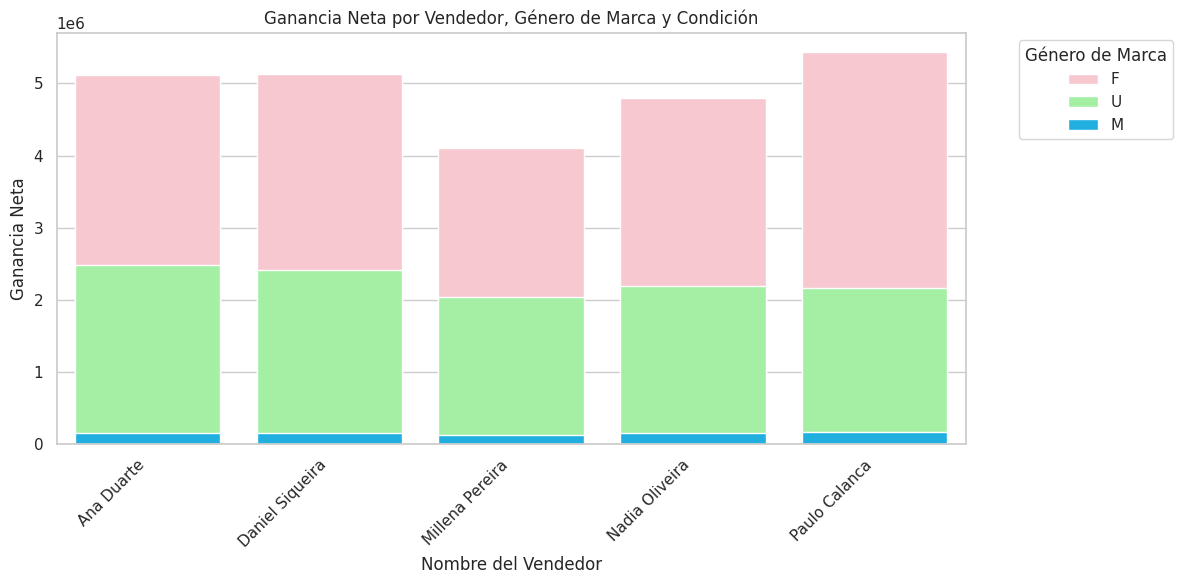

In [176]:
df=ganancia_por_vendedor_genero.copy()
print(df.ganancia_neta.sum())
plt.figure(figsize=(12, 6))

# Graficar utilizando seaborn
sns.barplot(data=df, x='nombre_vendedor', y='ganancia_neta', hue='marca_genero', hue_order=['F', 'U', 'M'], palette=['pink','palegreen','deepskyblue'], errorbar=None,dodge=False)

# Añadir etiquetas y título
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Ganancia Neta')
plt.title('Ganancia Neta por Vendedor, Género de Marca y Condición')

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar la leyenda fuera del gráfico
plt.legend(title='Género de Marca', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que quepa todo
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [177]:
ganancia_vendedor_2019and2020

nombre_vendedor  ganancia_neta
0       Ana Duarte        7208108
1  Daniel Siqueira        7287297
2  Millena Pereira        5858951
3   Nadia Oliveira        6343759
4    Paulo Calanca        7312176

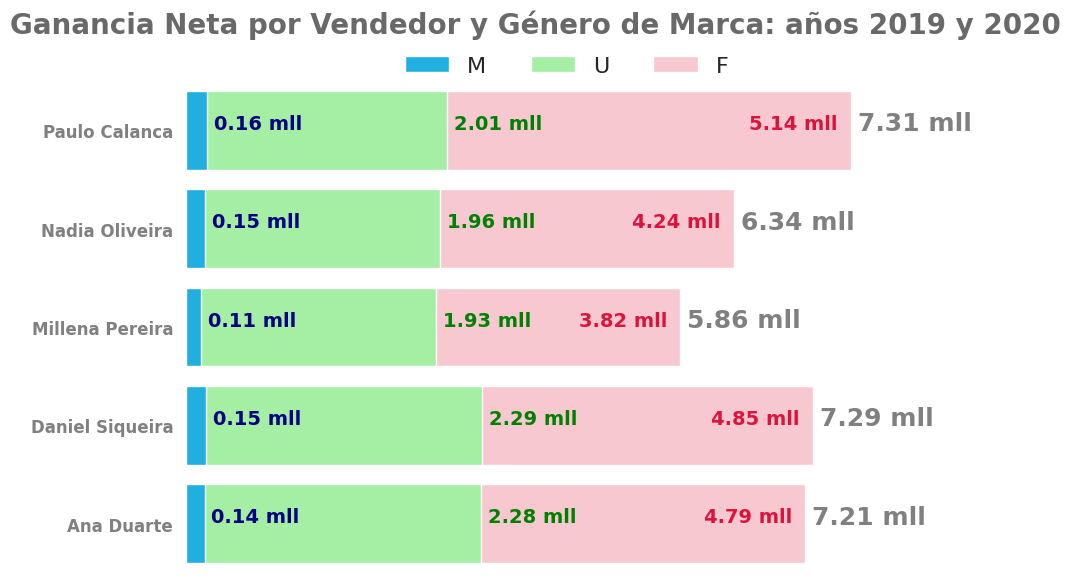

In [282]:
df=ganancia_por_vendedor_genero_ano2019al2020.copy()
plt.subplots(figsize=(10, 6),facecolor='none')

ganancia_vendedor_2019and2020=ganancia_por_vendedor_genero_ano2019al2020.groupby('nombre_vendedor')['ganancia_neta'].sum().reset_index()

ax = sns.barplot(data=df, y='nombre_vendedor', x='ganancia_neta', hue='marca_genero', hue_order=['F', 'U', 'M'], palette=['pink','palegreen','deepskyblue'], errorbar=None, dodge=False)

plt.xlabel('')
plt.ylabel('')
plt.title('Ganancia Neta por Vendedor y Género de Marca: años 2019 y 2020',fontsize=20, color='dimgray', fontweight='bold',pad=35)
plt.gca().invert_yaxis()

# Mostrar los valores en las barras
for p in ax.patches:
  if (p.get_width() != 0) and (p.get_width() < 5e5):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='navy', fontsize=14,fontweight= 'bold')
  if (p.get_width() != 0) and (p.get_width() > 5e5)and (p.get_width() < 3e6):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='green', fontsize=14,fontweight= 'bold')

for p, total in zip(ax.patches,ganancia_vendedor_2019and2020.ganancia_neta):
  if (p.get_width() != 0) and (p.get_width() > 3e6):
        ax.annotate(f'{str(round(p.get_width()/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='crimson', fontsize=14,fontweight= 'bold')
        ax.annotate(f'{str(round(total/1e6,2))} mll   ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='gray', fontsize=18,fontweight= 'bold')

plt.xticks([])
plt.yticks(color='gray', fontsize=12,fontweight= 'bold')
plt.grid(False)
plt.box(False)
# plt.yticks([])

# Ajustar la leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles=handles, labels=labels, title='', bbox_to_anchor=(0.3, 1.07), loc='upper left', borderaxespad=0., ncol=3, frameon=False,fontsize=16)

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/vendedor_ganancia_genero.png', dpi=300)
plt.show()

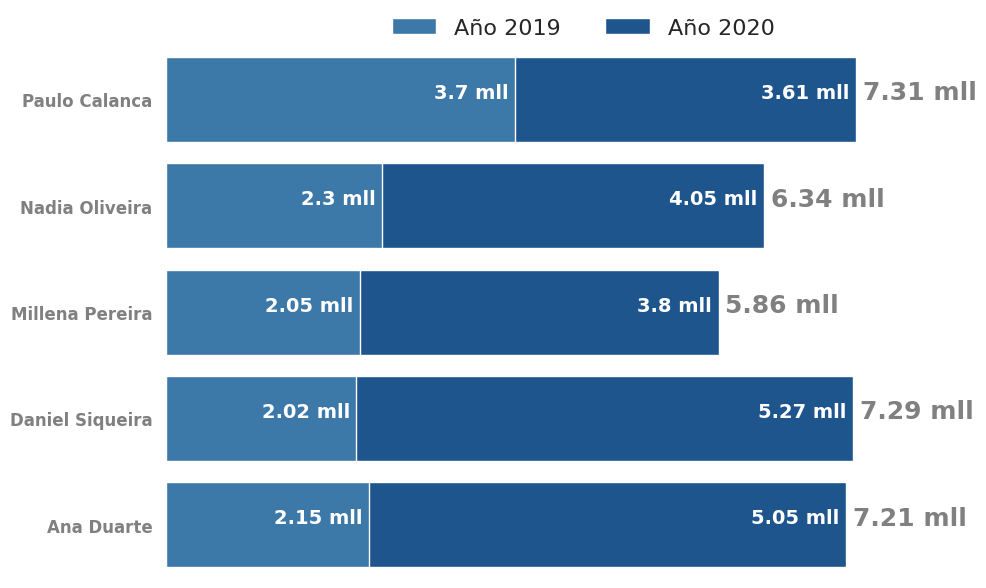

In [283]:
df = df_query_3.copy()
df['Total'] = df['Año 2019'] + df['Año 2020']

plt.subplots(figsize=(10, 6),facecolor='none')

ax = sns.barplot(data=df, y='nombre_vendedor', x='Total', errorbar=None, dodge=False,label='Año 2020')
ax1 = sns.barplot(data=df, y='nombre_vendedor', x='Año 2019', errorbar=None, dodge=False,label='Año 2019')

plt.xlabel('')
plt.ylabel('')
# plt.title('Ganancia Neta por Vendedor: años 2019 y 2020', fontsize=20, color='dimgray', fontweight='bold', pad=35)
plt.gca().invert_yaxis()

# Mostrar los valores en las barras para el año 2019
for p in ax1.patches:
    if p.get_width() <4e6:
        ax1.annotate(f'{str(round(p.get_width()/1e6, 2))} mll  ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='white', fontsize=14, fontweight='bold')
    if p.get_width() >5.5e6:
        ax1.annotate(f'{str(round(p.get_width()/1e6, 2))} mll', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='left', va='center', color='grey', fontsize=18, fontweight='bold')

for p,valor_2020 in zip(ax1.patches,df['Año 2020']):
    # if (p.get_width() >4e6) & (p.get_width() <5.5e6) :
        ax1.annotate(f'{str(round(valor_2020/1e6, 2))} mll  ', (p.get_width(), p.get_y() + p.get_height() / 2), xytext=(5, 5), textcoords='offset points', ha='right', va='center', color='white', fontsize=14, fontweight='bold')

plt.xticks([])
plt.yticks(color='gray', fontsize=12, fontweight='bold')
plt.grid(False)
plt.box(False)

handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(title='',handles=handles,labels=labels, bbox_to_anchor=(0.3, 1.07), loc='upper left', borderaxespad=0., ncol=3, frameon=False,fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/vendedor_ganancia_2019and2020.png', dpi=300)
plt.show()


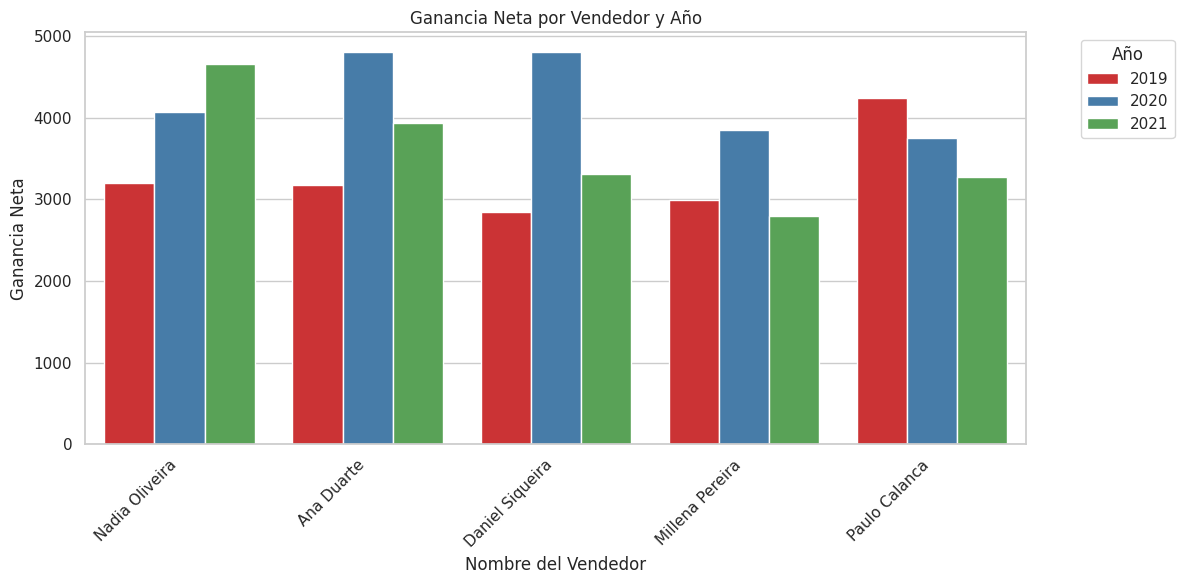

In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copiar el DataFrame original
df = df_vendedor_genero_condicion.copy()

# Convertir la columna 'fecha_compra' a tipo datetime
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Extraer el año de la fecha
df['year'] = df['fecha_compra'].dt.year

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar utilizando seaborn
sns.barplot(data=df, x='nombre_vendedor', y='ganancia_neta', hue='year', palette='Set1', errorbar=None)

# Añadir etiquetas y título
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Ganancia Neta')
plt.title('Ganancia Neta por Vendedor y Año')

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar la leyenda fuera del gráfico
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que quepa todo
plt.tight_layout()

# Mostrar la gráfica
plt.show()


<ipython-input-181-0d8edbfb9f40>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='nombre_vendedor', y='ganancia_neta', hue='marca_genero', hue_order=['F', 'U', 'M'], palette='Set1', ci=None, estimator=sum)


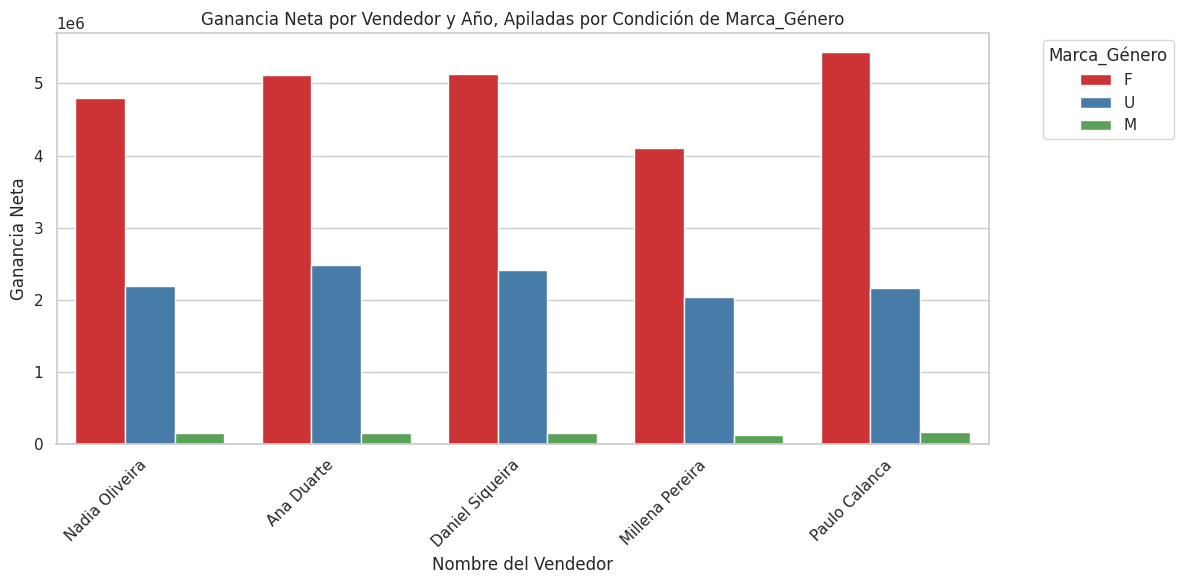

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copiar el DataFrame original
df = df_vendedor_genero_condicion.copy()

# Convertir la columna 'fecha_compra' a tipo datetime y extraer el año
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])
df['year'] = df['fecha_compra'].dt.year

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar utilizando seaborn
sns.barplot(data=df, x='nombre_vendedor', y='ganancia_neta', hue='marca_genero', hue_order=['F', 'U', 'M'], palette='Set1', ci=None, estimator=sum)

# Añadir etiquetas y título
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Ganancia Neta')
plt.title('Ganancia Neta por Vendedor y Año, Apiladas por Condición de Marca_Género')

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar la leyenda fuera del gráfico
plt.legend(title='Marca_Género', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que quepa todo
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [182]:
ganancia_por_vendedor_genero = df.groupby(['nombre_vendedor', 'marca_genero'])['ganancia_neta'].sum().reset_index()
ganancia_por_vendedor_genero

nombre_vendedor marca_genero  ganancia_neta
0        Ana Duarte            F        5114662
1        Ana Duarte            M         149792
2        Ana Duarte            U        2491115
3   Daniel Siqueira            F        5133056
4   Daniel Siqueira            M         155084
5   Daniel Siqueira            U        2418850
6   Millena Pereira            F        4101341
7   Millena Pereira            M         121832
8   Millena Pereira            U        2034663
9    Nadia Oliveira            F        4799829
10   Nadia Oliveira            M         159804
11   Nadia Oliveira            U        2194128
12    Paulo Calanca            F        5430158
13    Paulo Calanca            M         166488
14    Paulo Calanca            U        2170925